# Chapter 3: Vector Autoregressive Methods

Prepared by: Maria Eloisa Ventura and Antonio Briza

Previously, we have introduced the classical approaches in forecasting single/univariate time series like the 
ARIMA (autoregressive integrated moving-average) model and the simple linear regression model. We learned that stationarity is a condition that is necessary when using ARIMA while this need not be imposed when using the linear regression model. In this notebook, we extend the forecasting problem to a more generalized framework where we deal with **multivariate time series**--time series which has more than one time-dependent variable. More specifically, we introduce **vector autoregressive (VAR)** models and show how they can be used in forecasting mutivariate time series. 

## Multivariate Time Series Model

As shown in the previous chapters, one of the main advantages of using simple univariate methods (e.g., ARIMA) is the ability to forecast future values of one variable by only using past values of itself. However, we know that most if not all of the variables that we observe are actually dependent on other variables. Most of the time, the information that we gather is limited by our capacity to measure the variables of interest. For example, if we want to study weather in a particular city, we could measure temperature, humidity and precipitation over time. But if we only have a thermometer, then we'll only be able to collect data for temperature, effectively reducing our dataset to a univariate time series. 

Now, in cases where we have multiple time series (longitudinal measurements of more than one variable), we can actually use multivariate time series models to understand the relationships of the different variables over time. 
By utilizing the additional information available from related series, these models can often provide better forecasts than the univariate time series models.

In this section, we cover the foundational information needed to understand Vector Autoregressive Models, a class of multivariate time series models, by using a framework similar to univariate time series laid out in the previous chapters, and extending it to the multivariate case. 

### Definition: Univariate vs Multivariate Time Series

Time series can either be univariate or multivariate. The term **univariate time series** consists of single observations recorded sequentially over equal time increments. When dealing with a univariate time series model (e.g., ARIMA), we usually refer to a model that contains lag values of itself as the independent variable. 

On the other hand, a **multivariate time series** has more than one time-dependent variable. For a multivariate process, several related time series are observed simultaneously over time. As an extension of the univariate case, the multivariate time series model involves two or more input variables, and leverages the interrelationship among the different time series variables. 

In [1]:
import numpy as np
import pandas as pd
import statsmodels.tsa as tsa
from statsmodels.tsa.vector_ar.var_model import VAR, FEVD
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, adfuller, ccf, ccovf, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import sympy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mvts_utils as utils
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

## Example 1: Multivariate Time Series

We provide below real-world examples of some multivariate time series.

Let us first define a utility function for plotting the data in a dataframe

In [2]:
def dfplot(df, columns=None, title="", figsize=(15,8), 
           ylabels=None, xlabel='', plot_legend=False, y_tick_pos='right'):
    """ Plot columns of dataframe in separate axes.
        columns is a list of column names to plot
        If columns is None, all columns are plotted
    """
    if not columns:
        columns = list(df.columns)
    fig, ax = plt.subplots(df[columns].shape[-1], figsize=figsize, sharex=True)
    df[columns].plot(subplots=True, legend=plot_legend, ax=ax)
    for a in range(len(ax)): 
        if ylabels: # custom ylabels
            ax[a].set_ylabel(ylabels[a])
        else:
            ax[a].set_ylabel(columns[a])            
        ax[a].yaxis.set_ticks_position(y_tick_pos)
    ax[-1].set_xlabel(xlabel)
    if title:
        fig.suptitle(title)
    plt.tight_layout()
    plt.show()

### A. Air Quality Data from UCI

The dataset contains hourly averaged measurements obtained from an Air Quality Chemical Multisensor Device which was located on the field of a polluted area at an Italian city. The dataset can be downloaded __[here](https://archive.ics.uci.edu/ml/datasets/Air+Quality#)__.

In [3]:
aq_df = pd.read_excel("../data/AirQualityUCI/AirQualityUCI.xlsx", parse_dates=[['Date', 'Time']])\
            .set_index('Date_Time').replace(-200, np.nan).interpolate()
aq_df.head(2)

CO(GT)  PT08.S1(CO)  NMHC(GT)   C6H6(GT)  PT08.S2(NMHC)  \
Date_Time                                                                      
2004-03-10 18:00:00     2.6      1360.00     150.0  11.881723        1045.50   
2004-03-10 19:00:00     2.0      1292.25     112.0   9.397165         954.75   

                     NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  \
Date_Time                                                           
2004-03-10 18:00:00    166.0       1056.25    113.0       1692.00   
2004-03-10 19:00:00    103.0       1173.75     92.0       1558.75   

                     PT08.S5(O3)     T         RH        AH  
Date_Time                                                    
2004-03-10 18:00:00      1267.50  13.6  48.875001  0.757754  
2004-03-10 19:00:00       972.25  13.3  47.700000  0.725487

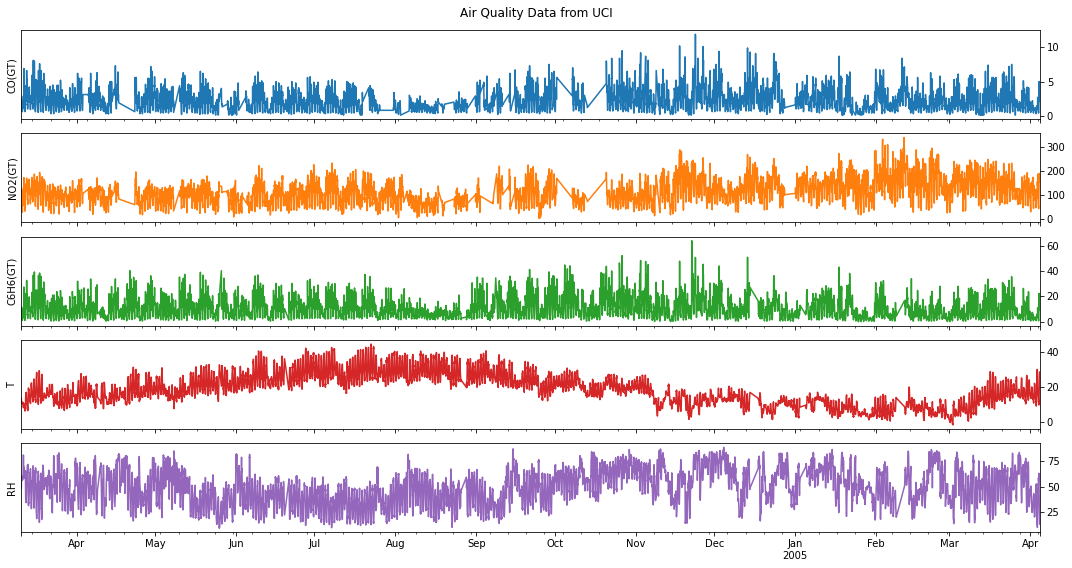

In [4]:
dfplot(aq_df, columns= ['CO(GT)', 'NO2(GT)', 'C6H6(GT)', 'T', 'RH'], title="Air Quality Data from UCI")

### B. Global Health from The World Bank

This dataset combines key health statistics from a variety of sources to provide a look at global health and population trends. It includes information on nutrition, reproductive health, education, immunization, and diseases from over 200 countries. The dataset can be downloaded __[here](https://console.cloud.google.com/marketplace/product/the-world-bank/global-health?filter=solution-type:dataset&filter=category:health&id=f3c38e10-2c45-43c8-8a12-8d749ba987ee)__.

In [5]:
ind_df = pd.read_csv('../data/WorldBankHealth/WorldBankHealthPopulation_SeriesSummary.csv')\
            .loc[:,['series_code', 'indicator_name']].drop_duplicates().reindex()\
            .sort_values('indicator_name').set_index('series_code')
hn_df = pd.read_csv('../data/WorldBankHealth/WorldBankHealthPopulation_HealthNutritionPopulation.csv')\
            .pivot(index='year', columns='indicator_code', values='value')

cols = ['SH.XPD.KHEX.GD.ZS', 'SH.XPD.CHEX.GD.ZS', 'SH.XPD.GHED.GD.ZS']
health_expenditure_df = hn_df.loc[np.arange(2000, 2018), cols]\
    .rename(columns = dict(ind_df.loc[cols].indicator_name\
                           .apply(lambda x: '_'.join(x.split('(')[0].split(' ')[:-1]))))
health_expenditure_df.index = pd.date_range('2000-1-1', periods=len(health_expenditure_df), freq="A-DEC")
health_expenditure_df.head(3)

indicator_code  Capital_health_expenditure  Current_health_expenditure  \
2000-12-31                        0.013654                    3.154818   
2001-12-31                        0.012675                    2.947059   
2002-12-31                        0.018476                    2.733301   

indicator_code  Domestic_general_government_health_expenditure  
2000-12-31                                            1.400685  
2001-12-31                                            1.196554  
2002-12-31                                            1.012481

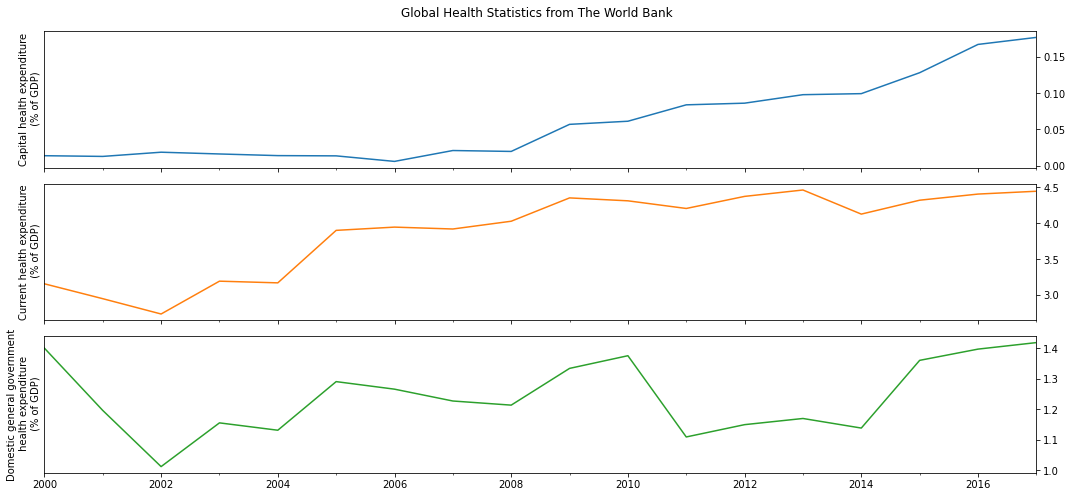

In [6]:
ylabels = ['Capital health expenditure', 'Current health expenditure', 'Domestic general government\n health expenditure']
ylabels = [f"{ylabel}\n (% of GDP)" for ylabel in ylabels]
dfplot(health_expenditure_df,  title="Global Health Statistics from The World Bank", ylabels=ylabels, figsize=(15,7))

### C. US Treasury Rates
January, 1982 – December, 2016  (Weekly)
https://essentialoftimeseries.com/data/
This sample dataset contains weekly data of US Treasury rates from January 1982 to December 2016. The dataset can be downloaded __[here](https://essentialoftimeseries.com/data/)__.

In [7]:
treas_df = pd.read_excel("../data/USTreasuryRates/us-treasury-rates-weekly.xlsx")
treas_df = treas_df.rename(columns={'Unnamed: 0': 'Date'}).set_index('Date')
treas_df.index = pd.to_datetime(treas_df.index)
treas_df.head(3)

1-month  3-month  6-month  1-year  2-year  3-year  5-year  7-year  \
Date                                                                            
1982-01-08   10.296    12.08    13.36   13.80   14.12   14.32   14.46   14.54   
1982-01-15   10.296    12.72    13.89   14.39   14.67   14.73   14.79   14.84   
1982-01-22   10.296    13.47    14.30   14.72   14.93   14.92   14.81   14.80   

            10-year  Excess CRSP Mkt Returns  10-year Treasury Returns  \
Date                                                                     
1982-01-08    14.47                   -1.632                       NaN   
1982-01-15    14.76                   -2.212                      -2.9   
1982-01-22    14.73                   -0.202                       0.3   

            Term spread  Change in term spread  5-year Treasury Returns  \
Date                                                                      
1982-01-08         2.39                    NaN                      NaN   
1982-01-15         2.04                  -0.35                     1.65   
1982-01-22         1.26                  -0.78                     0.10   

            Unnamed: 15  Excess 10-year Treasury Returns  Term Spread  \
Date                                                                    
1982-01-08          NaN                        -0.286662     1.729559   
1982-01-15       -2.556                        -3.758000     4.464000   
1982-01-22        0.049                        -0.558000     4.434000   

                  VXO  Delta VXO  
Date                              
1982-01-08  20.461911  -0.003106  
1982-01-15        NaN        NaN  
1982-01-22        NaN        NaN

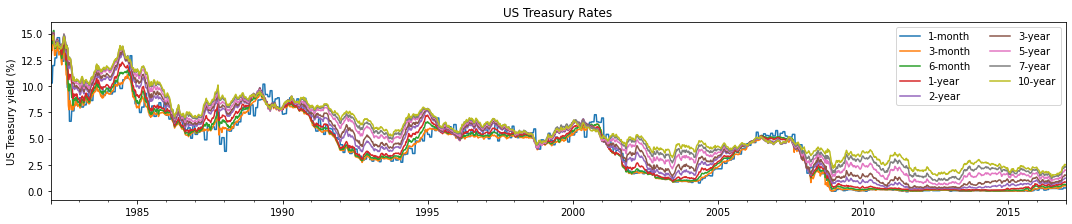

In [8]:
fig,ax = plt.subplots(1, figsize=(15, 3), sharex=True)
data_df = treas_df.iloc[:, 0:9]
data_df.plot(ax=ax)
plt.ylabel('US Treasury yield (%)')
plt.xlabel('')
plt.legend(ncol=2)
plt.tight_layout()
plt.title("US Treasury Rates")
plt.show()

### D. Jena Climate Data
Time series dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany from 2009 to 2016. It contains 14 different quantities (e.g., air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes. You can download the data __[here](https://www.kaggle.com/stytch16/jena-climate-2009-2016)__.

In [9]:
jena_data = pd.read_csv('../data/jena_climate_2009_2016.csv')
jena_data['Date Time'] = pd.to_datetime(jena_data['Date Time'])
jena_data = jena_data.set_index('Date Time')
jena_data.head(3)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   
2009-01-01 00:30:00             3.02       1310.24      0.19           0.63   

                     wd (deg)  
Date Time                      
2009-01-01 00:10:00     152.3  
2009-01-01 00:20:00     136.1  
2009-01-01 00:30:00     171.6

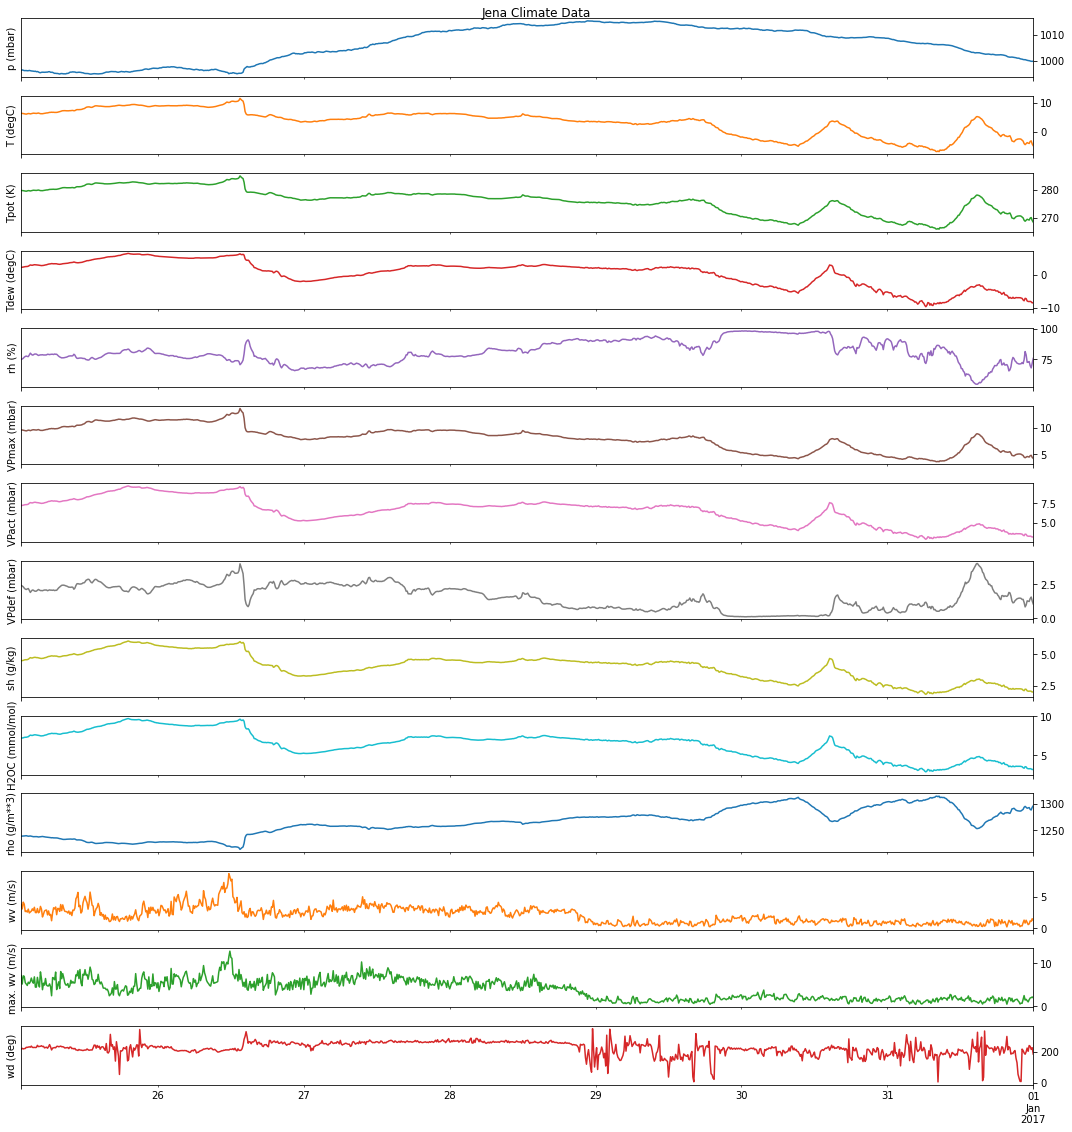

In [10]:
dfplot(jena_data.iloc[-1000:], figsize=(15,16), title="Jena Climate Data")

## Foundations
Before we discuss VARs, we outline some fundamental concepts below that we will need to understand the model. 

### Weak Stationarity of Multivariate Time Series
As in the univariate case, one of the requirements that we need to satisfy before we can apply VAR models is stationarity--in particular, weak stationarity. Both in the univariate and multivariate case, the first two moments of the time series are time-invariant. More formally, we describe weak stationarity below. 


Consider a $N$-dimensional time series, $\mathbf{y}_t = \left[y_{1,t}, y_{2,t}, ..., y_{N,t}\right]^\prime$. This is said to be weakly stationary if the first two moments are finite and constant through time, that is,
1. $E\left[\mathbf{y}_t\right] = \boldsymbol{\mu}$
2. $E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_t-\boldsymbol{\mu})^\prime\right] \equiv \boldsymbol\Gamma_0 < \infty$ for all $t$
3. $E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_{t-h}-\boldsymbol{\mu})^\prime\right] \equiv \boldsymbol\Gamma_h$ for all $t$ and $h$

where the expectations are taken element-by-element over the joint distribution of $\mathbf{y}_t$:
- $\boldsymbol{\mu}$ is the vector of means $\boldsymbol\mu = \left[\mu_1, \mu_2, ..., \mu_N \right]$
- $\boldsymbol\Gamma_0$ is the $N\times N$ covariance matrix where the $i$th diagonal element is the variance of $y_{i,t}$, and the $(i, j)$th element is the covariance between $y_{i,t}$ and ${y_{j,t}}$
- $\boldsymbol\Gamma_h$ is the cross-covariance matrix at lag $h$

###  Obtaining Cross-Correlation Matrix from Cross-Covariance Matrix
When dealing with a multivariate time series, we can examine the predictability of one variable on another by looking at the relationship between them using the cross-covariance function (CCVF) and cross-correlation function (CCF). To do this, we begin by defining the cross-covariance between two variables, then we estimate the cross-correlation between one variable and another variable that is time-shifted. This informs us whether one time series may be related to the past lags of the other. In other words, CCF is used for identifying lags of one variable that might be useful as a predictor of the other variable. 

**At lag 0**:

Let $\mathbf\Gamma_0$ be the covariance matrix at lag 0, $\mathbf D$ be a $N\times N$ diagonal matrix containing the standard deviations of $y_{i,t}$ for $i=1, ..., N$. The correlation matrix of $\mathbf{y}_t$ is defined as

$$\boldsymbol\rho_0 = \mathbf D^{-1}\mathbf\Gamma_0\mathbf D^{-1}$$

where the $(i, j)$th element of $\boldsymbol\rho_0$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t}$ at time $t$:

$$\rho_{i,j}(0) = \dfrac{Cov\left[y_{i,t}, y_{j,t} \right]}{\sigma_{i,t} \sigma_{j,t}}$$

**At lag h**:

Let $\boldsymbol\Gamma_h = E\left[(\mathbf{y}_t-\boldsymbol{\mu})(\mathbf{y}_{t-h}-\boldsymbol{\mu})^\prime\right]$ be the lag-$h$ covariance cross-covariance matrix of $\mathbf y_{t}$. The lag-$h$ cross-correlation matrix is defined as

$$\boldsymbol\rho_h = \mathbf D^{-1}\mathbf\Gamma_h\mathbf D^{-1}$$

The $(i,j)$th element of $\boldsymbol\rho_h$ is the correlation coefficient between $y_{i,t}$ and $y_{j,t-h}$:

$$\rho_{i,j}(h) = \dfrac{Cov\left[y_{i,t}, y_{j,t-h} \right]}{\sigma_{i,t} \sigma_{j,t}}$$


**What do we get from this?**

|Correlation Coefficient| Interpretation |
|:----|:----|
|$\rho_{i,j}(0)\neq0$|$y_{i,t}$ and $y_{j,t}$ are *contemporaneously linearly correlated*|
|$\rho_{i,j}(h)=\rho_{j,i}(h)=0$ for all $h\geq0$|$y_{i,t}$ and $y_{j,t}$ share *no linear relationship*|
|$\rho_{i,j}(h)=0$ and $\rho_{j,i}(h)=0$ for all $h>0$|$y_{i,t}$ and $y_{j,t}$ are said to be linearly *uncoupled*|
|$\rho_{i,j}(h)=0$ for all $h>0$, but $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *unidirectional (linear) relationship* between $y_{i,t}$ and $y_{j,t}$, where $y_{i,t}$ does not depend on $y_{j,t}$, but $y_{j,t}$ depends on (some) lagged values of $y_{i,t}$|
|$\rho_{i,j}(h)\neq0$ for at least some $h>0$ and $\rho_{j,i}(q)\neq0$ for at least some $q>0$|There is a *bi-directional (feedback) linear relationship* between $y_{i,t}$ and $y_{j,t}$|

## Vector Autoregressive (VAR) Models 

The vector autoregressive (VAR) model is one of the most successful models for analysis of multivariate time series. It has been demonstrated to be successful in describing relationships and forecasting economic and financial time series, and providing more accurate forecasts than the univariate time series models and theory-based simultaneous equations models. 

The structure of the VAR model is just the **generalization of the univariate AR** model. It is a system regression model that treats all the variables as endogenous, and allows each of the variables to depend on $p$ lagged values of itself and of all the other variables in the system. 

A VAR model of order $p$ can be represented as

$$\mathbf y_t=\mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf A_2 \mathbf y_{t-2} + ... + \mathbf A_p \mathbf y_{t-p} + \mathbf u_t = \mathbf a_0  + \sum_{j=1}^{p} \mathbf A_j \mathbf y_{t-j} + \mathbf u_t   $$ 

where $\mathbf y_t$ is a $N\times 1$ vector containing $N$ endogenous variables, $\mathbf a_0$ is a $N\times 1$ vector of constants, $\mathbf A_1, \mathbf A_2, ..., \mathbf A_p$ are the $p$ $N\times N$ matrices of autoregressive coefficients, and $\mathbf u_t$ is a $N\times 1$ vector of white noise disturbances. 

To visualize, the equation above is rendered in matrix format below:

$$
\begin{bmatrix}
y_{1,t} \\
y_{2,t} \\
\vdots \\
y_{N,t} \\
\end{bmatrix} 
%
=
\begin{bmatrix}
a_{0_1} \\
a_{0_2} \\
\vdots \\
a_{0_N} \\
\end{bmatrix} 
%
+
\begin{bmatrix}
A_{1_{1,1}} & A_{1_{1,2}} & ... &  A_{1_{1,N}}\\
A_{1_{2,1}} & A_{1_{2,2}} & ... &  A_{1_{2,N}}\\
\vdots & \vdots & \ddots & \vdots \\
A_{1_{N,1}} & A_{1_{N,2}} & ... &  A_{1_{N,N}}\\
\end{bmatrix} 
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1} \\
\vdots \\
y_{N,t-1} \\
\end{bmatrix} 
%
+...+
\begin{bmatrix}
A_{p_{1,1}} & A_{p_{1,2}} & ... &  A_{p_{1,N}}\\
A_{p_{2,1}} & A_{p_{2,2}} & ... &  A_{p_{2,N}}\\
\vdots & \vdots & \ddots & \vdots \\
A_{p_{N,1}} & A_{p_{N,2}} & ... &  A_{p_{N,N}}\\
\end{bmatrix} 
\begin{bmatrix}
y_{1,t-p} \\
y_{2,t-p} \\
\vdots \\
y_{N,t-p} \\
\end{bmatrix} 
%
+
\begin{bmatrix}
u_{1,t} \\
u_{2,t} \\
\vdots \\
u_{N,t}
\end{bmatrix}
%
$$

### VAR(1) Model
To illustrate, let's consider the simplest VAR model where we have $p=1$.


#### Structural and Reduced Forms of the VAR model

Consider the following bivariate system

$$ y_{1,t} = b_{1,0} - b_{1,2}y_{2,t} +  \varphi_{1,1}y_{1,t-1} + \varphi_{1,2}y_{2,t-1} + \varepsilon_{1,t}$$

$$ y_{2,t} = b_{2,0} - b_{2,1}y_{1,t} +  \varphi_{2,1}y_{1,t-1} + \varphi_{2,2}y_{2,t-1} + \varepsilon_{2,t}$$

where both $y_{1,t}$ and $y_{2,t}$ are assumed to be stationary, and $\varepsilon_{1,t}$ and $\varepsilon_{2,t}$ are the uncorrelated error terms with standard deviation $\sigma_{1,t}$ and $\sigma_{2,t}$, respectively. 

In matrix notation: 

$$
\begin{bmatrix}
1       & b_{1,2} \\
b_{2,1} & 1 \\
\end{bmatrix} 
%
\begin{bmatrix}
y_{1, t} \\
y_{2, t} \\
\end{bmatrix} 
%
=
%
\begin{bmatrix}
b_{1, 0} \\
b_{2, 0} \\
\end{bmatrix} 
%
+
%
\begin{bmatrix}
\varphi_{1_{1,1}} & \varphi_{1_{1,2}} \\
\varphi_{1_{2,1}} & \varphi_{1_{2,2}} \\
\end{bmatrix} 
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1} \\
\end{bmatrix} 
%
+
\begin{bmatrix}
\varepsilon_{1, t} \\
\varepsilon_{2, t} \\
\end{bmatrix}
%
$$

Let 

$$
B \equiv
\begin{bmatrix}
1       & b_{1,2} \\
b_{2,1} & 1 \\
\end{bmatrix} 
%
,\quad y_t \equiv
\begin{bmatrix}
y_{1, t} \\
y_{2, t} \\
\end{bmatrix} 
%
,\quad Q_0 \equiv
\begin{bmatrix}
b_{1, 0} \\
b_{2, 0} \\
\end{bmatrix} 
%
,\quad Q_1 \equiv
\begin{bmatrix}
\varphi_{1_{1,1}} & \varphi_{1_{1,2}} \\
\varphi_{1_{2,1}} & \varphi_{1_{2,2}} \\
\end{bmatrix} 
%
,\quad y_{t-1} \equiv
\begin{bmatrix}
y_{1,t-1} \\
y_{2,t-1} \\
\end{bmatrix} 
%
,\quad \varepsilon_t \equiv
\begin{bmatrix}
\varepsilon_{1, t} \\
\varepsilon_{2, t} \\
\end{bmatrix}
%
$$

then 

$$\mathbf B \mathbf y_t = \mathbf Q_0 + \mathbf Q_1 \mathbf y_{t-1} + \boldsymbol\varepsilon_t$$

##### Structural VAR (VAR in primitive form)
- Described by equation above
- Captures contemporaneous feedback effects ($b_{1,2}, b_{2,1}$)
- Not very practical to use 
- Contemporaneous terms cannot be used in forecasting
- Needs further manipulation to make it more useful (e.g. multiplying the matrix equation by $\mathbf B^{-1}$)

Multiplying the matrix equation by $\mathbf B^{-1}$, we get

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf u_t $$

or 

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 L\mathbf y_t + \mathbf u_t$$

where $\mathbf a_0 = \mathbf B^{-1}\mathbf Q_0$, $\mathbf A_1 = \mathbf B^{-1}\mathbf Q_1$, $L$ is the lag/backshift operator, and $\mathbf u_t = \mathbf B^{-1}\boldsymbol\varepsilon_t$, equivalently,

$$ y_{1,t} = a_{1,0} + a_{1,1}y_{1,t-1} + a_{1,2}y_{2,t-1} + u_{1,t}$$

$$ y_{2,t} = a_{2,0} + a_{2,1}y_{1,t-1} + a_{2,2}y_{2,t-1} + u_{2,t}$$

##### Reduced-form VAR (VAR in standard form)
- Described by equation above
- Only dependent on lagged endogenous variables (no contemporaneous feedback)
- Can be estimated using ordinary least squares (OLS)

#### VMA infinite representation and Stationarity

Consider the reduced form, standard VAR(1) model

$$\mathbf y_t = \mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf u_t \label{eq:var_1} \tag{Eq.1}$$ 

Assuming that the process is weakly stationary and taking the expectation of $\mathbf y_t$, we have

$$E\left[\mathbf y_t\right] = \mathbf a_0 + \mathbf A_1 E\left[\mathbf y_{t-1}\right]$$

where $E\left[\mathbf u_t\right]=0.$ If we let $\tilde{\mathbf y}_{t}\equiv \mathbf y_t - \boldsymbol \mu$ be the mean-corrected time-series, we can write the model as

$$\tilde{\mathbf y}_{t} = \mathbf A_1 \tilde{\mathbf y}_{t-1} + \mathbf u_t$$

Substituting $\tilde{\mathbf y}_{t-1} = \mathbf A_1 \tilde{\mathbf y}_{t-2} + \mathbf u_{t-1}$, 

$$\tilde{\mathbf y}_{t} = \mathbf A_1 \left( \mathbf A_1 \tilde{\mathbf y}_{t-2} + \mathbf u_{t-1}\right)+ \mathbf u_t$$

If we keep iterating, we get

$$\mathbf y_{t} = \boldsymbol\mu + \sum_{i=1}^{\infty} \mathbf A_1^i  \mathbf u_{t-i} + \mathbf u_t$$

Letting $\boldsymbol\Theta_i\equiv A_1^i$, we get the **VMA infinite representation**


$$\mathbf y_{t} = \boldsymbol\mu + \sum_{i=1}^{\infty} \boldsymbol\Theta_i  \mathbf u_{t-i} + \mathbf u_t \label{eq:var_inf} \tag{Eq.2}$$



#### Stationarity of the VAR(1) model
- All the N eigenvalues of the matrix $A_1$ must be less than 1 in modulus, to avoid that the coefficient matrix $A_1^j$ from either exploding or converging to a nonzero matrix as $j$ goes to infinity.
- Provided that the covariance matrix of $u_t$ exists, the requirement that all the eigenvalues of $A_1$ are less than one in modulus is a necessary and sufficient condition for $y_t$ to be stable, and thus, stationary. 
- All roots of $det\left(\mathbf I_N - \mathbf A_1 z\right)=0$ must lie outside the unit circle. 

### VAR($p$) Model

Consider the VAR($p$) model described by 

$$\mathbf y_t=\mathbf a_0 + \mathbf A_1 \mathbf y_{t-1} + \mathbf A_2 \mathbf y_{t-2} + ... + \mathbf A_p \mathbf y_{t-p} + \mathbf u_t \label{eq:var_p} \tag{Eq.3}$$ 

$$y_t= \mathbf a_0  + \sum_{j=1}^{p} \mathbf A_j \mathbf y_{t-j} + \mathbf u_t$$ 

Using the lag operator $L$, we get 

$$\tilde{\mathbf A} (L) \mathbf y_t = \mathbf a_0 + \mathbf u_t$$

where $\tilde{\mathbf A} (L) = (\mathbf I_N - A_1 L - ... - A_p L^p)$. 

Assuming that $\mathbf y_t$ is weakly stationary, we obtain that $$

$$\boldsymbol\mu = E\left[\mathbf y_t\right] = (\mathbf I_N - A_1 L - ... - A_p L^p)^{-1} \mathbf a_0$$

Defining $\tilde{\mathbf y}_t=\mathbf y_t -\boldsymbol\mu$, we have

$$\tilde{\mathbf y}_t =  \mathbf A_1 \tilde{\mathbf y}_{t-1} + \mathbf A_2 \tilde{\mathbf y}_{t-2} + ... + \mathbf A_p \tilde{\mathbf y}_{t-p} + \mathbf u_t$$

##### Properties
- $Cov[\mathbf y_t, \mathbf u_t] = \Sigma_u$, the covariance matrix of $\mathbf u_t$
- $Cov[\mathbf y_{t-h}, \mathbf u_t] = \mathbf 0$ for any $h>0$
- $\boldsymbol\Gamma_h = \mathbf A_1 \boldsymbol\Gamma_{h-1} +...+\mathbf A_p \boldsymbol\Gamma_{h-p}$ for $h>0$
- $\boldsymbol\rho_h = \boldsymbol \Psi_1 \boldsymbol\Gamma_{h-1} +...+\boldsymbol \Psi_p \boldsymbol\Gamma_{h-p}$ for $h>0$, where $\boldsymbol \Psi_i = \mathbf D^{-1/2}\mathbf A_i D^{-1/2}$

#####  Stationarity of VAR($p$) model
- The polynomial described by $det\left(\mathbf I_N - \mathbf A_1 z - ...-  \mathbf A_p z^p\right)$ is called the *reverse characteristic polynomial*. The requirement for stationarity is that all roots of this polynomial must lie outside the unit circle. In other words, $|z|>1$ for all $z$ that solves 
$$ det\left(\mathbf I_N - \mathbf A_1 z - ...-  \mathbf A_p z^p\right) = 0$$


### Specification of a VAR model: Choosing the order $p$

Fitting a VAR model involves the selection of a single parameter: the model order or lag length $p$. The most common approach in selecting the best model is choosing the $p$ that minimizes one or more information criteria evaluated over a range of model orders. The criterion consists of two terms: the first one characterizes the entropy rate or prediction error, and second one characterizes the number of freely estimated parameters in the model. Minimizing both terms will allow us to identify a model that accurately models the data while preventing overfitting (due to too many parameters). 

Some of the commonly used information criteria include: Akaike Information Criterion (AIC), Schwarz's Bayesian Information Criterion (BIC), Hannan-Quinn Criterion (HQ), and Akaike’s Final Prediction Error Criterion (FPE). The equation for each are shown below. 

*Akaike's information criterion*

$$(M)\operatorname{AIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + 2\dfrac{k}{T}$$

*Schwarz’s Bayesian information criterion*

$$(M)\operatorname{BIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + \dfrac{k}{T}\operatorname{ln}(T)$$

*Hannan-Quinn’s information criterion*

$$(M)\operatorname{HQIC} = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + \dfrac{k}{T}\operatorname{ln}(\operatorname{ln}(T))$$

*Final prediction error*

$$\operatorname{FPE}(p) = \left(\dfrac{T+Np+1}{T-Np+1} \right)^N |\tilde{\boldsymbol\Sigma}_u | $$

$$\operatorname{ln}(\operatorname{FPE}(p)) = \operatorname{ln}|\tilde{\boldsymbol\Sigma}_u | + N \operatorname{ln}\left(\dfrac{T+Np+1}{T-Np+1} \right) $$



where $M$ stands for multivariate, $\tilde{\boldsymbol\Sigma}_u$ is the estimated covariance matrix of the residuals, $T$ is the number of observations in the sample, and $k$ is the total number of equations in the VAR($p$) (i.e. $N^2p + N$ where $N$ is the number of equations and $p$ is the number of lags).

Among the metrics above, AIC and BIC are the most widely used criteria, but BIC penalizes higher orders more. For moderate and large sample sizes, AIC and FPE are essentially equivalent, but FPE may outperform AIC for small sample sizes. HQ also penalizes higher order models more heavily than AIC, but less than BIC. However, under small sample conditions, AIC/FPE may outperform BIC and/or HQ in selecting true model order. 

There are cases when AIC and FPE show no clear minimum over a range or model orders or lag lengths. In this case, there may be a clear "elbow" when we plot the values over model order. This may indicate a suitable model order. 

## Steps in Building a VAR Model

We outline below the steps in building a VAR model.

#### 1. Select the variables to include in the model
Include variables that are relevant to the dynamics of the system under study. Many times, this requires domain knowledge of the problem at hand. In cases where there are many variables to consider, printing or plotting cross-correlations may help identify which variables to investigate.

#### 2. Do an Exploratory Data Analysis of the variables
As in any modeling task, an exploratory data analysis can help provide initial insights on how to create the model or what approach to take in creating one. Check the data for outliers and missing data. Making a simple plot of the data and printing a summary statistics could help out in this regard.

To find out whether the multivariate approach is better than treating the signals separately as univariate time series, 
plotting of Cross Correlation Functions would be helpful. 

#### 3. Check for stationarity
A visual observation of the graphs of the variables can provide initial impressions on whether the data contains trends and seasonality. However, as visual inspection many times is not sufficient to ascertain stationarity, perform statistical tests that actually checks the presence or absence of unit roots to assert the stationarity of the time series.  The most common tests for this are the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test. Note that the ADF and KPSS have opposing null hypotheses: For ADF, $h_0$ is that the series contain unit roots, for KPSS, $h_0$ is that the series does not).

If all time series are stationary, proceed with VAR modelling (Step 5). Otherwise, check first for cointegration (Step 4)

#### 4. For Unstationary Data: Perform data transformation and decide whether to proceed modeling with VAR 
VAR modelling does not admit unstationary data. An unstationary data could be made stationary by performing a differencing operation.  If it takes one operation of differencing to make an unstationary data stationary, the original data is said to have an order of integration of 1 (or, we say that the data is $I(1)$). A stationary data is ($I(0)$). 

If it was possible to transform the data to become stationary, one may choose whether to proceed with VAR modelling on the transformed data or to use the Vector Error Correction Model.  Proceeding with VAR modeling would be simpler but would come at the cost of losing information on the co-integration relationships among the variables. 

Two or more non stationary series are said to be cointegrated if a linear combination of these time series could be created in such a way that the resulting series is stationary.  This relationship is important in estimating the short and long term effects of one time series on another.  If identifying such relationship is important then, one must run a cointegration test to see if such relationships exist. In its absence, one may proceed with VAR. Otherwise, VECM has to be used instead. VECM is introduced in the last portion of this notebook.

####  5. Create and fit a VAR Model
a. Split the data into training and test sets.
Select appropriate window length for the training and test sets based on need. A common splitting criteria is 80% training set, 20% testing set.

b. Select the VAR order p based  on one of the previously defined information criteria. 

c. Fit VAR model of order p on the training set.


#### 6. Run Model Diagnostics
Perform some diagnostics to your model to check if there is no autocorrelation in the lags of the residuals. A visual inspection of the residuals and their Autocorrelation and Cross Correlations may help validate the model. Another method is by running the Portmaneau test.

#### 7. Generate forecast.
If the original data have been transformed (by applying differencing or logarithms), remember to apply the reverse transformation (e.g. de-differencing or exponentiation).

#### 8. Evaluate forecast
The forecast could be evaluated using some error metrics. Some of the usual measures are Root Mean Squared Error, Mean Absolute Error and Mean Absolute Percentage Error. Further evaluationof the forecast is to compare its error metrics with 
- the univariate model of the time series of each variable in VAR
- the forecast based on data values n-periods ago
- the forecast based based on average of previous values

## Example 2: Synthetic Multivariate Time Series

Let us examine two synthetic multivariate time series data and investigate more on stationarity and unit roots. The first example is a VAR(1) model on 3 variables, while the second one is a VAR(2) model on 2 variables.  The code and steps used in the discussion below mostly follow [S28].

### Example 2.1: VAR (1) on 3 variables

In this example, we will take a deeper look at examining the stationarity of a multivariate process.

Consider the process described below (partly derived from in Eq.2.21.14 of [1]):

$$
y_t = 
\begin{bmatrix}
    2 \\
    0 \\
    3 \\
\end{bmatrix}
+
\begin{bmatrix}
    0.5 & 0 & 0 \\
    0.1 & 0.1 & 0.3 \\
    0   & 0.2 & 0.3 \\
\end{bmatrix}
y_{t-1}
+ u_t,\quad
u_t \sim \mathcal{N}
\left(
\mu = 
\begin{bmatrix}
    0 \\
    0 \\
    0 \\
\end{bmatrix}
, \;
\Sigma = 
\begin{bmatrix}
    8 & 6 & 3 \\
    6 & 9 & 5 \\
    3 & 5 & 7 \\
\end{bmatrix}
\right)
\label{ex:2.1} \tag{Ex.2.1}
$$

<br>
This is a VAR(1) process with known parameters:
$a_0 = 
\begin{bmatrix}
    2 \\
    0 \\
    3 \\
\end{bmatrix},\
$
and
$
A_1=
\begin{bmatrix}
    0.5 & 0 & 0 \\
    0.1 & 0.1 & 0.3 \\
    0   & 0.2 & 0.3 \\
\end{bmatrix}
$
.<br><br>

The reverse characteristic polynomial described by $det(I-A_1z)$ is  
<br>
$$
\det \left( \;
\begin{bmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1 \\
\end{bmatrix}
-
\begin{bmatrix}
    0.5 & 0 & 0 \\
    0.1 & 0.1 & 0.3 \\
    0   & 0.2 & 0.3 \\
\end{bmatrix}
z \;
\right)
$$
<br>
$$
=
\begin{bmatrix}
    -0.5z & 0      & 0 \\
    -0.1z & 1-0.1z & -0.3z \\
    0     & -0.2z  & 1-0.3z \\
\end{bmatrix}
$$
<br>
$$
=
(1-0.5z)(1-0.4z-0.03z^2)
$$
The roots of the polynomial are
$$
z_1=2,\quad z_2=2.1525,\quad z_3=-15.4858
$$

Since $|z|>1$ for all $z$, we could say that the process above is stationary.

#### Generating the synthetic time series data

We will generate synthetic data based on these parameters, then create a VAR model based on the synthetic data and examine if they VAR parameters are close to the known parameters we have set above.

##### Define the matrices and vectors 

In [11]:
T = 1000 # number of observations
a_0 = np.array([2, 0, 3])
A_1 = np.array(
    [[0.5, 0, 0 ], 
    [0.1, 0.1, 0.3],
    [0, 0.2, 0.3]]
    )
mu = [0, 0, 0]
sigma = np.array(
    [[8, 6, 3],
     [6, 9, 5],
     [3, 5, 7]]
     )

##### Check for unit roots using Sympy

We have calculated above the roots of the reverse characteristic polynomial. Below, we show how this can be done with Sympy (already imported as `sp`).

In [12]:
z = sp.Symbol('z')
# produce matrix of the reverse characteristic polynomial (sp.eye(3) is the 3x3 identity matrix)
rcp_matrix = sp.eye(3) - sp.Matrix(A_1) * z 
rcp_matrix

Matrix([
[1 - 0.5*z,         0,         0],
[   -0.1*z, 1 - 0.1*z,    -0.3*z],
[        0,    -0.2*z, 1 - 0.3*z]])

In [13]:
# get the determinant to produce the reverce characteric polynomial
rcp = rcp_matrix.det()
rcp

0.015*z**3 + 0.17*z**2 - 0.9*z + 1

In [15]:
# get the roots
rcp_roots = sp.roots(rcp, z)
rcp_roots

{-15.4858377035486: 1, 2.00000000000000: 1, 2.15250437021530: 1}

In [16]:
rcp_roots = [*rcp_roots]

In [18]:
# get the modulus of the roots
for z in rcp_roots:
    print("z:", z, "; |z|= ", sp.Abs(z))

z: -15.4858377035486 ; |z|=  15.4858377035486
z: 2.00000000000000 ; |z|=  2.00000000000000
z: 2.15250437021530 ; |z|=  2.15250437021530


As can be seen,all roots are outside the unit circle, this means that the time series is stationary.

##### Generate and plot $u$, the vector white noise

In [19]:
np.random.seed(2872)
u = np.random.multivariate_normal(mu, sigma, size=T)
u_df= pd.DataFrame(u, columns = ["y_1", "y_2", "y_3"])
u_df.head()

y_1       y_2       y_3
0 -5.055008 -3.709640 -0.950055
1  0.938979 -0.025697 -0.034932
2 -0.020551  1.760139  1.430796
3  2.814551  2.908627  0.310588
4  0.960155  2.991646  7.452638

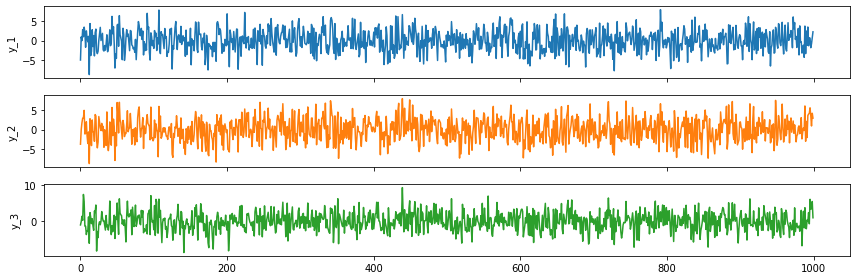

In [20]:
dfplot(u_df, figsize=(12,4), y_tick_pos='left')

##### Check the mean and covariance of our sample

In [21]:
u_df.mean().round(2)

y_1   -0.00
y_2   -0.01
y_3    0.06
dtype: float64

In [22]:
u_df.cov().round(2)

y_1   y_2   y_3
y_1  8.0  6.00  3.00
y_2  6.0  8.91  5.02
y_3  3.0  5.02  6.89

We see that the mean and covariance of our sample is close to $\mu = 
\begin{bmatrix}
    0 \\
    0 \\
    0 \\
\end{bmatrix}
$
and
$
\Sigma = 
\begin{bmatrix}
    8 & 6 & 3 \\
    6 & 9 & 5 \\
    3 & 5 & 7 \\
\end{bmatrix}
$ defined above.

##### Generate the time series data

In [23]:
# define a Tx3 zero matrix to contain the synthetic data 
y = np.zeros(shape=(T, 3))

# first element in the time series is just the intercept term + vector white noise
y[0] = a_0 + u[0] 

# derive the rest of the time series, this time adding the lag terms
for j in range(1, T):
    y[j] = a_0 + np.dot(A_1, y[j-1])  + u[j]

# convert to dataframe to facilitate analysis
y = pd.DataFrame(y, columns = ["y_1", "y_2", "y_3"])
y.head()

y_1       y_2        y_3
0 -3.055008 -3.709640   2.049945
1  1.411475 -0.087179   2.838123
2  2.685187  2.744005   5.264798
3  6.157144  5.030986   5.438828
4  6.038727  5.742108  13.090483

Let's take a look at the generated data

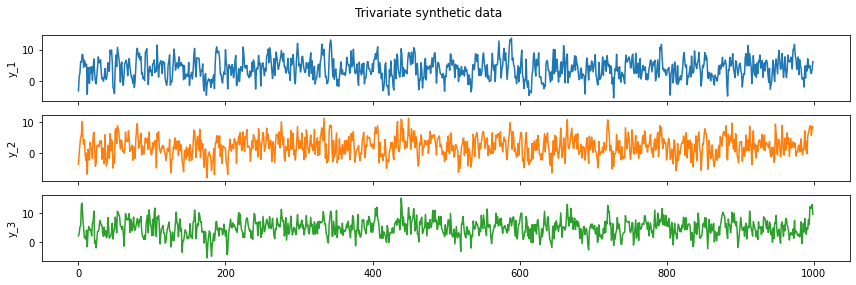

In [24]:
dfplot(y, figsize=(12,4), y_tick_pos='left', title='Trivariate synthetic data')

Let's define another plotting utiliy for analyzing a time series

In [25]:
def tsplot(data, col, suptitle=None, lags=None, figsize=(12,4)):
    """ Perform a quick EDA of a dataframe column for time series analysis
        Plots the data, its histogram, and ACF, and PACF
    """
    fig = plt.figure(figsize=figsize)   
    if suptitle:
        fig.suptitle(suptitle, fontsize=14)
    layout = (2,2)
    data_ax = plt.subplot2grid(layout, (0,0))
    hist_ax = plt.subplot2grid(layout, (0,1))
    acf_ax = plt.subplot2grid(layout, (1,0))
    pacf_ax = plt.subplot2grid(layout, (1,1))
    
    data[col].plot(ax=data_ax)
    data_ax.set_title(col)
    data[col].plot(ax=hist_ax, kind='hist', bins=20)  
    hist_ax.set_title('Histogram')
    plot_acf(data[col], lags=lags, ax=acf_ax)
    plot_pacf(data[col], lags=lags, ax=pacf_ax)
    plt.tight_layout()
    plt.show()

Now let's analyze take a look the plots of $y_1$ to $y_3$

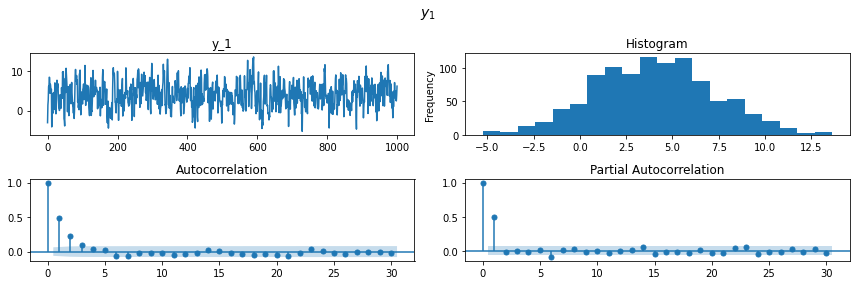

In [26]:
tsplot(y, 'y_1', '$y_1$')

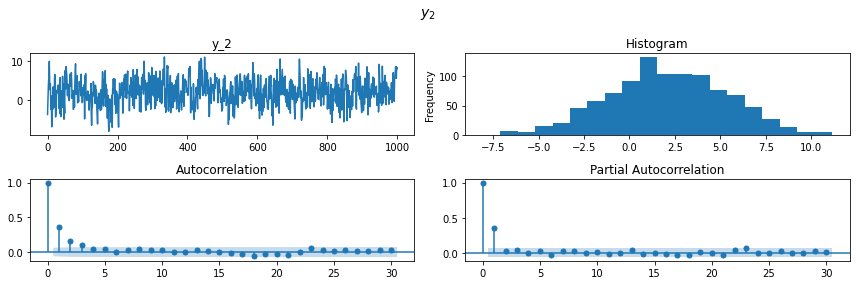

In [27]:
tsplot(y, 'y_2', '$y_2$')

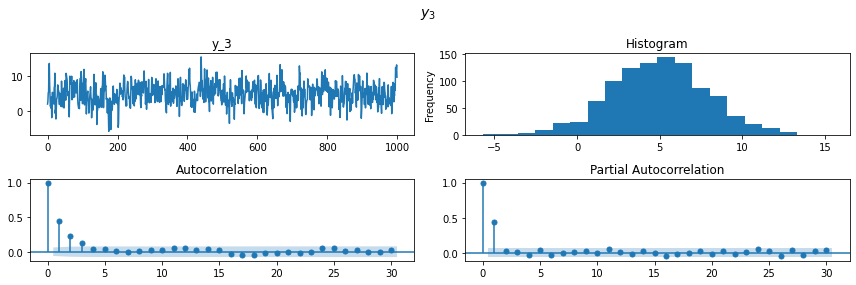

In [28]:
tsplot(y, 'y_3', '$y_3$')

We can observe that all 3 time series are stationary.

##### Check for unit roots using Sympy  ADF and KPSS

Checking for stationarity by finding the roots of the reverse characteristic polynomial by manual solving or even by 
using Sympy will become more complicated when the process increases the number of variables or the number of lags.
The procedures above were only provided to provide a solid grounding on the idea of stationarity. In practice, two tests are used for checking stationarity: the Augmented Dickey-Fuller Test (ADF) and the  Kwiatkowski–Phillips–Schmidt–Shin Test (KPSS).
Let's define two functions for running these tests so that we could check the stationarity of a time series.

In [29]:
def adf_test(data):
    """ Runs the Augmented Dickey-Fuller Test 
            h0: Presence of unit root
            h1: time series is stationary
        Parameter
            data in a dataframe 
        Return 
            a dataframe with the test statistic, p-value and critical values for 1, 5 and 10% levels
    """    
    test_stat, p_val = [], []
    cv_1pct, cv_5pct, cv_10pct = [], [], []
    for c in data.columns: 
        adf_res = adfuller(data[c].dropna())
        test_stat.append(adf_res[0])
        p_val.append(adf_res[1])
        cv_1pct.append(adf_res[4]['1%'])
        cv_5pct.append(adf_res[4]['5%'])
        cv_10pct.append(adf_res[4]['10%'])
    return pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data.columns).T

In [30]:
def kpss_test(data):
    """ Runs the Kwiatkowski–Phillips–Schmidt–Shin Test 
            h0: An observable time series is stationary around a deterministic trend (i.e. trend-stationary) 
            h1: Presence of a unit root
        Parameter
            data in a dataframe 
        Return 
            a dataframe with the test statistic, p-value and critical values for 1, 2.5, 5 and 10% levels
    """      
    test_stat, p_val = [], []
    cv_1pct, cv_2p5pct, cv_5pct, cv_10pct = [], [], [], []
    for c in data.columns: 
        kpss_res = kpss(data[c].dropna(), regression='ct')
        test_stat.append(kpss_res[0])
        p_val.append(kpss_res[1])
        cv_1pct.append(kpss_res[3]['1%'])
        cv_2p5pct.append(kpss_res[3]['1%'])
        cv_5pct.append(kpss_res[3]['5%'])
        cv_10pct.append(kpss_res[3]['10%'])
    return pd.DataFrame({'Test statistic': test_stat, 
                               'p-value': p_val, 
                               'Critical value - 1%': cv_1pct,
                               'Critical value - 2.5%': cv_2p5pct,
                               'Critical value - 5%': cv_5pct,
                               'Critical value - 10%': cv_10pct}, 
                             index=data.columns).T


Let's run both tests for our synthetic data

In [31]:
adf_test(y).round(2)

y_1    y_2    y_3
Test statistic       -18.57 -21.74 -19.59
p-value                0.00   0.00   0.00
Critical value - 1%   -3.44  -3.44  -3.44
Critical value - 5%   -2.86  -2.86  -2.86
Critical value - 10%  -2.57  -2.57  -2.57

Using ADF, we reject the null hypothesis of the presence of a unit root in all 3 time series, and thus conclude that they are stationary.

In [32]:
kpss_test(y).round(2)

y_1   y_2   y_3
Test statistic         0.06  0.08  0.07
p-value                0.10  0.10  0.10
Critical value - 1%    0.22  0.22  0.22
Critical value - 2.5%  0.22  0.22  0.22
Critical value - 5%    0.15  0.15  0.15
Critical value - 10%   0.12  0.12  0.12

Using KPSS, we fail to reject the null hypothesis trend-stationary for all 3 time series and conclude that they are stationary.

#### Create a  VAR Model

In [35]:
model = VAR(y)

We can select the VAR order $p$ using `select_order` method of the VAR model.

In [36]:
model_orders = model.select_order(maxlags=5)

Display the information criteria (best values are indicated with an asterisk.)

In [37]:
model_orders.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

All information criteria suggest an order of 1. Let's use that to fit the model.

In [38]:
model_results = model.fit(1)

In [39]:
model_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Jan, 2022
Time:                     00:57:42
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    5.02695
Nobs:                     999.000    HQIC:                   4.99041
Log likelihood:          -6722.08    FPE:                    143.741
AIC:                      4.96801    Det(Omega_mle):         142.028
--------------------------------------------------------------------
Results for equation y_1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          2.336114         0.217514           10.740           0.000
L1.y_1         0.468847         0.038031           12.328           0.000
L1.y_2         0.069832         0.048399            1.443           0.149
L1.y_3        -0

##### Checking the parameters of the model

Let's just check the parameters of the model

In [40]:
model_results.params.round(2)

y_1   y_2   y_3
const   2.34  0.32  3.25
L1.y_1  0.47  0.03 -0.04
L1.y_2  0.07  0.17  0.24
L1.y_3 -0.07  0.26  0.28

Let's also chek the mean and covariance matrix of the residuals.

In [41]:
model_results.resid.mean().round(4)

y_1    0.0
y_2    0.0
y_3    0.0
dtype: float64

In [42]:
model_results.resid.cov().round(2)

y_1   y_2   y_3
y_1  7.96  5.96  2.98
y_2  5.96  8.87  5.00
y_3  2.98  5.00  6.88

From these, we can say that the resulting model is the following:

$$
y_t = 
\begin{bmatrix}
    2.34 \\
    0.32 \\
    3.25 \\
\end{bmatrix}
+
\begin{bmatrix}
    0.47 & 0.03 & -0.04 \\
    0.07 & 0.17 & 0.24 \\
    -0.07   & 0.26 & 0.28 \\
\end{bmatrix}
y_{t-1}
+ u_t,\quad
\mu_{u} =
\begin{bmatrix}
    0 \\
    0 \\
    0 \\
\end{bmatrix}, \;
\Sigma_{u} = 
\begin{bmatrix}
    7.96 & 5.96 & 2.98 \\
    5.96 & 8.87 & 5.00 \\
    2.98 & 5.00 & 6.88 \\
\end{bmatrix}
$$

As we can see, this is very close to the original process we described in Ex.2.1

$$
y_t = 
\begin{bmatrix}
    2 \\
    0 \\
    3 \\
\end{bmatrix}
+
\begin{bmatrix}
    0.5 & 0 & 0 \\
    0.1 & 0.1 & 0.3 \\
    0   & 0.2 & 0.3 \\
\end{bmatrix}
y_{t-1}
+ u_t,\quad
u_t \sim \mathcal{N}
\left(
\mu = 
\begin{bmatrix}
    0 \\
    0 \\
    0 \\
\end{bmatrix}
, \;
\Sigma = 
\begin{bmatrix}
    8 & 6 & 3 \\
    6 & 9 & 5 \\
    3 & 5 & 7 \\
\end{bmatrix}
\right)
$$

##### Roots of the model

We can also inspect the roots of the reverse characteristic polunomial of the model

In [43]:
model_results.roots

array([-21.41383646,   2.14145279,   2.03146044])

All the roots are outside the unit circle, which means that this  VAR  model is stationary.

### Example 2.2: VAR (2) on Bivariate Synthetic Timeseries Data

In this example, we will once again investigate on unit roots, but we will also take a look at model diagnostics at the end of the subsection.

Consider the bivariate process described below (partly derived from in Eq.2.1.15 of [1]):

$$
y_t = 
\begin{bmatrix}
    2 \\
    0 \\
\end{bmatrix}
+
\begin{bmatrix}
    0.5 & 0.1  \\
    0.4 & 0.5  \\
\end{bmatrix}
y_{t-1}
+
\begin{bmatrix}
    0    & 0  \\
    0.25 & 0  \\
\end{bmatrix}
y_{t-2}
+ u_t,\quad
u_t \sim \mathcal{N}
\left(
\mu = 
\begin{bmatrix}
    0 \\
    0 \\
\end{bmatrix}
, \;
\Sigma = 
\begin{bmatrix}
    7 & 5 \\
    5 & 9 \\
\end{bmatrix}
\right)
\label{ex:2.2} \tag{Ex.2.2}
$$
<br>
This is a VAR(2) process with known parameters:
$a_0 = 
\begin{bmatrix}
    2 \\
    0 \\
\end{bmatrix},\;
$
$
A_1=
\begin{bmatrix}
    0.5 & 0.1  \\
    0.4 & 0.5  \\
\end{bmatrix},\;
$
and
$
A_2=
\begin{bmatrix}
    0    & 0  \\
    0.25 & 0  \\
\end{bmatrix}
$
.<br><br>

#### Generating the synthetic time series data

As in the previous example, we will generate synthetic data based on these parameters, then create a VAR model based on the synthetic data and examine if they VAR parameters are close to the known parameters we have set above.

In [44]:
T = 1000
a_0 = np.array([2, 0])
A_1 = np.array(
    [[0.5, 0.1], 
     [0.4, 0.5]]
    )
A_2 = np.array(
    [[0,    0], 
     [0.25, 0]]
    )
mu = [0, 0]
sigma = np.array(
    [[5, 3],
     [3, 9]])

#### Check for Stationarity using ADF

We can go straight to ADF to test the stationarity of the series.

In [45]:
adf_test(y).round(2)

y_1    y_2    y_3
Test statistic       -18.57 -21.74 -19.59
p-value                0.00   0.00   0.00
Critical value - 1%   -3.44  -3.44  -3.44
Critical value - 5%   -2.86  -2.86  -2.86
Critical value - 10%  -2.57  -2.57  -2.57

The ADF test suggests that the series is stationary. We can verify this using Sympy by actually computing for the roots.

##### Check for unit roots using Sympy

Let's get the reverse characteristic polynomial

In [46]:
z = sp.Symbol('z')
# produce matrix of the reverse characteristic polynomial(sp.eye(2) is the 2x2 identity matrix) 
rcp_matrix = sp.eye(2) - sp.Matrix(A_1) * z - sp.Matrix(A_2) * z**2 

# get the determinant to produce the reverce characteric polynomial
rcp = rcp_matrix.det()
rcp

-0.025*z**3 + 0.21*z**2 - 1.0*z + 1

In [48]:
# get the roots
rcp_roots = sp.roots(rcp, z)

# get the modulus of the roots
for z in rcp_roots:
    print("z:", round(z, 2), "; |z|= ", round(sp.Abs(z), 2))

z: 1.30 ; |z|=  1.30
z: 3.55 - 4.26*I ; |z|=  5.55
z: 3.55 + 4.26*I ; |z|=  5.55


The modulus of the roots are all greater than 1, suggesting that the series is stationary.

After verifying the stationarity of the process, we'll proceed to producing the synthetic data.

##### Generate and plot $u$, the vector white noise

In [49]:
np.random.seed(2872)
u = np.random.multivariate_normal(mu, sigma, size=T)
u_df= pd.DataFrame(u, columns = ["y_1", "y_2"])
u_df.head()

y_1       y_2
0  0.190387  5.012826
1 -0.525635 -0.518022
2  1.035124  0.535605
3 -1.522634 -0.814865
4 -2.222838 -0.713147

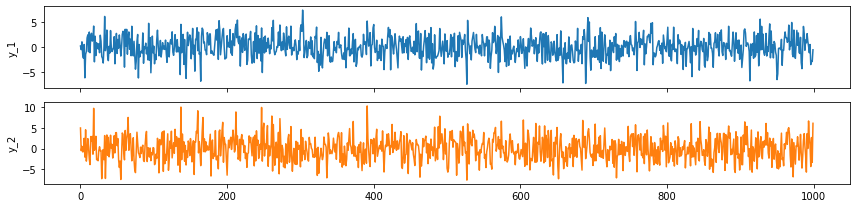

In [50]:
dfplot(u_df, figsize=(12,3), y_tick_pos='left')

##### Check the mean and covariance of our sample

In [51]:
u_df.mean().round(2)

y_1    0.01
y_2    0.01
dtype: float64

In [52]:
u_df.cov().round(2)

y_1   y_2
y_1  5.06  3.03
y_2  3.03  8.99

We see that the mean and covariance of our sample is close to $\mu = 
\begin{bmatrix}
    0 \\
    0 \\
\end{bmatrix} \;
$
and 
$
\Sigma = 
\begin{bmatrix}
    5 & 3 \\
    3 & 8 \\
\end{bmatrix}
$ defined above.

##### Generate the time series data

In [53]:
# define a Tx2 zero matrix to contain the synthetic data 
y = np.zeros(shape=(T, 2))

# first element in the time series is just the intercept term + vector white noise
y[0] = a_0 + u[0] 

# second element now also includes the dot product of first lag coefficients and values of the first element
y[1] = a_0 + np.dot(A_1, y[0])  + u[1]

# derive the rest of the time series, this time adding the 2 lag terms
for j in range(2, T):
    y[j] = a_0 + np.dot(A_1, y[j-1]) + np.dot(A_2, y[j-2])  + u[j]

# convert to dataframe to facilitate analysis
y = pd.DataFrame(y, columns = ["y_1", "y_2"])
y.head()

y_1       y_2
0  2.190387  5.012826
1  3.070841  2.864546
2  4.856999  3.743811
3  3.280247  3.767550
4  1.794041  3.696976

Let's take a look at the generated data

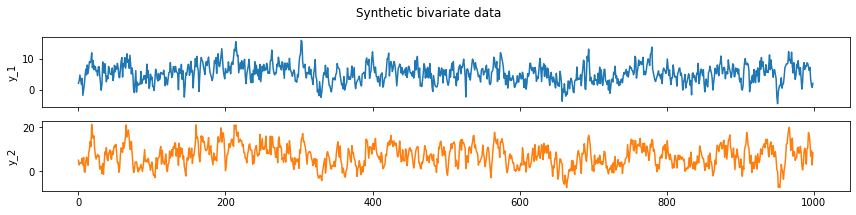

In [54]:
dfplot(y, figsize=(12,3), y_tick_pos='left', title='Synthetic bivariate data')

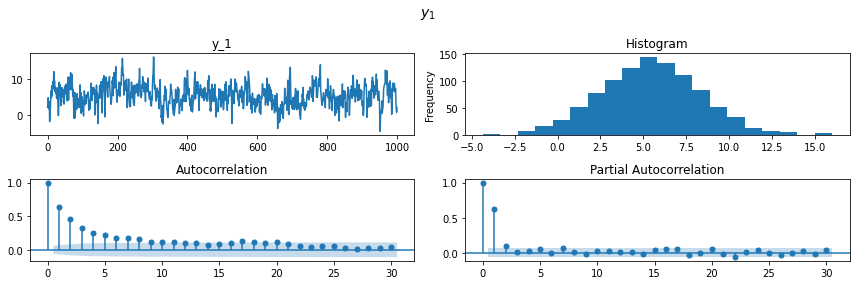

In [55]:
tsplot(y, 'y_1', '$y_1$')

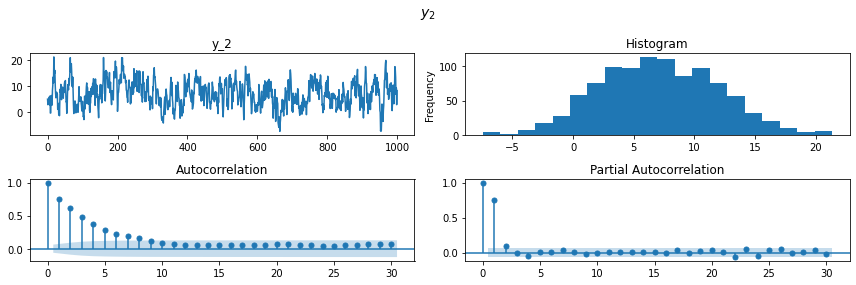

In [56]:
tsplot(y, 'y_2', '$y_2$')

We see that the time series look stationary. Furthermore, we observe a strong partial autocorrelation at lag 1.

#### Create a  VAR Model

In [57]:
model = VAR(y)

We can select the VAR order $p$ using `select_order` method of the VAR model.

In [58]:
model_orders = model.select_order(maxlags=10)

Display the information criteria (best values are indicated with an asterisk.)

In [59]:
model_orders.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

All information criteria suggest an order of 2. 

We can plot the information criteria values for the lags for better inspection.

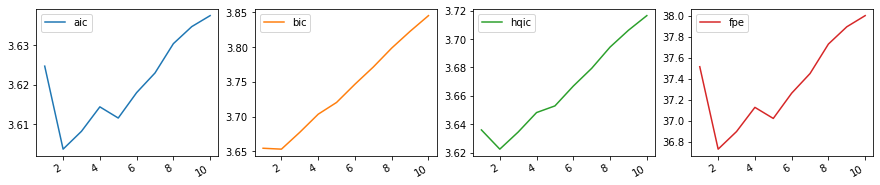

In [60]:
pd.DataFrame(model_orders.ics)[1:].plot(subplots=True, layout=(1,4), figsize=(15,3));

Let's go ahead and use 2 to fit the model

In [61]:
model_results = model.fit(2)

We can also inspect the roots of the reverse characteristic polunomial of the model

In [62]:
np.abs(model_results.roots)

array([9.02310218, 9.02310218, 3.11343141, 1.27911902])

All the roots are outside the unit circle, which means that this  VAR  model is stationary.

Let's inspect the model details. 

In [63]:
model_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Jan, 2022
Time:                     00:58:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    3.65401
Nobs:                     998.000    HQIC:                   3.62354
Log likelihood:          -4621.02    FPE:                    36.7763
AIC:                      3.60485    Det(Omega_mle):         36.4106
--------------------------------------------------------------------
Results for equation y_1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          1.865397         0.163749           11.392           0.000
L1.y_1         0.500119         0.035541           14.071           0.000
L1.y_2         0.098173         0.026405            3.718           0.000
L2.y_1         0

Let's focus on the parameters of the model

In [64]:
model_results.params.round(2)

y_1   y_2
const   1.87  0.05
L1.y_1  0.50  0.42
L1.y_2  0.10  0.47
L2.y_1  0.04  0.21
L2.y_2 -0.01  0.04

Let's also check the mean and covariance matrix of the residuals.

In [65]:
model_results.resid.mean().round(4)

y_1   -0.0
y_2   -0.0
dtype: float64

In [66]:
model_results.resid.cov().round(2)

y_1   y_2
y_1  5.06  3.04
y_2  3.04  8.96

From these, we can say that the resulting VAR model is the following:

$$
y_t = 
\begin{bmatrix}
    1.87 \\
    0.05 \\
\end{bmatrix}
+
\begin{bmatrix}
    0.50 & 0.10  \\
    0.42 & 0.47  \\
\end{bmatrix}
y_{t-1}
+
\begin{bmatrix}
    0.04  & -0.01  \\
   0.21   & 0.04  \\
\end{bmatrix}
y_{t-2}
+ u_t,\quad
\mu_{u} = 
\begin{bmatrix}
    0 \\
    0 \\
\end{bmatrix}
, \;
\Sigma_{u} = 
\begin{bmatrix}
    5.06 & 3.04 \\
    3.04 & 8.96 \\    
\end{bmatrix}
$$

As we can see, this is very close to the original process we described in Ex.2.2:

$$
y_t = 
\begin{bmatrix}
    2 \\
    0 \\
\end{bmatrix}
+
\begin{bmatrix}
    0.5 & 0.1  \\
    0.4 & 0.5  \\
\end{bmatrix}
y_{t-1}
+
\begin{bmatrix}
    0    & 0  \\
    0.25 & 0  \\
\end{bmatrix}
y_{t-2}
+ u_t,\quad
u_t \sim \mathcal{N}
\left(
\mu = 
\begin{bmatrix}
    0 \\
    0 \\
\end{bmatrix}
, \;
\Sigma = 
\begin{bmatrix}
    5 & 3 \\
    3 & 8 \\
\end{bmatrix}
\right)
$$

#### Model Diagnostics using Residual plots

One way of doing diagnostics is by making a plot of the residuals and checking if they exhibit white noise behavior. The residuals could be obtained from the `resid` attribute of the fitted VAR model.

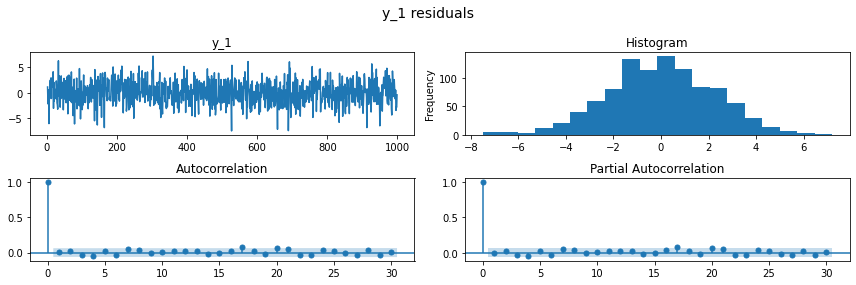

In [69]:
tsplot(model_results.resid, col='y_1', suptitle='y_1 residuals')

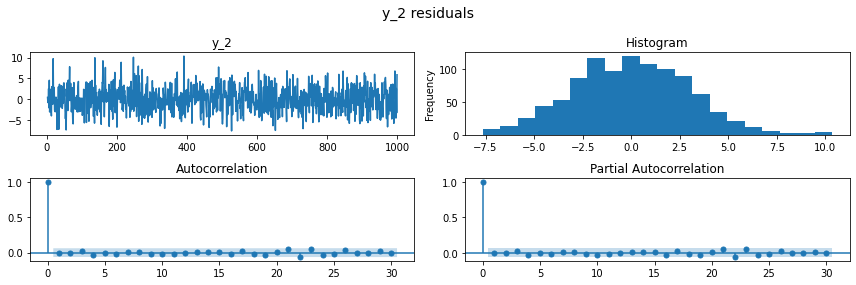

In [70]:
tsplot(model_results.resid, col='y_2', suptitle='y_2 residuals')

The plots show that the time series has the characteristics of white noise. We thus conclude that the model is viable.

## Example 3: Air Quality Data (CO, NO2 and RH)

From synthetic data, we now consider a real world data:  the Air Quality Dataset from 1 October 2014. For this example, we will follow the steps outlined in the section on Steps in Building a VAR Model.

### 1. Select the variables to include in the model
For this study, we will work on the carbon monoxide, nitrous dioxide and relative humidity variables.

### 2. Do an Exploratory Data Analysis of the variables

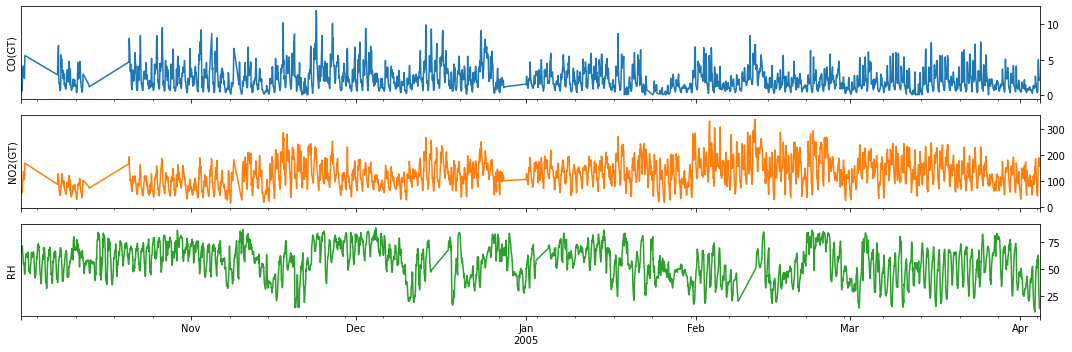

In [71]:
cols = ['CO(GT)', 'NO2(GT)', 'RH']
data_df = aq_df.loc[aq_df.index>'2004-10-01', cols]
dfplot(data_df, figsize=(15,5))

To find out whether the multivariate approach is better than treating the signals separately as univariate time series, we examine the relationship between the variables using CCF. 

First, let's define a utility function for plotting the CCF between two columns in a dataframe.

In [72]:
def ccf_plot(dataframe, col1, col2, figsize=(15,4), fontsize=10):
    """ Plot cross correlation between two columns in a dataframe
    """
    ccf_y1_y2 = ccf(dataframe[col1], dataframe[col2], unbiased=False)
    ccf_y2_y1 = ccf(dataframe[col2], dataframe[col1], unbiased=False)

    fig, ax = plt.subplots(2, figsize=(15, 4), sharex=True, sharey=True)
    s = r'$\rho(h)$' 
    fig.suptitle(f"Cross Correlation Plots {s}", size=fontsize+4)
    d=1
    ax[0].stem(np.arange(len(dataframe))[::d], ccf_y1_y2[::d], linefmt='C1-', markerfmt='C1o')
    ax[1].stem(np.arange(len(dataframe))[::d], ccf_y2_y1[::d], linefmt='C1-', markerfmt='C1o')
    ax[-1].set_ylim(-1, 1)
    ax[0].set_xlim(0, 100)
    ax[-1].set_xlabel('lag $h$', fontsize=fontsize+2)
    ax[0].set_ylabel(f'{col1}, {col2}', fontsize=fontsize)
    ax[0].set_ylabel(f'{col1}, {col2}', fontsize=fontsize)
    ax[1].set_ylabel(f'{col2}, {col1}', fontsize=fontsize)
    plt.tight_layout()
    plt.show()

The sample below shows the CCF for the last 100 data points of the Air quality data for CO, NO2 and RH. 

In [73]:
sample_df = data_df.iloc[-100:]

*CO and NO2*

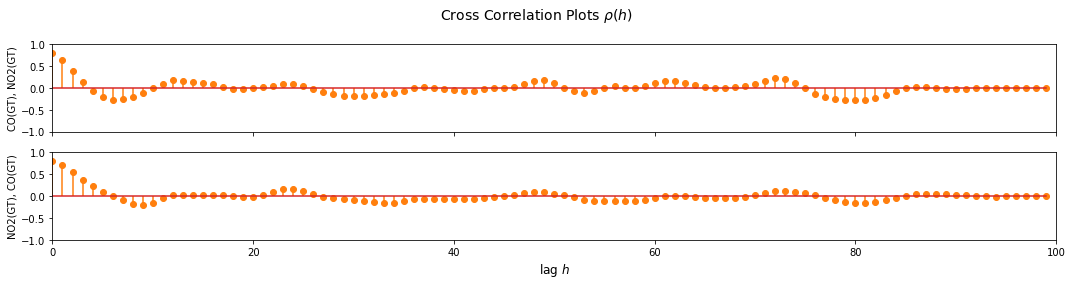

In [74]:
ccf_plot(sample_df, 'CO(GT)', 'NO2(GT)')

*CO and RH*

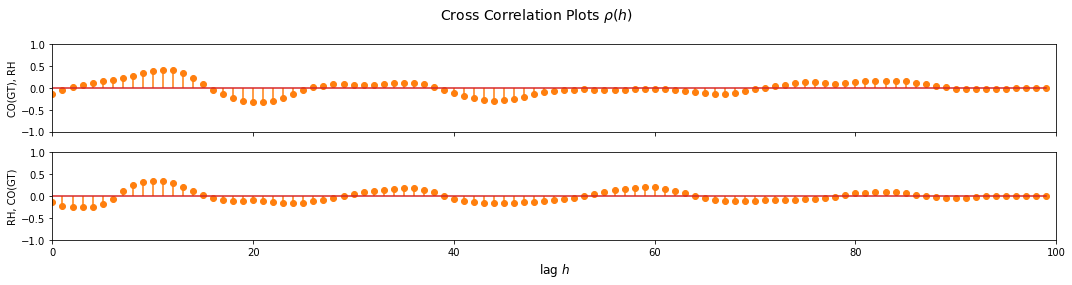

In [75]:
ccf_plot(sample_df, 'CO(GT)', 'RH')

*RH and NO2*

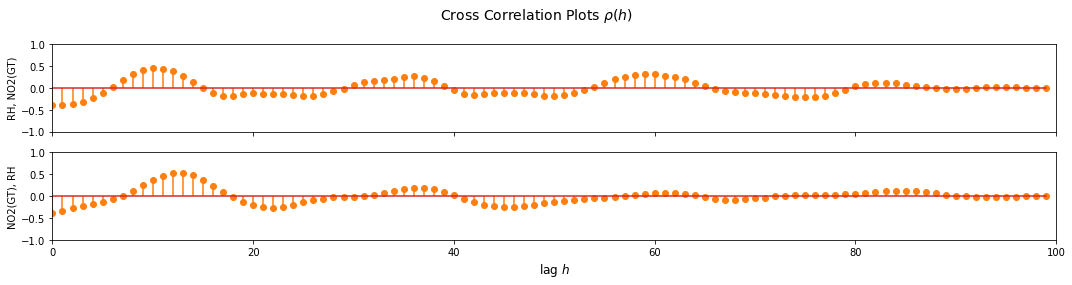

In [76]:
ccf_plot(sample_df, 'RH', 'NO2(GT)')

**Observation/s**: 

As shown in the plot above, we can see that there's a relationship between:
* CO and some lagged values of RH and NO2
* NO2 and some lagged values of RH and CO
* RH and some lagged values of CO and NO2

This shows that we can benefit from the multivariate approach, so we proceed with building the VAR model. 

### 3. Check for stationarity

To check for stationarity, we use the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test and the Augmented Dickey-Fuller (ADF) test. We have previously created utility functions for these tests. For the data to be suitable for VAR modelling, we need each of the variables in the multivariate time series to be stationary. In both tests, we need the test statistic to be less than the critical values to say that a time series (a variable) to be stationary. 

#### Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
Recall: Null hypothesis is that an observable time series is stationary around a deterministic trend (i.e. trend-stationary) against the alternative of a unit root.

In [77]:
kpss_test(data_df).round(4)

CO(GT)  NO2(GT)      RH
Test statistic         0.0702   0.3239  0.1149
p-value                0.1000   0.0100  0.1000
Critical value - 1%    0.2160   0.2160  0.2160
Critical value - 2.5%  0.2160   0.2160  0.2160
Critical value - 5%    0.1460   0.1460  0.1460
Critical value - 10%   0.1190   0.1190  0.1190

***Observation***: 

From the KPSS test, CO and RH are stationary. 


#### Augmented Dickey-Fuller (ADF) test
Recall: Null hypothesis is that a unit root is present in a time series sample against the alternative that the time series is stationary.

In [78]:
adf_test(data_df).round(4)

CO(GT)  NO2(GT)      RH
Test statistic       -7.0195  -6.7695 -6.8484
p-value               0.0000   0.0000  0.0000
Critical value - 1%  -3.4318  -3.4318 -3.4318
Critical value - 5%  -2.8622  -2.8622 -2.8622
Critical value - 10% -2.5671  -2.5671 -2.5671

***Observation***:  

From the ADF test, CO, NO2 and RH are stationary. 


### 4. For Unstationary Data: Perform data transformation and decide whether to proceed modeling with VAR

Since all variables in the multivariate time series are stationary, this step could be skipped.

### 5. Create and fit a VAR model

We now proceed with creating and fitting a VAR model.

#### 5a. Split data into train and test sets

We use the dataset from 01 October 2014 to predict the last 24 points (24 hrs/1 day) in the dataset.

In [79]:
forecast_length = 24 
train_df, test_df = data_df.iloc[:-forecast_length], data_df.iloc[-forecast_length:]
test_df = test_df.filter(test_df.columns[~test_df.columns.str.contains('-d')])

In [80]:
train_df.reset_index().to_csv('../data/AirQualityUCI/train_data.csv')
test_df.reset_index().to_csv('../data/AirQualityUCI/test_data.csv')

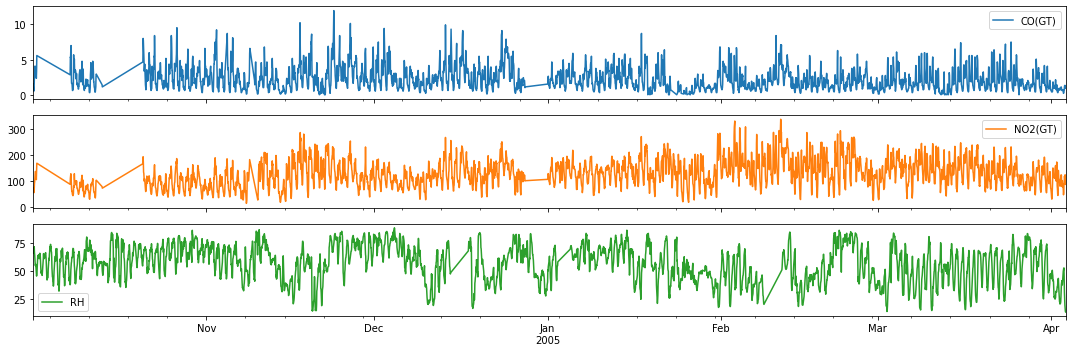

In [81]:
fig,ax = plt.subplots(3, figsize=(15, 5), sharex=True)
train_df.plot(ax=ax, subplots=True)
plt.xlabel('')
plt.tight_layout()
plt.show()

#### 5b. Select order *p*

In [82]:
model = VAR(train_df) 

We can use the models `select_order` method to compute the various information criteria: the AIC, BIC, FPE, and HQIC.

In [83]:
model_orders = model.select_order(maxlags=40)
model_orders.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

We can make a plot of the values for better inspection.

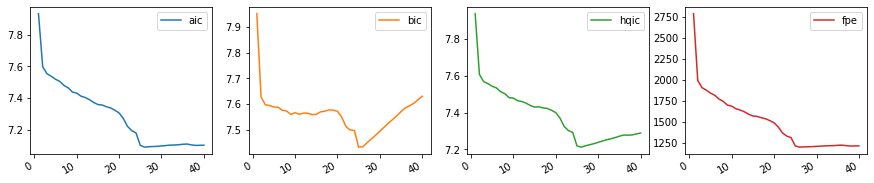

In [84]:
pd.DataFrame(model_orders.ics)[1:].plot(subplots=True, layout=(1,4), figsize=(15,3));

***Observations***: 

We find BIC and HQIC to be lowest at  $p=26$.  We also observe an elbow in the plots for AIC, and FPE, so we choose the number of lags to be 26. 

#### 5c. Fit VAR model with chosen order

In [85]:
%%time
var_model = model.fit(26)
var_model.summary()

Wall time: 151 ms


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Jan, 2022
Time:                     01:01:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    7.42717
Nobs:                     4404.00    HQIC:                   7.20458
Log likelihood:          -34107.4    FPE:                    1191.88
AIC:                      7.08328    Det(Omega_mle):         1129.97
--------------------------------------------------------------------
Results for equation CO(GT)
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.241332         0.069966            3.449           0.001
L1.CO(GT)           0.961418         0.019229           49.999           0.000
L1.NO2(GT)          0.001992         0.000713            2.794     

### 6. Run Model Diagnostics

First we create plots to see if the residuals look like white noise.

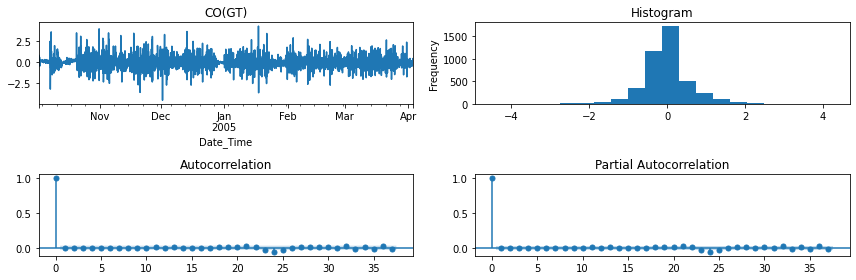

In [86]:
tsplot(var_model.resid, 'CO(GT)')

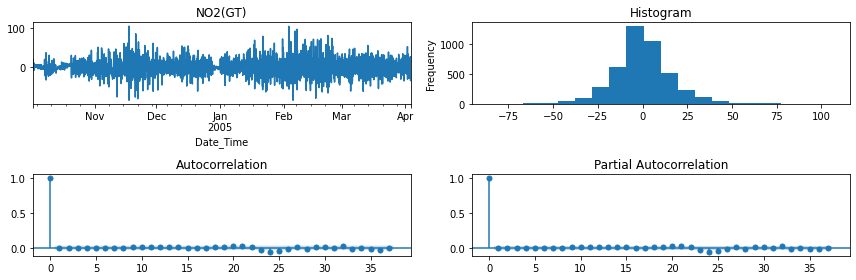

In [87]:
tsplot(var_model.resid, 'NO2(GT)')

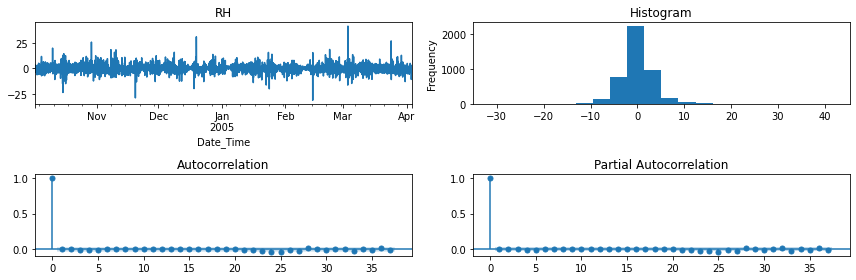

In [88]:
tsplot(var_model.resid, 'RH')

The graphs of the residuals give us confidence that the model is sound. 

### 7. Generate forecast

In [90]:
forecast_var = pd.DataFrame(var_model.forecast(train_df.values, 
                                              steps=forecast_length), 
                           columns=train_df.columns, 
                           index=test_df.index)
forecast_var = forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns})

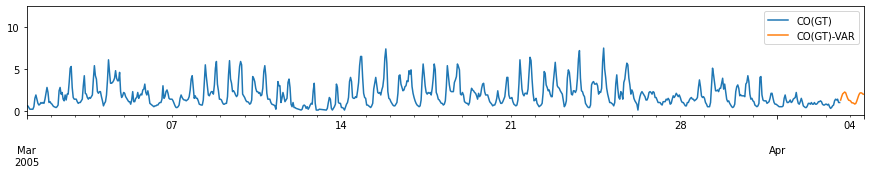

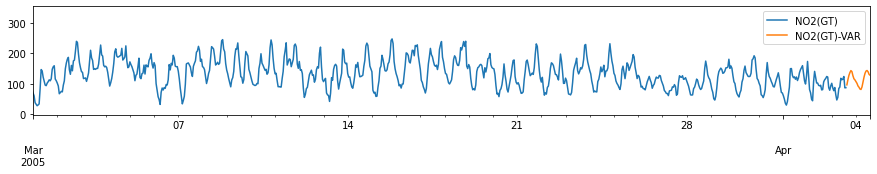

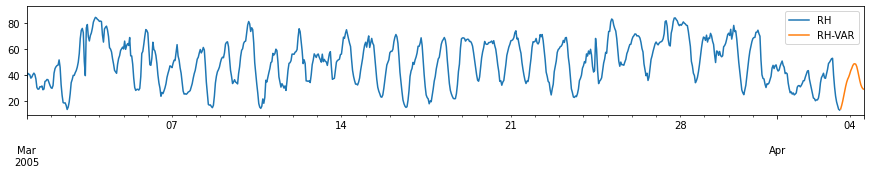

In [91]:
for c in train_df.columns:
    fig, ax = plt.subplots(figsize=[15, 2])
    pd.concat([train_df[[c]], forecast_var[[c+'-VAR']]], axis=1).plot(ax=ax)
    plt.xlim(left=pd.to_datetime('2005-03-01'))
    plt.xlabel('')
    plt.show()

### 8. Evaluate forecast

For the performance evaluation of the forecast, we will compare its error metrics with those of the ARIMA model.
When using ARIMA, we treat each variable as a univariate time series, and we perform the forecasting for each variable: 1 for CO, 1 for NO2, and 1 for RH

In [92]:
# For model order selection, refer to Chapter 1
selected_order = {'CO(GT)': [(0, 1, 0)],
                  'NO2(GT)': [(0, 1, 0)],
                  'RH': [(3, 1, 1)]}

In [93]:
%%time
forecast_arima = {}
for c in cols:
    forecast_arima[c+'-ARIMA'] = utils.forecast_arima(train_df[c].values, 
                                                      test_df[c].values, 
                                                      order=selected_order[c][0])
forecast_arima = pd.DataFrame(forecast_arima, index=forecast_var.index)
forecast_arima.head()

Wall time: 3.18 s


CO(GT)-ARIMA  NO2(GT)-ARIMA   RH-ARIMA
Date_Time                                                  
2005-04-03 15:00:00      0.999865      87.002935  14.502895
2005-04-03 16:00:00      0.999729      87.005870  16.743242
2005-04-03 17:00:00      0.999594      87.008806  19.253419
2005-04-03 18:00:00      0.999458      87.011741  21.715716
2005-04-03 19:00:00      0.999323      87.014676  23.974493

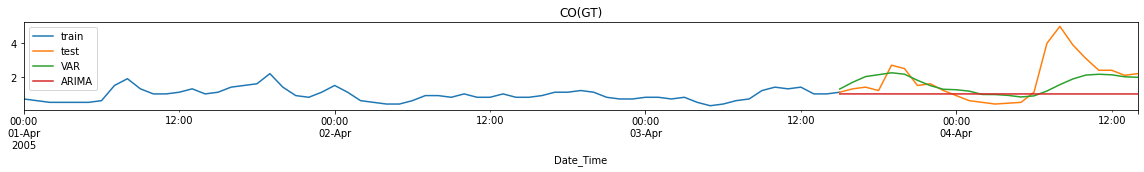

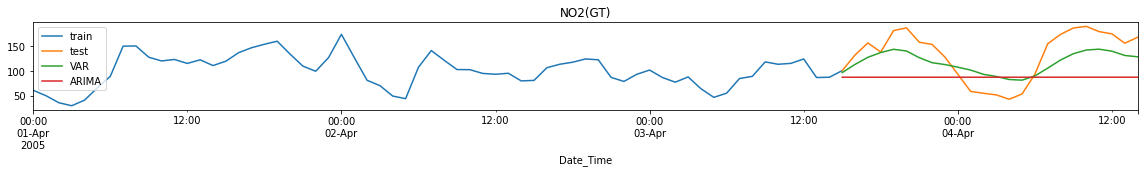

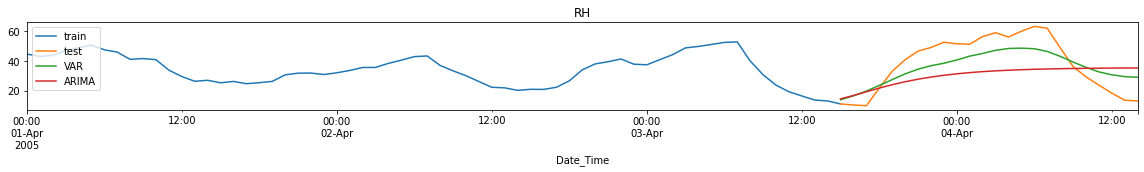

In [94]:
forecasts = pd.concat([forecast_arima, forecast_var], axis=1)
for c in cols:
    fig, ax = utils.plot_forecasts_static(train_df=train_df,
                                          test_df=test_df, 
                                          forecast_df=forecasts, 
                                          column_name=c,
                                          min_train_date='2005-04-01', 
                                          suffix=['-VAR', '-ARIMA'],
                                          title=c)


Let's look at the performance metrics.

In [95]:
pd.concat([utils.test_performance_metrics(test_df, forecast_var, suffix='-VAR'),
           utils.test_performance_metrics(test_df, forecast_arima, suffix='-ARIMA')], axis=1)

CO(GT)-VAR  NO2(GT)-VAR      RH-VAR  CO(GT)-ARIMA  NO2(GT)-ARIMA  \
MAE     0.685005    31.687612    9.748883      1.057097      59.283376   
MSE     1.180781  1227.046604  111.996306      2.163021    4404.904459   
MAPE   43.508500    29.811066   35.565987     56.960616      46.190671   

        RH-ARIMA  
MAE    16.239010  
MSE   333.621776  
MAPE   51.199044

***Observations***:

- MAE: VAR forecasts have lower errors than ARIMA forecasts for CO and NO2 but not in RH.
- MSE: VAR forecasts have lower errors for all variables (CO, NO2 and RH).
- MAPE: VAR forecasts have lower errors for all variables (CO, NO2 and RH). 
- Training time is significantly reduced when using VAR compared to ARIMA (<0.1s run time for VAR while ~20s for ARIMA)

## Structural VAR Analysis

In addition to forecasting, VAR models are also used for structural inference and policy analysis. In macroeconomics, this structural analysis has been extensively employed to investigate the transmission mechanisms of macroeconomic shocks (e.g., monetary shocks, financial shocks) and test economic theories. There are particular assumptions imposed about the causal structure of the dataset, and the resulting causal impacts of unexpected shocks (also called innovations or perturbations) to a specific variable on the different variables in the model are summarized. In this section, we cover two of the common methods in summarizing the effects of these causal impacts: (1) impulse response functions, and (2): forecast error variance decompositions. 

### Impulse Response Function (IRF)

- Coefficients of the VAR models are often difficult to interpret so practitioners often estimate the impulse response function. 
- IRFs trace out the time path of the effects of an exogenous shock to one (or more) of the endogenous variables on some or all of the other variables in a VAR system.
- IRF traces out the response of the dependent variable of the VAR system to shocks (also called innovations or impulses) in the error terms. 

#### IRF in the VAR system for Air Quality 

Let $y_{1,t}$, $y_{2,t}$ and $y_{3,t}$ be the time series corresponding to CO signal, NO2 signal, and RH signal, respectively. Consider the moving average representation of the system shown below:

Let 
<img src="irf_eq.png" style="width: 350px;"/>

Suppose $u_1$ in the first equation increases by a value of one standard deviation. 
- This shock will change $y_1$ in the current as well as the future periods.
- This shock will also have an impact on $y_2$ and $y_3$. 

Suppose $u_2$ in the second equation increases by a value of one standard deviation. 
- This shock will change $y_2$ in the current as well as the future periods.
- This shock will also have an impact on $y_1$ and $y_3$. 

Suppose $u_3$ in the third equation increases by a value of one standard deviation. 
- This shock will change $y_3$ in the current as well as the future periods.
- This shock will also have an impact on $y_1$ and $y_2$. 

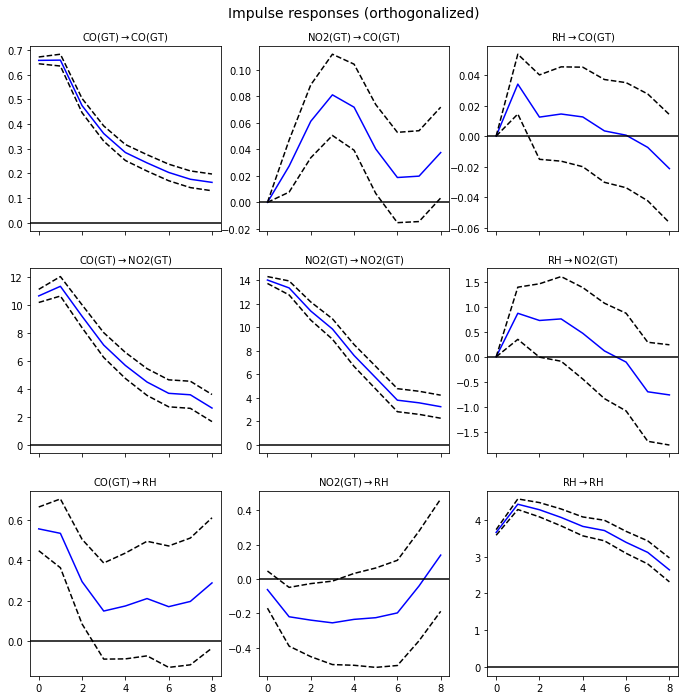

In [96]:
irf = var_model.irf(periods=8)
ax = irf.plot(orth=True, 
              subplot_params={'fontsize': 10})


***Observations:***

*Effects of exogenous perturbation/shocks (1SD) of a variable on itself:*

- CO $\rightarrow$ CO: A shock in the value of CO has a larger effect CO in the early hours but this decays over time. 
- NO2 $\rightarrow$ NO2: A shock in the value of NO2 has a larger effect NO2 in the early hours but this decays over time.
- RH $\rightarrow$ RH: A shock in the value of RH has a largest effect in RH after 1 hour and this effect decays over time. 

*Effects of exogenous perturbation/shocks of a variable on another:*

- CO $\rightarrow$ NO2: A shock in the value of CO has a largest effect in NO2 after 1 hour and this effect decays over time. 
- CO $\rightarrow$ RH: A shock in the value of CO has an immediate effect in the value of RH. However, the effect decreases immediately after an hour, and the value seems to stay at around 0.2.  
- NO2 $\rightarrow$ CO: A shock in NO2 only causes a small effect in the values of CO. There seems to be a delayed effect, peaking after 3 hours, but the magnitude is still small. 
- NO2 $\rightarrow$ RH: A shock in NO2 causes a small (negative) effect in the values of RH. The magnitude seems to decline further after 6 hours. The value of the IRF reaches zero in about 7 hours. 
- RH $\rightarrow$ CO: A shock in RH only causes a small effect in the values of CO.
- RH $\rightarrow$ NO2: A shock in the value of RH has a largest effect in NO2 after 1 hour and this effect decays over time. The value of the IRF reaches zero after 6 hours. 





### Forecast Error Variance Decomposition (FEVD)
- FEVD indicates the amount of information each variable contributes to the other variables in the autoregression
- While impulse response functions trace the effects of a shock to one endogenous variable on to the other variables in the VAR, variance decomposition separates the variation in an endogenous variable into the component shocks to the VAR.
- It determines how much of the forecast error variance of each of the variables can be explained by exogenous shocks to the other variables.


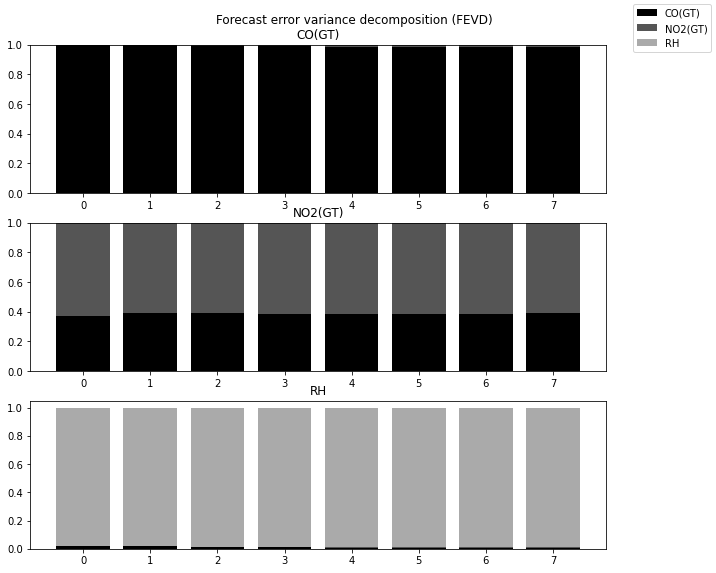

In [97]:
fevd = var_model.fevd(8)
ax = fevd.plot(figsize=(10, 8))
plt.show()

**Observation/s:**
* For CO, the variance is mostly explained by exogenous shocks to CO. This decreases over time but only by a small amount. 
* For NO2, the variance is mostly explained by exogenous shocks to NO2 and CO. 
* For RH, the variance is mostly explained by exogenous shocks to RH. Over time, the contribution of the exogenous shocks to CO increases.  

## Example 4: Jena climate data

We now analyze a second real-world multivariate time series. We will try to forecast the Jena climate data using again the previously outlined method. We will train the VAR model using hourly weather measurements from January 1, 2019 (00:10) up to December 29, 2014 (18:10). The performance of the model will be evaluated on the test set which contains data from December 29, 2014 (19:10) to December 31, 2014 (23:20) which is equivalent to 17,523 data points for each of the variables. 

#### Load dataset

In [98]:
train_df = pd.read_csv('../data/train_series_datetime.csv',index_col=0).set_index('Date Time')
val_df = pd.read_csv('../data/val_series_datetime.csv',index_col=0).set_index('Date Time')
test_df = pd.read_csv('../data/test_series_datetime.csv',index_col=0).set_index('Date Time')
train_df.index = pd.to_datetime(train_df.index)
val_df.index = pd.to_datetime(val_df.index)
test_df.index = pd.to_datetime(test_df.index)

In [99]:
train_val_df = pd.concat([train_df, val_df])
train_df.head(3)

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40         -8.9    93.3   
2009-01-01 01:10:00    996.50     -7.62    265.81         -8.3    94.8   
2009-01-01 02:10:00    996.63     -8.85    264.57         -9.7    93.5   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 01:10:00          3.44          3.26          0.18       2.04   
2009-01-01 02:10:00          3.12          2.92          0.20       1.82   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 01:10:00             3.27       1305.68      0.18           0.63   
2009-01-01 02:10:00             2.93       1312.11      0.16           0.50   

                     wd (deg)  
Date Time                      
2009-01-01 00:10:00     152.3  
2009-01-01 01:10:00     166.5  
2009-01-01 02:10:00     158.3

### 1. Select the variables to include in the model

For this study, we will use all variables in the dataset.

In [100]:
print(list(train_df.columns))

['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']


### 2. Do an Exploratory Data Analysis of the variables

We have already plotted the time series in the introductory section above. For the EDA, let's just inspect the first 2 columns.

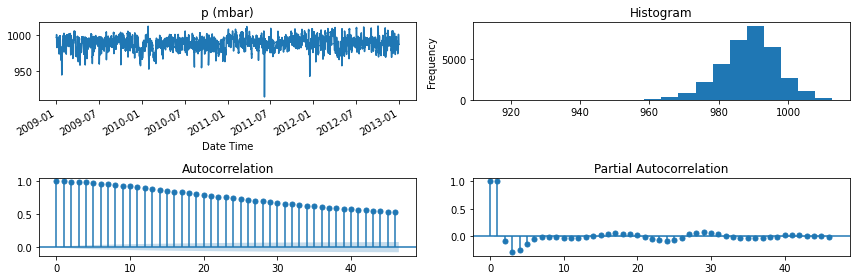

In [101]:
tsplot(train_df, 'p (mbar)')

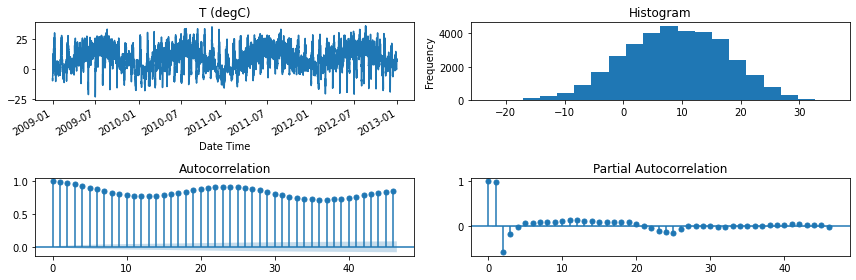

In [102]:
tsplot(train_df, 'T (degC)')

### 3. Check for stationarity

Let's define a utility function to check the stationarity of the data in all columns of a dataframe.

In [103]:
def check_stationarity(adf_results):
    """ Given the results in a dataframe, 
        check if Test statistic is less than the critical values
    """
    print ((adf_results.loc['Test statistic']< adf_results.loc['Critical value - 1%']) & 
    (adf_results.loc['Test statistic']< adf_results.loc['Critical value - 5%']) &
    (adf_results.loc['Test statistic']< adf_results.loc['Critical value - 10%']))

In [104]:
adf_res = adf_test(train_val_df.dropna())
check_stationarity(adf_res)

p (mbar)           True
T (degC)           True
Tpot (K)           True
Tdew (degC)        True
rh (%)             True
VPmax (mbar)       True
VPact (mbar)       True
VPdef (mbar)       True
sh (g/kg)          True
H2OC (mmol/mol)    True
rho (g/m**3)       True
wv (m/s)           True
max. wv (m/s)      True
wd (deg)           True
dtype: bool


***Observations***: 

From the values above, all the components of the Jena climate data are stationary, so we'll use all the variables in our VAR model. 

### 4. For Unstationary Data: Perform data transformation and decide whether to proceed modeling with VAR

Since all variables in our data are stationary, this step can be skipped.

### 5. Create and fit a VAR Model

We now proceed to creating the VAR model.

#### 5a. Split the data into training and test sets.

We have already split the data into training and data sets when we loaded the data at the beginning of this section.

#### 5b. Select the VAR order p

In [105]:
model = VAR(train_val_df)

In [106]:
model_orders = model.select_order(maxlags=40)
model_orders.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

We can make a plot of the values for better inspection.

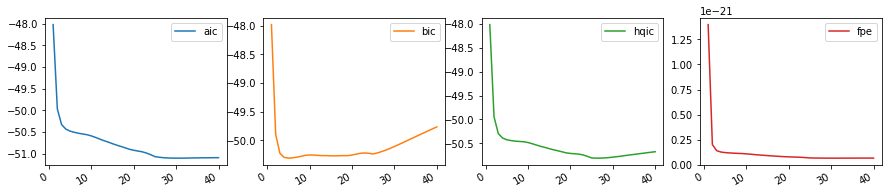

In [107]:
pd.DataFrame(model_orders.ics)[1:].plot(subplots=True, layout=(1,4), figsize=(15,3));

***Observations***: 

The model order that resulted to the minimum value varies for each information criteria, showing no clear minimum. We see an elbow at $p=5$ for BIC, but if we look at AIC and HQIC we're observing another elbow/local minimum at $p=26$. Let's choose $p=26$ as our lag length. 

#### 5c. Fit VAR model of order p

Let's train VAR model using the training and validation data

In [108]:
%%time
var_model = model.fit(26)

Wall time: 2.73 s


### 6. Run Model Diagnostics

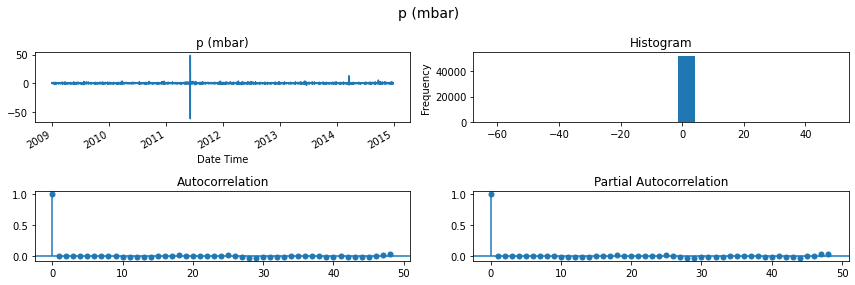

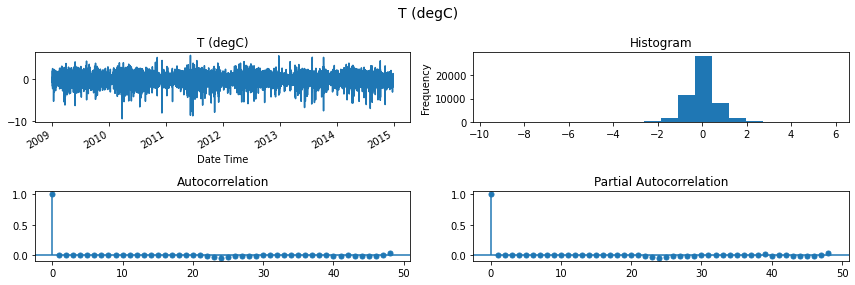

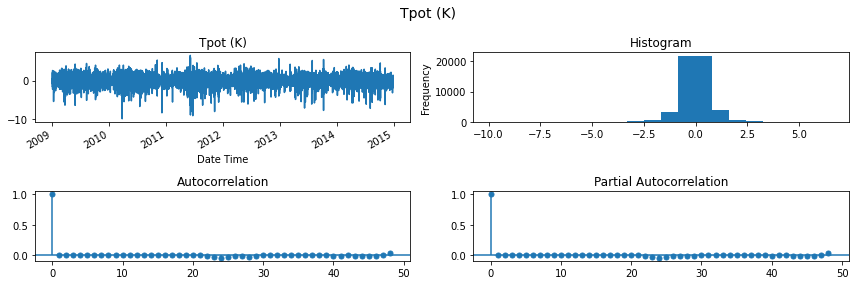

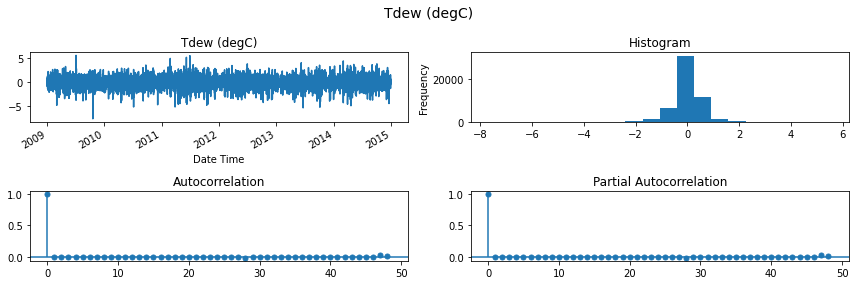

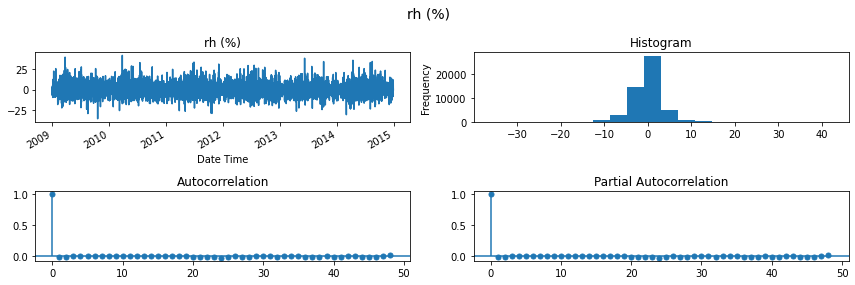

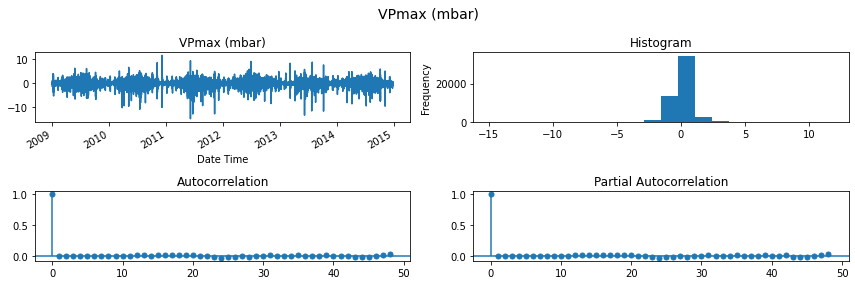

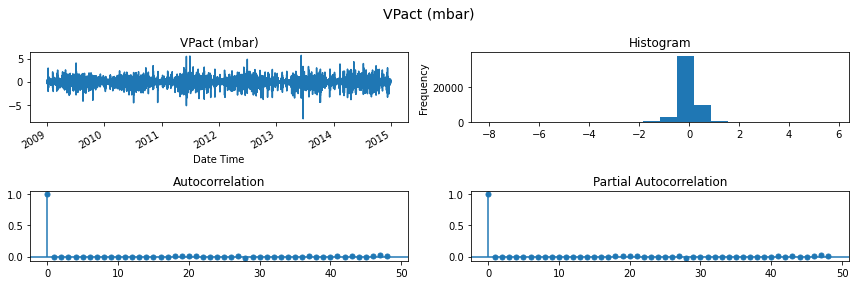

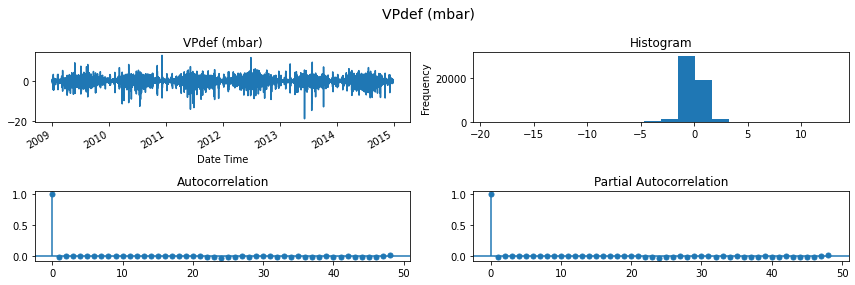

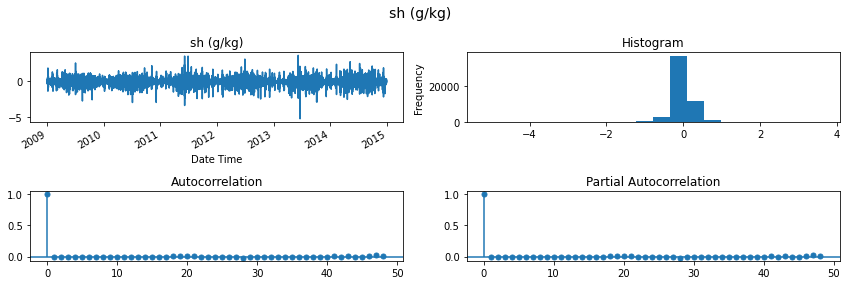

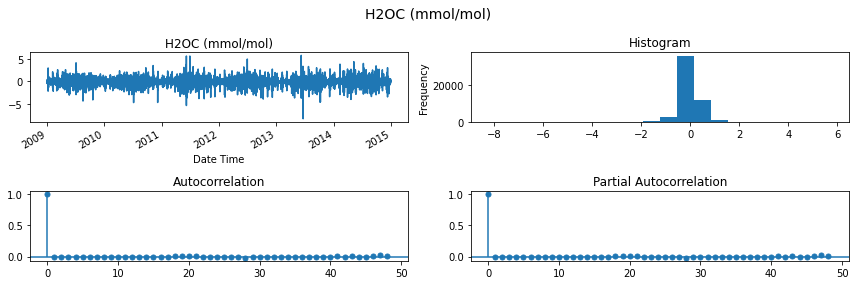

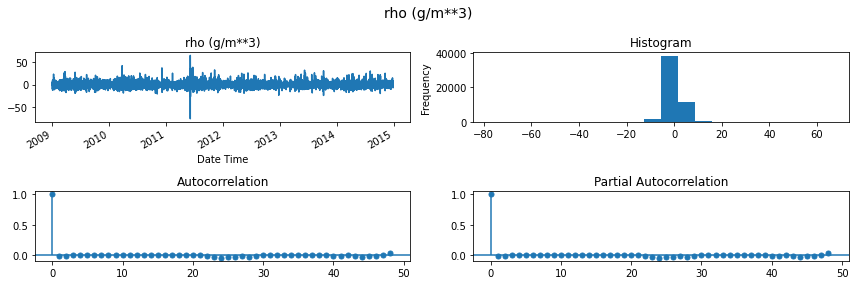

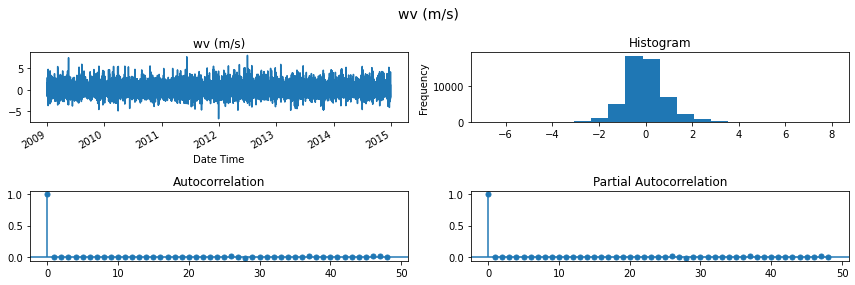

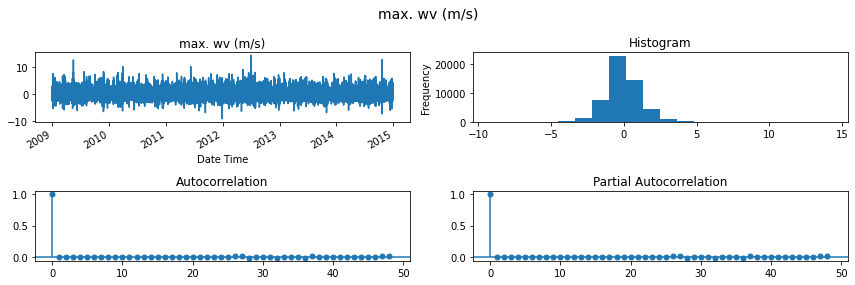

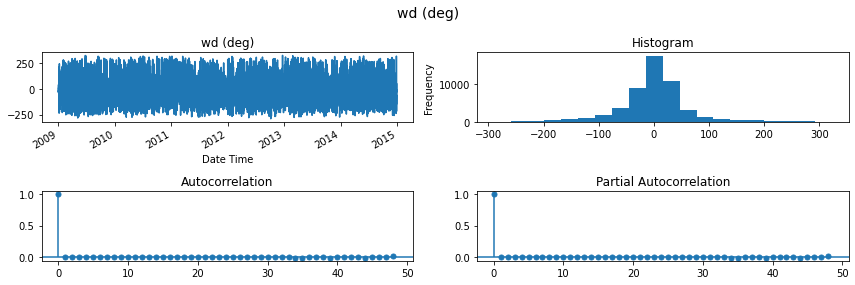

In [109]:
for data_column in list(var_model.resid.columns): 
    tsplot(var_model.resid, data_column, suptitle=f'{data_column}')

### 7. Generate forecast

#### Forecast 24-hour weather measurements and evaluate performance on test set

In [111]:
test_index = np.arange(len(test_df)- (len(test_df))%24).reshape((-1, 24))
fit_index = [test_index[:i].flatten() for i in range(len(test_index))]

In [112]:
forecasts_df = []
for n in range(len(fit_index)):
    forecast_var = pd.DataFrame(var_model.forecast(
        pd.concat([train_val_df, test_df.iloc[fit_index[n]]]).values, steps=24), 
                                columns=train_val_df.columns, 
                                index=test_df.iloc[test_index[n]].index)
    forecasts_df.append(forecast_var)
forecasts_df = pd.concat(forecasts_df)
forecasts_df.columns = forecasts_df.columns+['-VAR']

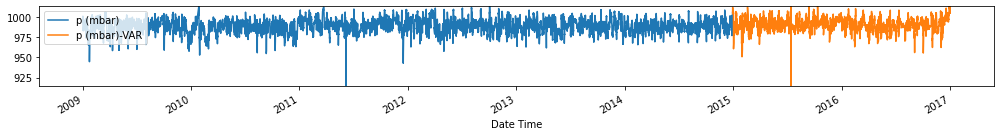

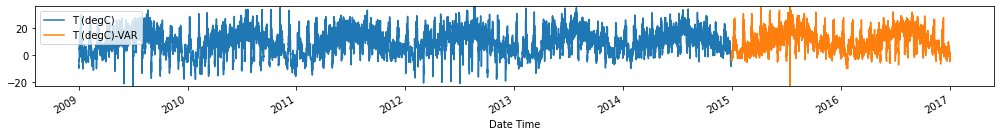

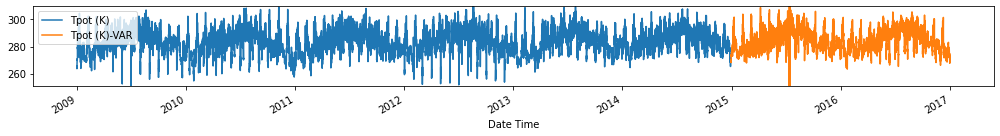

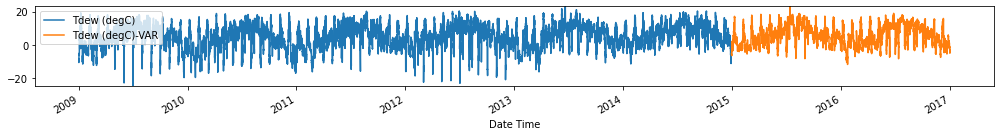

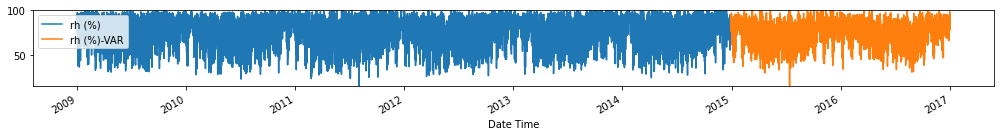

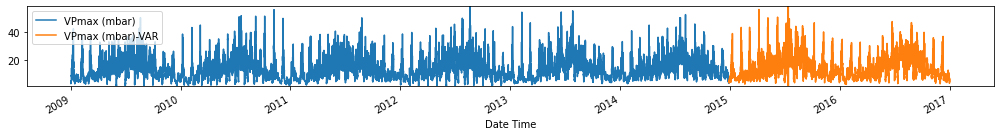

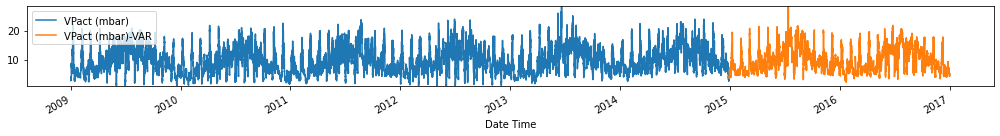

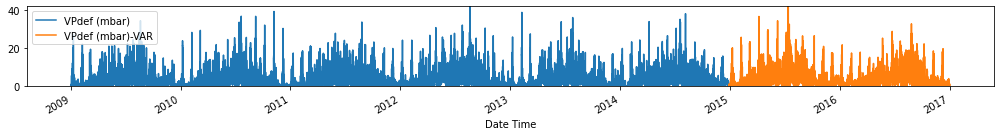

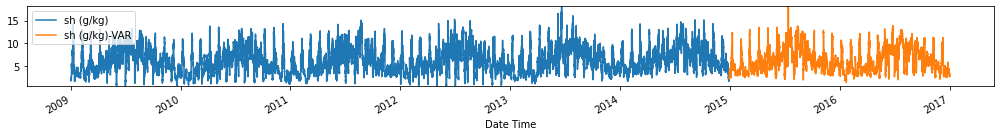

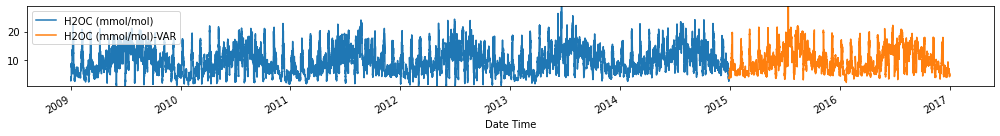

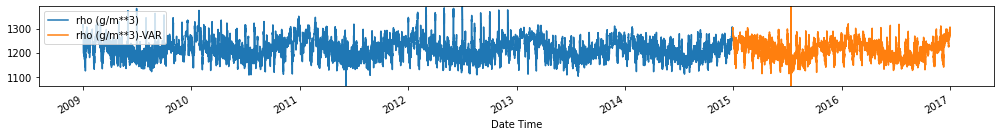

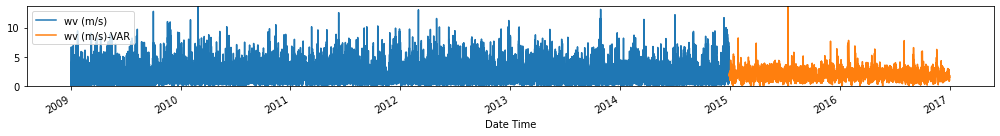

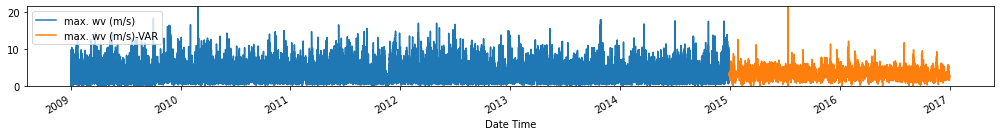

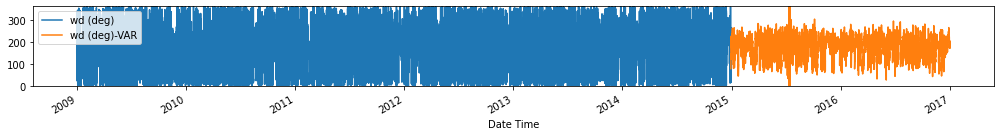

In [113]:
for c in train_val_df.columns:
    fig, ax = plt.subplots(figsize=[14, 2])
    train_val_df[c].plot(ax=ax)
    forecasts_df[[c+'-VAR']].plot(ax=ax)
    plt.ylim(train_val_df[c].min(), train_val_df[c].max())
    plt.legend(loc=2)
    plt.tight_layout()
    plt.show()

### 8. Evaluate forecast

In [114]:
utils.test_performance_metrics(test_df.loc[forecasts_df.index], forecasts_df, suffix='-VAR').loc[['MAE', 'MSE']]

p (mbar)-VAR  T (degC)-VAR  Tpot (K)-VAR  Tdew (degC)-VAR   rh (%)-VAR  \
MAE      2.681284      2.542025      2.603187         1.797102    10.899944   
MSE    238.321753    652.733627    618.458262       102.257346  9581.665059   

     VPmax (mbar)-VAR  VPact (mbar)-VAR  VPdef (mbar)-VAR  sh (g/kg)-VAR  \
MAE          2.526237          1.171625          2.379343       0.744665   
MSE        540.666240         39.837241        490.874048      15.612470   

     H2OC (mmol/mol)-VAR  rho (g/m**3)-VAR  wv (m/s)-VAR  max. wv (m/s)-VAR  \
MAE             1.186948         12.164486      3.136091           4.414089   
MSE            39.678736       9986.126326  17352.964659       23404.318476   

     wd (deg)-VAR  
MAE     66.420597  
MSE  87581.698748

In [115]:
T_MAEs = []
for n in range(len(test_index)):
    index = forecasts_df.iloc[test_index[n]].index
    T_MAEs.append(utils.mean_absolute_error(test_df.loc[index, 'T (degC)'].values, 
                                            forecasts_df.loc[index, 'T (degC)-VAR'].values))

In [116]:
print(f'VAR(26) MAE: {np.mean(T_MAEs)}')

VAR(26) MAE: 2.542025016970521


***Observation***:

The VAR(26) model outperformed the [naive (MAE= 3.18), seasonal naive (MAE= 2.61)](../08_WinningestMethods/lightgbm_jena_forecasting.ipynb) and [ARIMA (MAE= 3.19)](../01_AutoRegressiveIntegratedMovingAverage/01_AutoRegressiveIntegratedMovingAverage.ipynb) models. 

### Forecast 24 hours beyond test set

In [117]:
all_data = pd.concat([train_df, val_df, test_df])

In [118]:
future_index = [all_data.index[-1]+pd.Timedelta(f'{h} hour') for h in np.arange(24)+1]

In [119]:
forecast_var_future = pd.DataFrame(var_model.forecast(all_data.values, 
                                                      steps=24), 
                                   columns=all_data.columns, 
                                   index=future_index)

forecast_var_future.columns = forecast_var_future.columns+['-VAR']

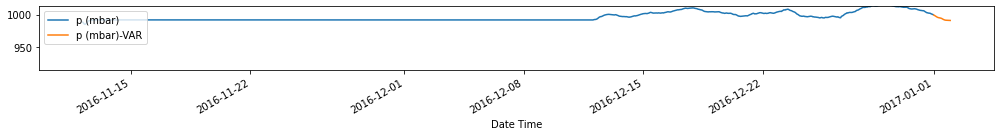

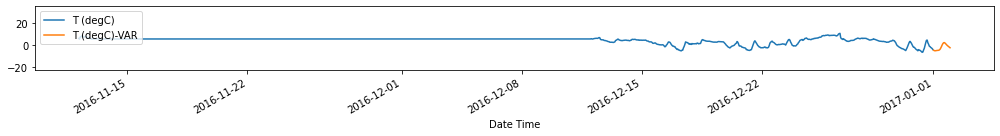

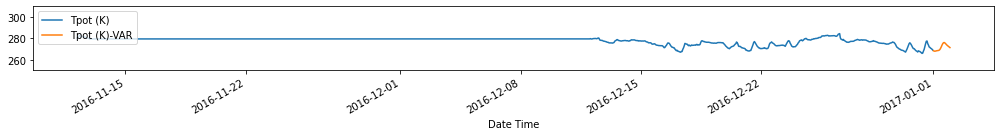

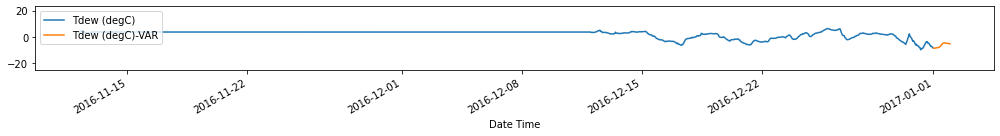

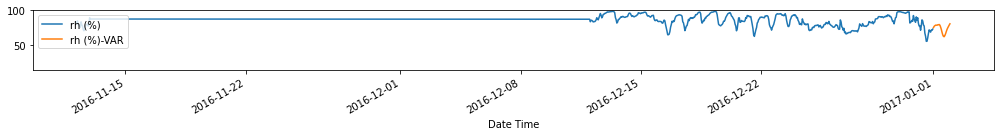

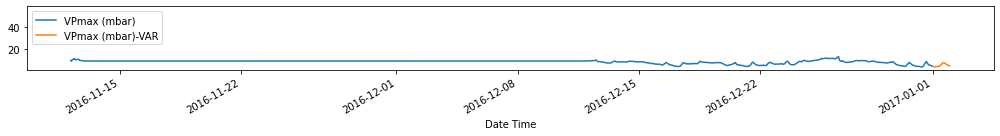

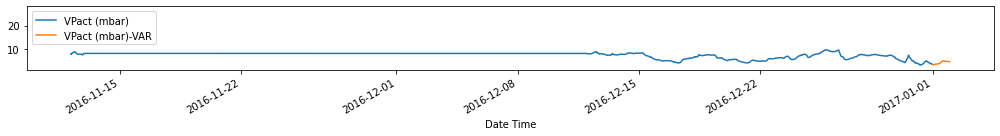

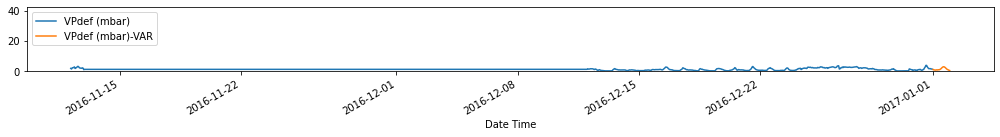

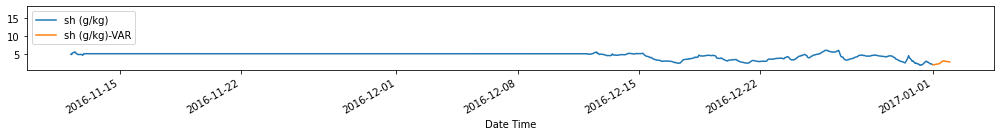

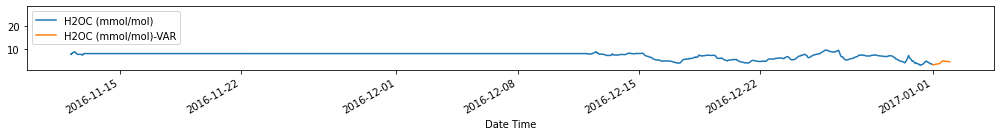

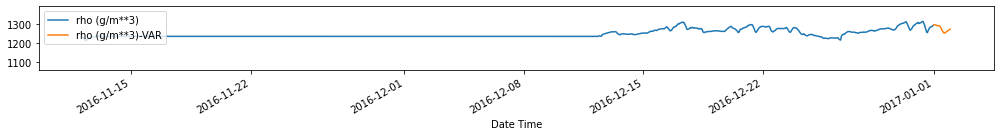

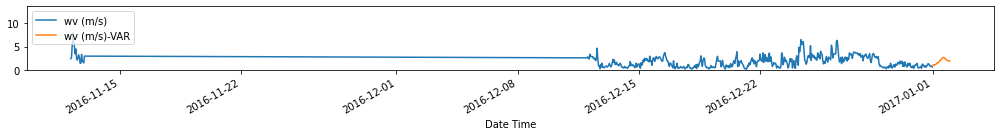

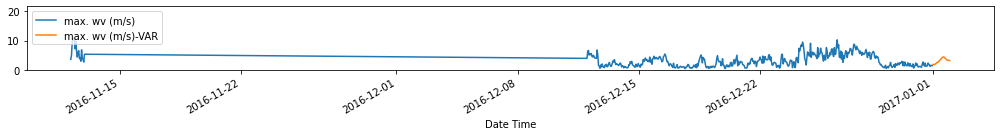

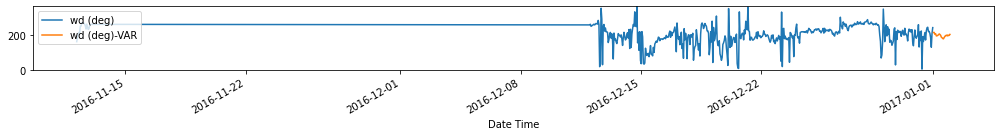

In [120]:
for c in train_val_df.columns:
    fig, ax = plt.subplots(figsize=[14, 2])
    all_data.iloc[-500:][c].plot(ax=ax)
    forecast_var_future[[c+'-VAR']].plot(ax=ax)
    plt.ylim(train_val_df[c].min(), train_val_df[c].max())
    plt.legend(loc=2)
    plt.tight_layout()
    plt.show()

## Example 5: M5 Data

The past two real-word data we examined were data derived from natural phenomenon. In this example, we will examine data generated by human activity. Specifically, we will look at data from the M5 Competition. This data contains sales data of several Wallmart stores in the US.  We have pre-processed the data and saved it in a supplementary notebook. Once again, we shall follow the steps outlined above in building a VAR model.

#### Loading M5 Data 

In [121]:
df_ca = pd.read_csv('../m5-data/m5-CA-stores-total-sales.csv', parse_dates=True, index_col=0)
df_ca.head()

CA_1    CA_2    CA_3    CA_4
date                                      
2011-01-29  4337.0  3494.0  4739.0  1625.0
2011-01-30  4155.0  3046.0  4827.0  1777.0
2011-01-31  2816.0  2121.0  3785.0  1386.0
2011-02-01  3051.0  2324.0  4232.0  1440.0
2011-02-02  2630.0  1942.0  3817.0  1536.0

### 1. Select the variables to include in the model

We have decided to study the total sales for the 4 Wallmart stores in California. 

### 2. Do an Exploratory Data Analysis of the variables

Let's check how our time series looks like.

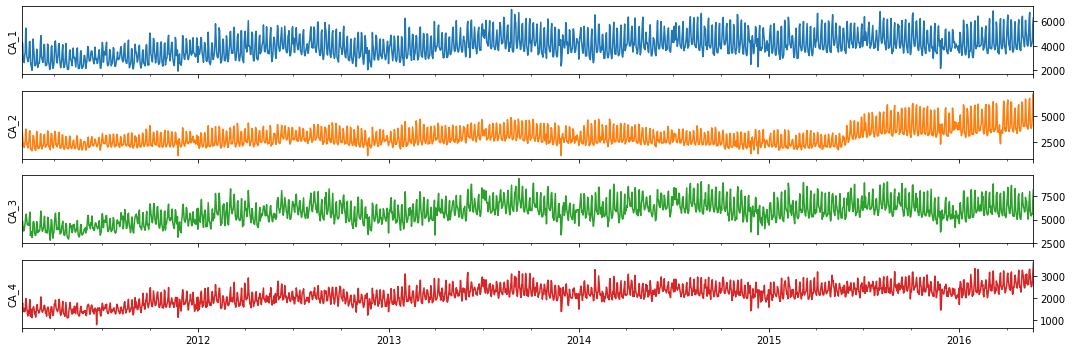

In [122]:
dfplot(df_ca, figsize=(15,5))

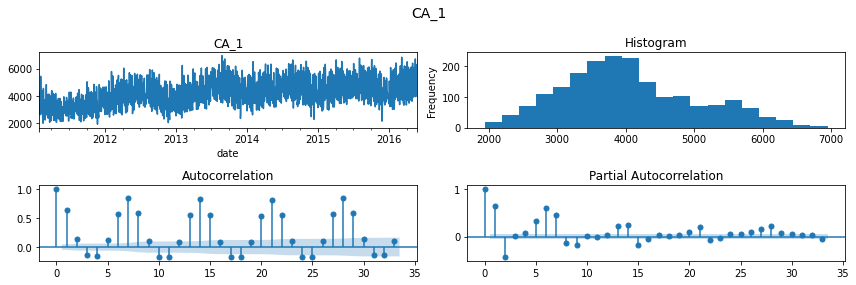

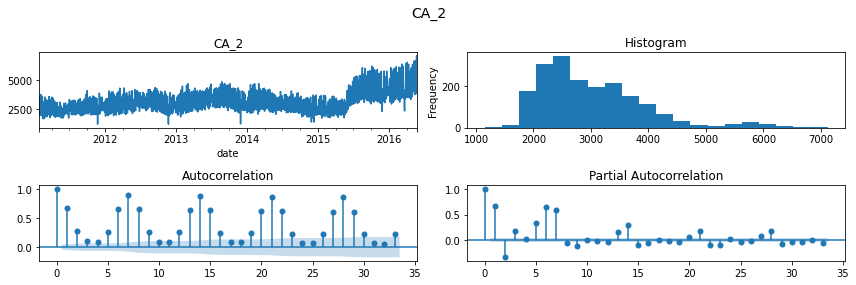

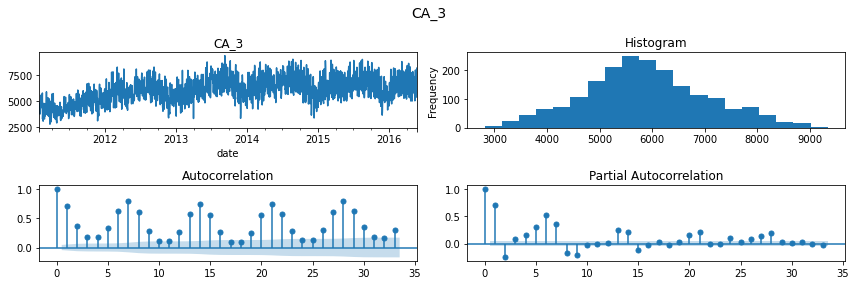

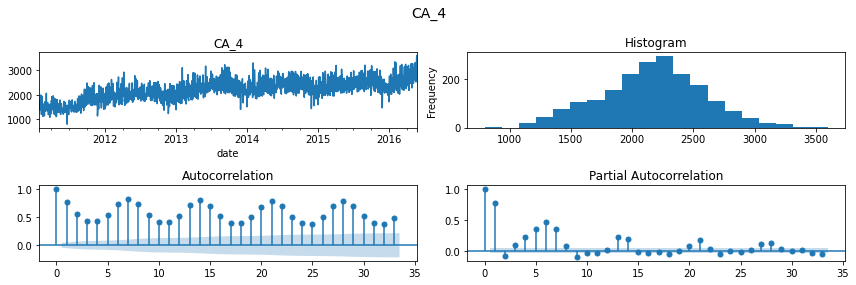

In [123]:
for data_column in list(df_ca.columns): 
    tsplot(df_ca, data_column, suptitle=f'{data_column}')

#### Plot Cross Correlation Function 

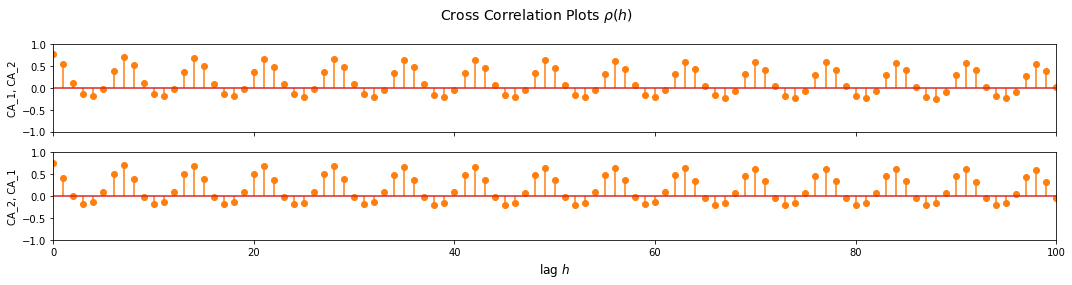

In [124]:
ccf_plot(df_ca, 'CA_1', 'CA_2')

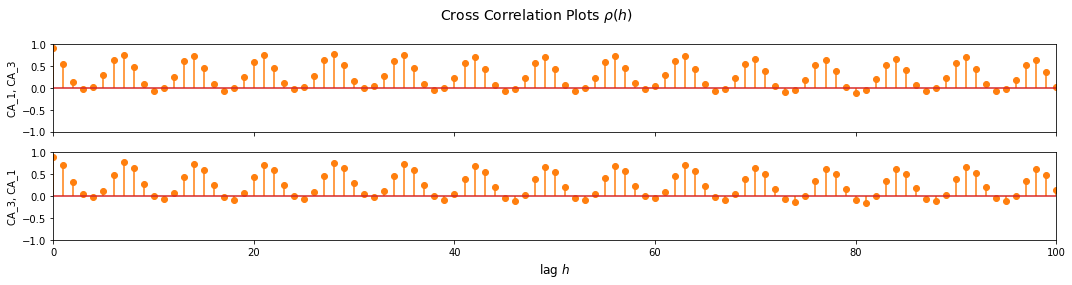

In [125]:
ccf_plot(df_ca, 'CA_1', 'CA_3')

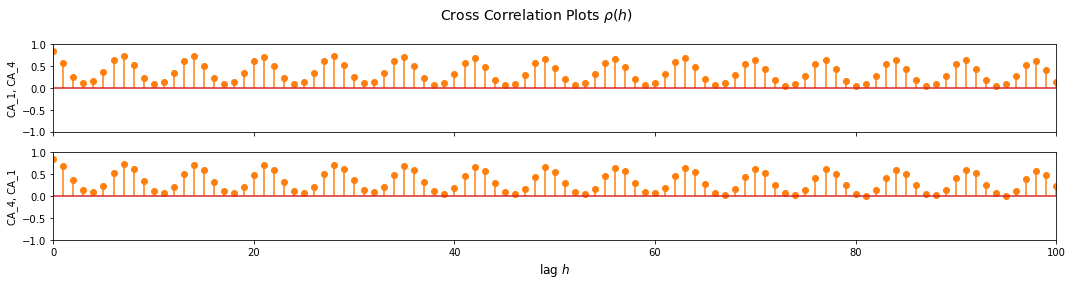

In [126]:
ccf_plot(df_ca,  'CA_1', 'CA_4')

### 3. Check for stationarity

In [127]:
adf_res = adf_test(df_ca)
adf_res.round(4)

CA_1    CA_2    CA_3    CA_4
Test statistic       -1.8839  0.1702 -2.3786 -1.3213
p-value               0.3397  0.9705  0.1479  0.6194
Critical value - 1%  -3.4338 -3.4338 -3.4338 -3.4338
Critical value - 5%  -2.8631 -2.8631 -2.8631 -2.8631
Critical value - 10% -2.5676 -2.5676 -2.5676 -2.5676

In [128]:
check_stationarity(adf_res)

CA_1    False
CA_2    False
CA_3    False
CA_4    False
dtype: bool


As they are, the time series are not stationary. The seasonality of the plots are actually quite obvious. We will try to remove the seasonality by differencing with 7 (a good hunch since sales tend to follow cycle weekly).

### 4. For Unstationary Data: Perform data transformation and decide whether to proceed modeling with VAR

VAR modelling does not admit unstationary data, thus we will have to transform our data to make it stationary.

#### Perform differencing to enforce stationarity

In [129]:
diff_period = 7

In [130]:
df_ca_diffed = df_ca.diff(periods=diff_period).dropna()

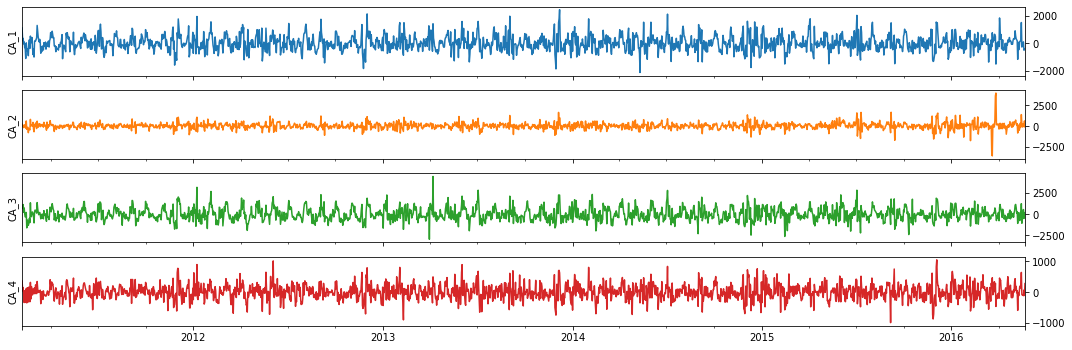

In [131]:
dfplot(df_ca_diffed, figsize=(15,5))

Test for stationarity again

In [132]:
adf_res = adf_test(df_ca_diffed)
adf_res.round(4)

CA_1    CA_2     CA_3     CA_4
Test statistic       -17.9556 -9.4740 -18.3267 -16.5324
p-value                0.0000  0.0000   0.0000   0.0000
Critical value - 1%   -3.4338 -3.4338  -3.4338  -3.4338
Critical value - 5%   -2.8631 -2.8631  -2.8631  -2.8631
Critical value - 10%  -2.5676 -2.5676  -2.5676  -2.5676

In [133]:
check_stationarity(adf_res)

CA_1    True
CA_2    True
CA_3    True
CA_4    True
dtype: bool


The series are now stationary. We say that the multivariate time series are $I(1)$ since we've performed differencing operation once. At this point, we can decide whether to proceed modelling with VAR or to model with Vector Error Correction Model. A deciding factor is whether are interested in maintaining the cointegrating relationships between the variables. Since we are covering VAR Modeling at the moment, we will ignore this for now and leave the matter of running cointegration tests and building a VECM model as an extension of this study.

### 5. Create and fit a VAR Model

#### 5a. Split data into train and test sets

The M5 competition is asking for a forecast of 28 days. We will split the evaluation data set to a train and test set, the latter containing the last 28 values of the evaluation data.

In [134]:
fh = 28                             # forecast horizon, the number of forecasts to make.
train_df = df_ca_diffed.iloc[:-fh,] # use all but last fh values for training
test_df = df_ca_diffed.iloc[-fh:,]  # last fh values for testing

#### 5b. Select VAR order p

In [135]:
model = VAR(train_df)

In [136]:
model_orders = model.select_order(maxlags=40)
model_orders.summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [137]:
model_orders.selected_orders

{'aic': 37, 'bic': 14, 'hqic': 22, 'fpe': 37}

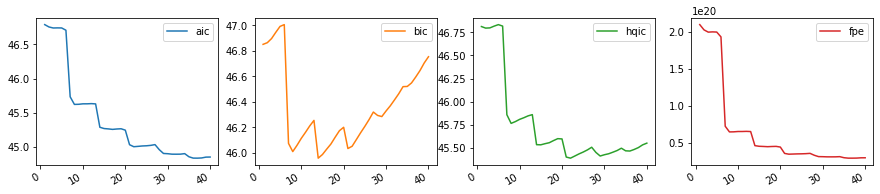

In [138]:
pd.DataFrame(model_orders.ics)[1:].plot(subplots=True, layout=(1,4), figsize=(15,3));

Elbow for HQIC is at 22. Although lower values are achieved for AIC at higher values of 22, we note that HQIC and BIC at those levels begin to go up. So we choose p=22. 

#### 5c. Fit VAR model of order p 

In [139]:
var_model = model.fit(22)

Let's check the model

In [140]:
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 02, Jan, 2022
Time:                     01:09:15
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    46.0175
Nobs:                     1884.00    HQIC:                   45.3560
Log likelihood:          -52699.2    FPE:                3.39249e+19
AIC:                      44.9704    Det(Omega_mle):     2.82055e+19
--------------------------------------------------------------------
Results for equation CA_1
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            6.802173         9.010581            0.755           0.450
L1.CA_1          0.308212         0.035086            8.785           0.000
L1.CA_2          0.043271         0.036470            1.186           0.235
L1.CA

### 6. Run Model Diagnostics

Let's plot the model residuals

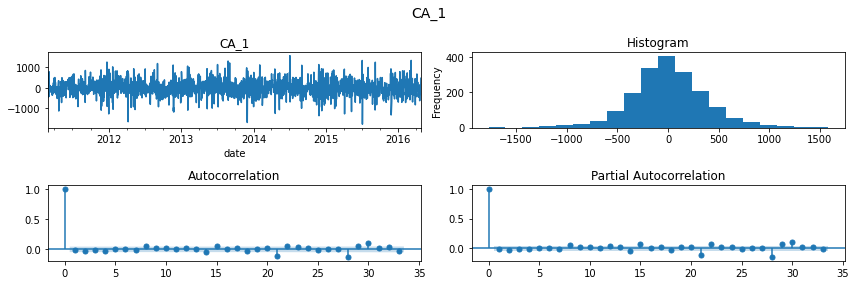

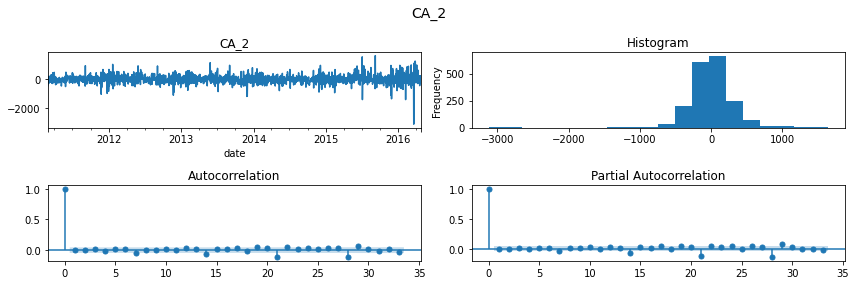

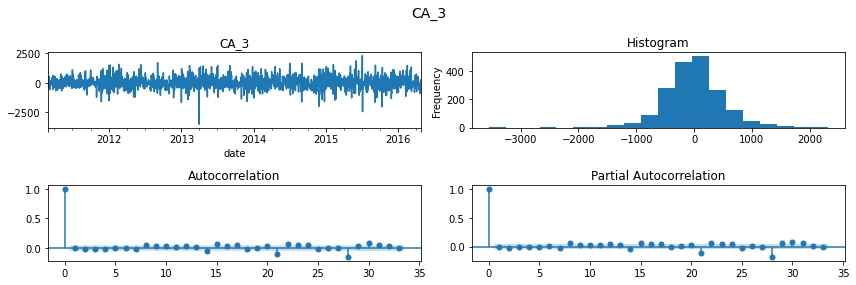

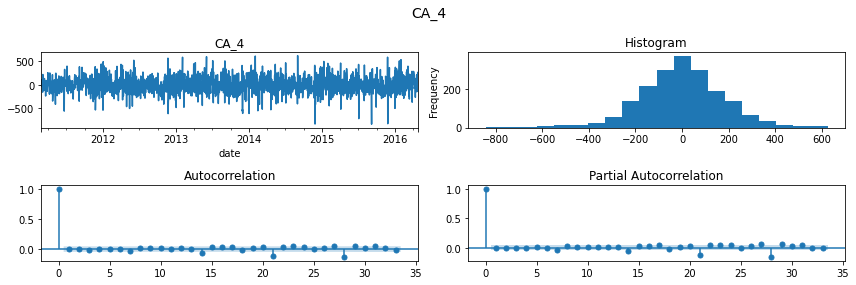

In [141]:
for data_column in list(var_model.resid.columns): 
    tsplot(var_model.resid, data_column, suptitle=f'{data_column}')

The plots look like white noise without presence of autocorrelations. Thus we conclude that the model is viable.

### 7. Generate forecast

#### Create a dataframe with the VAR forecast

In [142]:
forecast = var_model.forecast(train_df.values, steps=fh)

Convert the forecast to a dataframe and append '-VAR' to column names

In [143]:
forecast_var = pd.DataFrame(forecast, 
                            columns=test_df.columns, 
                            index= test_df.index
                           )
forecast_var.rename(columns={c: c+'-VAR' for c in forecast_var.columns}, inplace=True)
forecast_var

CA_1-VAR    CA_2-VAR    CA_3-VAR    CA_4-VAR
date                                                      
2016-04-25  -74.122930 -180.212046 -286.914810 -122.076241
2016-04-26 -192.982494    3.677824 -156.859489 -250.539790
2016-04-27 -195.643056 -130.728564  -73.259955 -109.267398
2016-04-28   96.728828  195.553910  218.328461   62.042862
2016-04-29  157.182075   86.931278  167.148215  -76.268224
2016-04-30  305.068928   58.258736  -25.274645   76.487693
2016-05-01   97.234665  105.205656  639.736074  -45.567550
2016-05-02  214.330553  139.663019  449.419674   53.666622
2016-05-03  181.219754  -91.703631  213.534829   66.465701
2016-05-04  295.277870   90.127795  348.842502   34.111744
2016-05-05   88.286441  -27.925399  287.781126    4.050193
2016-05-06   -2.253055 -106.926959  113.049625   -8.020113
2016-05-07   70.690842  -13.280679  217.614417   16.273904
2016-05-08   61.656386 -116.427168   63.707827   -4.920429
2016-05-09   31.565773  -24.201090   74.902162  -60.447509
2016-05-10   65.565191  125.566397  134.849128  -18.625939
2016-05-11 -113.224965  -94.821182  -32.393748   -4.361604
2016-05-12 -122.592304  -39.089830  -95.542132  -31.350276
2016-05-13 -136.726740   64.112991 -132.908971    7.643143
2016-05-14 -293.489004 -179.829426 -234.779905 -110.087798
2016-05-15 -171.792377  -41.255566 -220.539143  -33.424181
2016-05-16  -62.784171   42.179982 -135.795795   67.930895
2016-05-17  -79.185362  -17.944058 -175.326310   47.354313
2016-05-18  -37.770268  113.867402 -158.431662   -2.087539
2016-05-19  -37.175104   13.716398 -182.039569   -0.746921
2016-05-20  -14.790479  -27.252922  -92.130082    9.277865
2016-05-21   41.589796  124.987879  -63.695240   42.711382
2016-05-22  -36.303727   63.861633 -167.495747   13.599263

We have to remember that these are **differenced forecasts**. <br>
Let's plot the differences and this forecast.

In [144]:
def plot_data_with_forecast(data, forecast, start_date="", var_column_postfix="-VAR"):
    """ Plot the data (training and testing) together with the forecast
        data, forecast are dataframes
        start plotting at start_date if provided
    """
    for c in data.columns:
        fig, ax = plt.subplots(figsize=[15, 2])
        #pd.concat([train_df[[c]], forecast_aug[[c+'-VAR']]], axis=1).plot(ax=ax)
        data[c].plot(ax=ax)
        forecast[[c+var_column_postfix]].plot(ax=ax)
        if start_date:
            plt.xlim(left=pd.to_datetime(start_date))
        plt.xlabel('')
        plt.show()

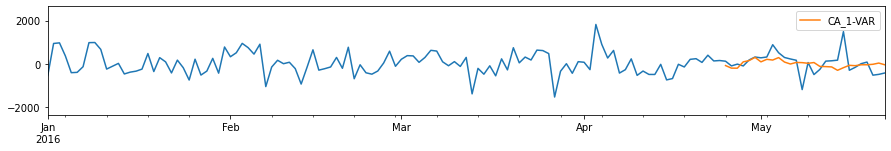

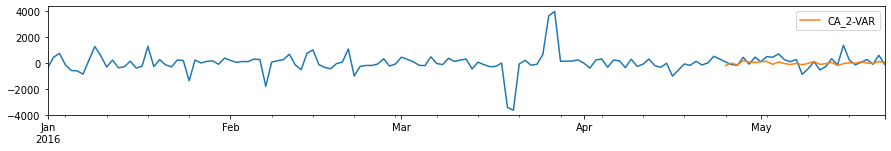

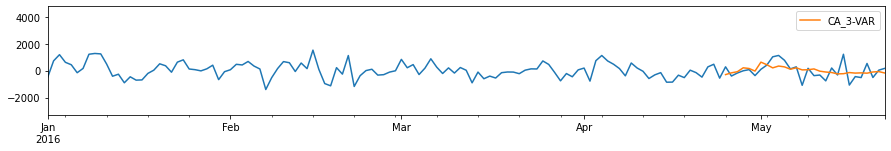

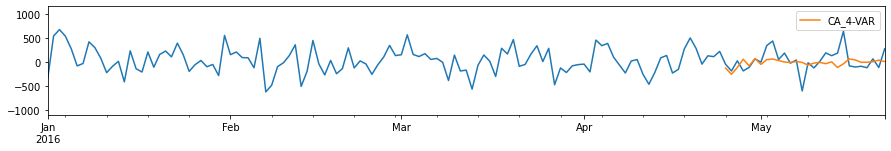

In [145]:
plot_data_with_forecast(df_ca_diffed, forecast_var, start_date="2016-01-01")

#### Get Actual Forecast Values by De-differencing

##### Pre-concantenate actual time series values *fh* periods before test data

Create a dataframe `df_aux` containing the `diff_period` rows immediately prior to beginning of the test index.  E.g. if `diff_period` = 7 and `fh`=28 (forecast horizon),
```python
forecast_aug = df[-35:-28]
```

In [146]:
df_aux = df_ca[-(diff_period+fh):-fh]
df_aux.columns=[c+'-VAR' for c in df_aux.columns]

In [147]:
pd.reset_option('max_rows')
df_aux

CA_1-VAR  CA_2-VAR  CA_3-VAR  CA_4-VAR
date                                              
2016-04-18    4345.0    3830.0    6068.0    2809.0
2016-04-19    3793.0    3631.0    5683.0    2677.0
2016-04-20    3722.0    3691.0    5235.0    2500.0
2016-04-21    3709.0    3303.0    5018.0    2458.0
2016-04-22    4387.0    4457.0    5623.0    2628.0
2016-04-23    5577.0    5884.0    7419.0    2954.0
2016-04-24    6113.0    6082.0    7721.0    3271.0

Augment the previous dataframe to the **differenced forecast**.

In [148]:
df_aux = pd.concat([df_aux, forecast_var], axis=0)
df_aux

CA_1-VAR     CA_2-VAR     CA_3-VAR     CA_4-VAR
date                                                          
2016-04-18  4345.000000  3830.000000  6068.000000  2809.000000
2016-04-19  3793.000000  3631.000000  5683.000000  2677.000000
2016-04-20  3722.000000  3691.000000  5235.000000  2500.000000
2016-04-21  3709.000000  3303.000000  5018.000000  2458.000000
2016-04-22  4387.000000  4457.000000  5623.000000  2628.000000
2016-04-23  5577.000000  5884.000000  7419.000000  2954.000000
2016-04-24  6113.000000  6082.000000  7721.000000  3271.000000
2016-04-25   -74.122930  -180.212046  -286.914810  -122.076241
2016-04-26  -192.982494     3.677824  -156.859489  -250.539790
2016-04-27  -195.643056  -130.728564   -73.259955  -109.267398
2016-04-28    96.728828   195.553910   218.328461    62.042862
2016-04-29   157.182075    86.931278   167.148215   -76.268224
2016-04-30   305.068928    58.258736   -25.274645    76.487693
2016-05-01    97.234665   105.205656   639.736074   -45.567550
2016-05-02   214.330553   139.663019   449.419674    53.666622
2016-05-03   181.219754   -91.703631   213.534829    66.465701
2016-05-04   295.277870    90.127795   348.842502    34.111744
2016-05-05    88.286441   -27.925399   287.781126     4.050193
2016-05-06    -2.253055  -106.926959   113.049625    -8.020113
2016-05-07    70.690842   -13.280679   217.614417    16.273904
2016-05-08    61.656386  -116.427168    63.707827    -4.920429
2016-05-09    31.565773   -24.201090    74.902162   -60.447509
2016-05-10    65.565191   125.566397   134.849128   -18.625939
2016-05-11  -113.224965   -94.821182   -32.393748    -4.361604
2016-05-12  -122.592304   -39.089830   -95.542132   -31.350276
2016-05-13  -136.726740    64.112991  -132.908971     7.643143
2016-05-14  -293.489004  -179.829426  -234.779905  -110.087798
2016-05-15  -171.792377   -41.255566  -220.539143   -33.424181
2016-05-16   -62.784171    42.179982  -135.795795    67.930895
2016-05-17   -79.185362   -17.944058  -175.326310    47.354313
2016-05-18   -37.770268   113.867402  -158.431662    -2.087539
2016-05-19   -37.175104    13.716398  -182.039569    -0.746921
2016-05-20   -14.790479   -27.252922   -92.130082     9.277865
2016-05-21    41.589796   124.987879   -63.695240    42.711382
2016-05-22   -36.303727    63.861633  -167.495747    13.599263

In [149]:
df_aux.shape

(35, 4)

##### Perform De-differrencing

Replace the forecasted differenced values by adding the values `fh` days ago

In [150]:
# we differenced the original data by 7
for i in range(7, df_aux.shape[0]):
    df_aux.iloc[i] = df_aux.iloc[i] + df_aux.iloc[i-7]

Drop the previously augmented original values so that we are left with forecast values only

In [151]:
forecast_final = df_aux[7:] 
forecast_final

CA_1-VAR     CA_2-VAR     CA_3-VAR     CA_4-VAR
date                                                          
2016-04-25  4270.877070  3649.787954  5781.085190  2686.923759
2016-04-26  3600.017506  3634.677824  5526.140511  2426.460210
2016-04-27  3526.356944  3560.271436  5161.740045  2390.732602
2016-04-28  3805.728828  3498.553910  5236.328461  2520.042862
2016-04-29  4544.182075  4543.931278  5790.148215  2551.731776
2016-04-30  5882.068928  5942.258736  7393.725355  3030.487693
2016-05-01  6210.234665  6187.205656  8360.736074  3225.432450
2016-05-02  4485.207623  3789.450973  6230.504864  2740.590381
2016-05-03  3781.237260  3542.974193  5739.675339  2492.925911
2016-05-04  3821.634813  3650.399230  5510.582547  2424.844346
2016-05-05  3894.015269  3470.628511  5524.109587  2524.093055
2016-05-06  4541.929020  4437.004319  5903.197839  2543.711663
2016-05-07  5952.759770  5928.978056  7611.339771  3046.761598
2016-05-08  6271.891050  6070.778488  8424.443901  3220.512021
2016-05-09  4516.773396  3765.249882  6305.407026  2680.142872
2016-05-10  3846.802451  3668.540590  5874.524468  2474.299973
2016-05-11  3708.409848  3555.578048  5478.188799  2420.482742
2016-05-12  3771.422966  3431.538681  5428.567456  2492.742779
2016-05-13  4405.202279  4501.117311  5770.288869  2551.354806
2016-05-14  5659.270766  5749.148631  7376.559866  2936.673800
2016-05-15  6100.098673  6029.522921  8203.904759  3187.087840
2016-05-16  4453.989224  3807.429864  6169.611231  2748.073766
2016-05-17  3767.617089  3650.596531  5699.198158  2521.654285
2016-05-18  3670.639580  3669.445450  5319.757137  2418.395203
2016-05-19  3734.247862  3445.255079  5246.527886  2491.995858
2016-05-20  4390.411800  4473.864389  5678.158786  2560.632671
2016-05-21  5700.860562  5874.136509  7312.864625  2979.385182
2016-05-22  6063.794946  6093.384554  8036.409012  3200.687103

Let's plot the forecast with the actual values

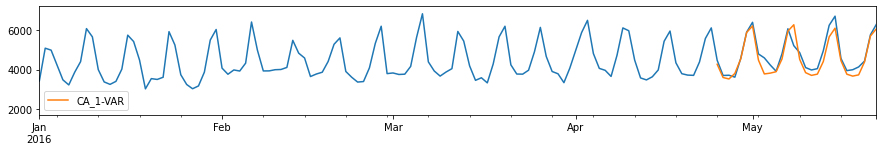

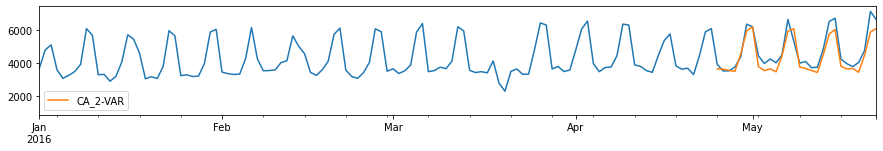

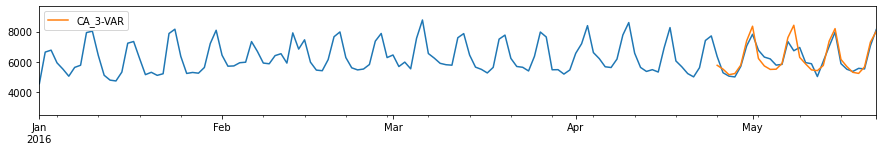

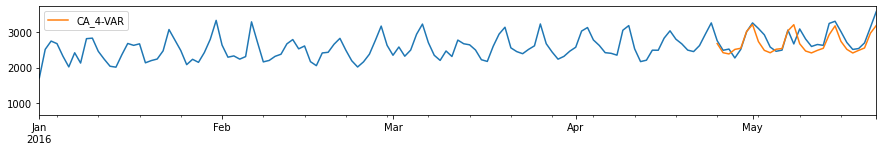

In [152]:
plot_data_with_forecast(df_ca, forecast_final, start_date="2016-01-01")

### 8. Evaluate forecast

We will expand the discussion on the evaluation of this model in the very next section below.
<br><br>

## VAR Performance Evaluation

In this section, we will focus on model evaluation, making use of the most recent model that we have made based on the M5 data.

### Error Metrics

First, let's print out the Mean Average Error (MAE), Mean Squared Error (MSE) and Mean Percentage Error (MAPE).

In [153]:
var_performance = utils.test_performance_metrics(df_ca[-fh:], forecast_final, suffix='-VAR')
var_performance

CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR
MAE      291.055625     406.771752     353.843012    186.724962
MSE   142981.132433  239912.973224  223568.253308  55920.661288
MAPE       6.092951       8.284302       5.559647      6.528636

Let's save this dataframe for accessing in later portions of this notebook.

In [154]:
var_performance_d1_p22 = var_performance.copy()

#### Perfomance Evaluation Methods

We will evaluate our model in 3 ways: Comparing its performance with 
1. a separate univariate process modeled with ARIMA
2. the forecast based on values n-periods ago
3. the forecast based on the average of the values on a specified window.

### Performance Evaluation #1: VAR vs. Separate Univariate Process modeled with ARIMA

For baseline comparison, we'll also take a look at the performance of modeling the univariate timeseries of the total sales from the first California store (`CA_1`) using ARIMA.

In [155]:
from statsmodels.tsa.arima.model import ARIMA
import itertools

In [156]:
def select_arma_order(dataframe, column, max_order=8):
    """ Plot charts of Information Criteria to aid in selecting the optimal value of p and q
        Assumes data is already differentiated (hence, I=0) 
        Return: 
    """
    p_grid = range(max_order)
    d_grid = [0]
    q_grid = range(max_order)

    aic, bic, hqic, idx = [], [], [], []
    models = {}
    print("Processing (p,d,q):")
    for pdq in itertools.product(p_grid, d_grid, q_grid):
        print(f'{pdq}', end=" ")         
        model = ARIMA(dataframe[column], order=pdq).fit()
        models[pdq] = model
        aic.append(model.aic)
        bic.append(model.bic)
        hqic.append(model.hqic)
        idx.append(f'({pdq[0]}, {pdq[2]})')
    print("\nDone." )
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic}, 
                                   index=idx)    
    fig, ax = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    return models, lags_metrics_df

Processing (p,d,q):
(0, 0, 0) (0, 0, 1) (0, 0, 2) (0, 0, 3) (0, 0, 4) (0, 0, 5) (1, 0, 0) (1, 0, 1) (1, 0, 2) (1, 0, 3) (1, 0, 4) (1, 0, 5) (2, 0, 0) (2, 0, 1) (2, 0, 2) (2, 0, 3) (2, 0, 4) (2, 0, 5) (3, 0, 0) (3, 0, 1) (3, 0, 2) (3, 0, 3) (3, 0, 4) (3, 0, 5) (4, 0, 0) (4, 0, 1) (4, 0, 2) (4, 0, 3) (4, 0, 4) (4, 0, 5) (5, 0, 0) (5, 0, 1) (5, 0, 2) (5, 0, 3) (5, 0, 4) (5, 0, 5) 
Done.


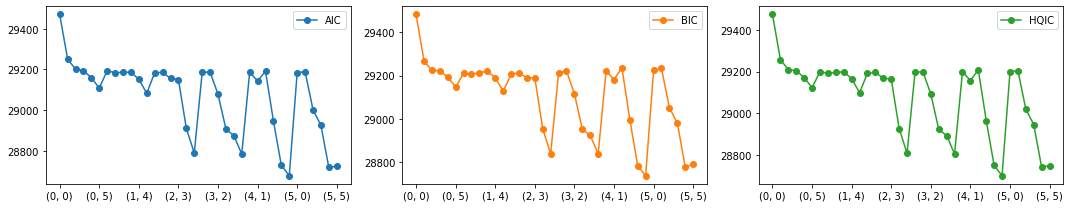

In [157]:
arima_models, lags_metrics_arima_df = select_arma_order(df_ca_diffed[:-fh], 'CA_1', max_order=6)

In [158]:
lags_metrics_arima_df.idxmin()

AIC     (4, 5)
BIC     (4, 5)
HQIC    (4, 5)
dtype: object

We'll use (p,q) = (4,5)

#### Generate Forecast (on differentiated data)

Let's generate the forecast on the differentiated data.

In [159]:
forecast_arima = arima_models[(4, 0, 5)].forecast(steps=fh)
forecast_arima 

2016-04-25     81.364273
2016-04-26    206.048222
2016-04-27     92.023263
2016-04-28     60.976444
2016-04-29    129.039128
2016-04-30     -5.680241
2016-05-01   -128.152295
2016-05-02    -50.124355
2016-05-03     36.459625
2016-05-04     28.015442
2016-05-05     20.388696
2016-05-06     26.772117
2016-05-07      1.673870
2016-05-08    -21.003522
2016-05-09     -8.119235
2016-05-10      9.167385
2016-05-11      9.946194
2016-05-12      8.375098
2016-05-13      8.395138
2016-05-14      3.533447
2016-05-15     -0.708049
2016-05-16      1.452915
2016-05-17      4.900503
2016-05-18      5.483729
2016-05-19      5.195275
2016-05-20      4.981560
2016-05-21      4.007500
2016-05-22      3.203458
Freq: D, Name: predicted_mean, dtype: float64

#### Get the actual forecast values

From the forecast on differentiated data, we'll compute the actual forecast.

In [160]:
# Get the values fh periods ago from the beginning of test data
# this will be augmented to the forecast so that we can perform reverse differencing
forecast_arima_aug = df_ca[-(diff_period+fh):-fh].CA_1
forecast_arima_aug

date
2016-04-18    4345.0
2016-04-19    3793.0
2016-04-20    3722.0
2016-04-21    3709.0
2016-04-22    4387.0
2016-04-23    5577.0
2016-04-24    6113.0
Name: CA_1, dtype: float64

In [161]:
# append the auxilliary series forecast_arima_aug defined above to the actual forecast
forecast_arima_final = pd.concat([forecast_arima_aug, forecast_arima], axis=0)
forecast_arima_final

2016-04-18    4345.000000
2016-04-19    3793.000000
2016-04-20    3722.000000
2016-04-21    3709.000000
2016-04-22    4387.000000
2016-04-23    5577.000000
2016-04-24    6113.000000
2016-04-25      81.364273
2016-04-26     206.048222
2016-04-27      92.023263
2016-04-28      60.976444
2016-04-29     129.039128
2016-04-30      -5.680241
2016-05-01    -128.152295
2016-05-02     -50.124355
2016-05-03      36.459625
2016-05-04      28.015442
2016-05-05      20.388696
2016-05-06      26.772117
2016-05-07       1.673870
2016-05-08     -21.003522
2016-05-09      -8.119235
2016-05-10       9.167385
2016-05-11       9.946194
2016-05-12       8.375098
2016-05-13       8.395138
2016-05-14       3.533447
2016-05-15      -0.708049
2016-05-16       1.452915
2016-05-17       4.900503
2016-05-18       5.483729
2016-05-19       5.195275
2016-05-20       4.981560
2016-05-21       4.007500
2016-05-22       3.203458
dtype: float64

In [162]:
# perform 'roll forward' operation
for i in range(7, forecast_arima_final.shape[0]):
    forecast_arima_final.iloc[i] = forecast_arima_final.iloc[i] + forecast_arima_final.iloc[i-7]

Now we have the final ARIMA forecast

In [163]:
forecast_arima_final

2016-04-18    4345.000000
2016-04-19    3793.000000
2016-04-20    3722.000000
2016-04-21    3709.000000
2016-04-22    4387.000000
2016-04-23    5577.000000
2016-04-24    6113.000000
2016-04-25    4426.364273
2016-04-26    3999.048222
2016-04-27    3814.023263
2016-04-28    3769.976444
2016-04-29    4516.039128
2016-04-30    5571.319759
2016-05-01    5984.847705
2016-05-02    4376.239918
2016-05-03    4035.507847
2016-05-04    3842.038705
2016-05-05    3790.365140
2016-05-06    4542.811245
2016-05-07    5572.993629
2016-05-08    5963.844183
2016-05-09    4368.120683
2016-05-10    4044.675233
2016-05-11    3851.984899
2016-05-12    3798.740239
2016-05-13    4551.206383
2016-05-14    5576.527076
2016-05-15    5963.136134
2016-05-16    4369.573598
2016-05-17    4049.575736
2016-05-18    3857.468629
2016-05-19    3803.935513
2016-05-20    4556.187943
2016-05-21    5580.534576
2016-05-22    5966.339592
dtype: float64

In [164]:
# Drop the previously augmented original values so that we are left with forecast values only
forecast_arima_final = forecast_arima_final[7:] 
forecast_arima_final

2016-04-25    4426.364273
2016-04-26    3999.048222
2016-04-27    3814.023263
2016-04-28    3769.976444
2016-04-29    4516.039128
2016-04-30    5571.319759
2016-05-01    5984.847705
2016-05-02    4376.239918
2016-05-03    4035.507847
2016-05-04    3842.038705
2016-05-05    3790.365140
2016-05-06    4542.811245
2016-05-07    5572.993629
2016-05-08    5963.844183
2016-05-09    4368.120683
2016-05-10    4044.675233
2016-05-11    3851.984899
2016-05-12    3798.740239
2016-05-13    4551.206383
2016-05-14    5576.527076
2016-05-15    5963.136134
2016-05-16    4369.573598
2016-05-17    4049.575736
2016-05-18    3857.468629
2016-05-19    3803.935513
2016-05-20    4556.187943
2016-05-21    5580.534576
2016-05-22    5966.339592
dtype: float64

In [165]:
# check if our forecast index is the same as that of test_df
forecast_arima_final.index == test_df.CA_1.index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [166]:
# check if our forecast length is the same as that of test_df
forecast_arima_final.shape,  test_df.CA_1.shape

((28,), (28,))

Let's plot the forecast with the actual values

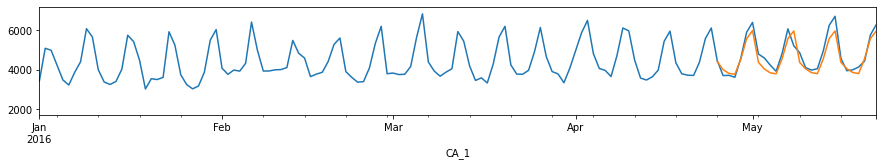

In [167]:
fig, ax = plt.subplots(figsize=[15, 2])
df_ca['CA_1'].plot(ax=ax)
forecast_arima_final.plot(ax=ax)
plt.xlim(left=pd.to_datetime('2016-01-01'))
plt.xlabel('CA_1')
plt.show()

Create a dataframe containing the performance of ARIMA

In [168]:
mae = mean_absolute_error(test_df.CA_1, forecast_arima_final)
mse = mean_squared_error(test_df.CA_1, forecast_arima_final)
mape = mean_absolute_percentage_error(test_df.CA_1, forecast_arima_final)
arima_performance = pd.DataFrame({'MAE': mae,
               'MSE': mse, 
               'MAPE': mape}, index=['CA_1-ARIMA']).T
arima_performance

CA_1-ARIMA
MAE   4.537694e+03
MSE   2.146795e+07
MAPE  5.072753e+01

Now let's compare it with VAR

In [169]:
var_arima_performance = pd.concat([var_performance['CA_1-VAR'], arima_performance], axis = 1)
var_arima_performance['VAR/ARIMA'] = var_arima_performance.apply(
                                        lambda x:x['CA_1-VAR']/x['CA_1-ARIMA'], axis=1) 
var_arima_performance

CA_1-VAR    CA_1-ARIMA  VAR/ARIMA
MAE      291.055625  4.537694e+03   0.064142
MSE   142981.132433  2.146795e+07   0.006660
MAPE       6.092951  5.072753e+01   0.120111

***Observations***:

We see that VAR outperforms ARIMA for the data CA_1.  A similar process could be done for the other 3 stores.

### Performance Evaluation #2 : VAR vs. Data values $n$-days ago

In [170]:
def get_performance_metrics(actual_df, forecast_df, suffix="-VAR"):
    """ Returns a dataframe containing MSE, MAE and MAPE 
    """
    forecast_df.rename(columns={c: c+suffix for c in forecast_df.columns}, inplace=True)    
    return utils.test_performance_metrics(actual_df, forecast_df, suffix=suffix)

In [171]:
df_ca.tail()

CA_1    CA_2    CA_3    CA_4
date                                      
2016-05-18  3995.0  3789.0  5375.0  2519.0
2016-05-19  4136.0  4037.0  5580.0  2544.0
2016-05-20  4433.0  4751.0  5542.0  2704.0
2016-05-21  5764.0  7120.0  7073.0  3146.0
2016-05-22  6289.0  6614.0  8144.0  3597.0

#### vs. values 1-day ago

Let's create a forecast which is based on the previous day's values

In [172]:
forecast_naive_1d = df_ca.copy()
forecast_naive_1d = forecast_naive_1d.shift(1)
forecast_naive_1d = forecast_naive_1d[-fh:]
forecast_naive_1d.tail()

CA_1    CA_2    CA_3    CA_4
date                                      
2016-05-18  3949.0  3963.0  5523.0  2715.0
2016-05-19  3995.0  3789.0  5375.0  2519.0
2016-05-20  4136.0  4037.0  5580.0  2544.0
2016-05-21  4433.0  4751.0  5542.0  2704.0
2016-05-22  5764.0  7120.0  7073.0  3146.0

In [173]:
var_performance_naive_1d = get_performance_metrics(df_ca[-fh:], forecast_naive_1d, suffix="")
var_performance_naive_1d

CA_1          CA_2           CA_3          CA_4
MAE      708.500000  8.465714e+02     721.892857    264.928571
MSE   810733.785714  1.345656e+06  811021.750000  99383.285714
MAPE      14.396843  1.713903e+01      11.225199      9.206016

Recall the performance of our original study

In [174]:
var_performance_d1_p22

CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR
MAE      291.055625     406.771752     353.843012    186.724962
MSE   142981.132433  239912.973224  223568.253308  55920.661288
MAPE       6.092951       8.284302       5.559647      6.528636

Let's rename the columns of var_performance_d1_p22 so we could more easily compare its values 

In [175]:
var_performance_d1_p22.columns = [s[:-4] for s in list(var_performance_d1_p22.columns)]

In [176]:
var_performance_d1_p22

CA_1           CA_2           CA_3          CA_4
MAE      291.055625     406.771752     353.843012    186.724962
MSE   142981.132433  239912.973224  223568.253308  55920.661288
MAPE       6.092951       8.284302       5.559647      6.528636

In [177]:
var_performance_naive_1d/var_performance_d1_p22

CA_1      CA_2      CA_3      CA_4
MAE   2.434243  2.081195  2.040150  1.418817
MSE   5.670215  5.608933  3.627625  1.777219
MAPE  2.362869  2.068856  2.019049  1.410098

VAR outperformed the model based on data values 1 day ago

#### vs. values 7-days ago

In [178]:
forecast_naive_7d = df_ca.copy()
forecast_naive_7d = forecast_naive_7d.shift(7)
forecast_naive_7d = forecast_naive_7d[-fh:]
forecast_naive_7d.tail(7)

CA_1    CA_2    CA_3    CA_4
date                                      
2016-05-16  4859.0  3999.0  6958.0  3100.0
2016-05-17  4104.0  4092.0  5960.0  2815.0
2016-05-18  3982.0  3722.0  5884.0  2603.0
2016-05-19  4049.0  3751.0  5039.0  2659.0
2016-05-20  4951.0  4839.0  6046.0  2635.0
2016-05-21  6245.0  6507.0  7029.0  3256.0
2016-05-22  6707.0  6710.0  7969.0  3318.0

In [179]:
var_performance_naive_7d = get_performance_metrics(df_ca[-fh:], forecast_naive_1d, suffix="")
var_performance_naive_7d

CA_1          CA_2           CA_3          CA_4
MAE      708.500000  8.465714e+02     721.892857    264.928571
MSE   810733.785714  1.345656e+06  811021.750000  99383.285714
MAPE      14.396843  1.713903e+01      11.225199      9.206016

In [180]:
var_performance_naive_7d/var_performance_d1_p22

CA_1      CA_2      CA_3      CA_4
MAE   2.434243  2.081195  2.040150  1.418817
MSE   5.670215  5.608933  3.627625  1.777219
MAPE  2.362869  2.068856  2.019049  1.410098

VAR outperformed the model based on data values 7 days ago

#### vs. average of values 7-days ago

In [181]:
forecast_rollavg_7d = df_ca.copy()
forecast_rollavg_7d = forecast_rollavg_7d.rolling(7).mean()
forecast_rollavg_7d = forecast_rollavg_7d[-fh:]
forecast_rollavg_7d.tail(7)

CA_1         CA_2         CA_3         CA_4
date                                                          
2016-05-16  4943.714286  4837.000000  6259.714286  2901.428571
2016-05-17  4921.571429  4818.571429  6197.285714  2887.142857
2016-05-18  4923.428571  4828.142857  6124.571429  2875.142857
2016-05-19  4935.857143  4869.000000  6201.857143  2858.714286
2016-05-20  4861.857143  4856.428571  6129.857143  2868.571429
2016-05-21  4793.142857  4944.000000  6136.142857  2852.857143
2016-05-22  4733.428571  4930.285714  6161.142857  2892.714286

In [182]:
var_performance_rollavg_7d = get_performance_metrics(df_ca[-fh:], forecast_rollavg_7d, suffix="")
var_performance_rollavg_7d

CA_1          CA_2           CA_3          CA_4
MAE      744.428571  9.160204e+02     745.224490    267.357143
MSE   805626.322157  1.195062e+06  762454.950437  95362.431487
MAPE      15.318793  1.846428e+01      11.813139      9.380424

In [183]:
var_performance_rollavg_7d/var_performance_d1_p22

CA_1      CA_2      CA_3      CA_4
MAE   2.557685  2.251927  2.106088  1.431823
MSE   5.634494  4.981233  3.410390  1.705317
MAPE  2.514183  2.228828  2.124800  1.436812

VAR outperformed the model based on average data values for a window of 7 days

***Observation***: 

VAR outperformed naive models (previous values/ moving average values).

## Some Studies on Differencing and Stationarity 

In this section, we take a look at the effect of data transformation and stationarity.

First recall that our original data is not stationary

In [184]:
adf_test_res = adf_test(df_ca)
adf_test_res

CA_1      CA_2      CA_3      CA_4
Test statistic       -1.883900  0.170215 -2.378623 -1.321314
p-value               0.339673  0.970541  0.147861  0.619366
Critical value - 1%  -3.433771 -3.433771 -3.433771 -3.433771
Critical value - 5%  -2.863051 -2.863051 -2.863051 -2.863051
Critical value - 10% -2.567575 -2.567575 -2.567575 -2.567575

In [185]:
check_stationarity(adf_test_res)

CA_1    False
CA_2    False
CA_3    False
CA_4    False
dtype: bool


### Define Utility Functions 

#### Utility functions for data transformation

To facilitate running several tests, we define utility functions below for differencing and de-differencing.

In [186]:
def difference_transform(data_df, diff_period):
    return data_df.diff(diff_period).dropna()

In [187]:
def reverse_difference_transform(data_df, forecast_df, horizon, diff_period):
    """ Apply reversed differencing to get undifferenced forecast
        Parameters
            data_df: Original undifferenced data
            forecast_df : Forecast made based on a differenced data
            horizon : forecast horizon (number of predictions in the forecast)
            diff_period : Periods used to generate differenced data on which the forecast was made
        
    """
    # define shorter variables for readability
    d = diff_period
    h = horizon    
    
    # extract d time periods of raw data and save in an auxiliary dataframe
    # length of extracted data is d; start and end indices as follows:
    # start index  = -h-d (index diff_periods ago prior to forecast)
    # end index    = -h (index prior to forecast)    
    df_aux = data_df[-h-d:-h]  
    
    # concatenate the forecast to the auxiliary dataframe     
    df_aux = pd.concat([df_aux, forecast_df], axis=0)

    # debug: print('aux indices', -(d+h),-h)
    # debug: print('df_aux.shape[0]',df_aux.shape[0])

    # perform reverse differencing 
    # Note: It's important to begin with the lower indices
    for i in range(d, df_aux.shape[0]):
        # debug: print(i,i-d,df_aux.iloc[i],df_aux.iloc[i-d], df_aux.iloc[i] + df_aux.iloc[i-d])
        df_aux.iloc[i] = df_aux.iloc[i] + df_aux.iloc[i-d]
    reversed_differenced = df_aux[d:]
    
    # the length should be h
    if reversed_differenced.shape[0]!=h:
        print('Warning (reverse_difference_transform): Length of reversed differenced dataframe is not equal to horizon.')
    return reversed_differenced

Let's briefly check if the function is working correctly.

In [188]:
np.random.seed(2872)
temp = pd.Series(np.random.rand(10))
temp

0    0.358423
1    0.664367
2    0.262920
3    0.068389
4    0.371053
5    0.002230
6    0.865731
7    0.801206
8    0.160608
9    0.211995
dtype: float64

In [189]:
temp_d3 = difference_transform(temp, 3)
temp_d3

3   -0.290034
4   -0.293314
5   -0.260690
6    0.797342
7    0.430153
8    0.158378
9   -0.653736
dtype: float64

In [190]:
# simulate a forecast values of 0.2 for a horizon of 4
forecast = temp_d3[-4:] * 0 + 0.2
forecast

6    0.2
7    0.2
8    0.2
9    0.2
dtype: float64

In [191]:
# check reverse difference transform
reverse_difference_transform(temp_d3, forecast, horizon=4, diff_period=3)

6   -0.090034
7   -0.093314
8   -0.060690
9    0.109966
dtype: float64

We can see that the values for index 6, 7, and 8 are 0.2 more than the original data at index 3,4, and 5 (diff of 3) and that 
value at index 9 is 0.2 more than value at index 6. Thus, our reverse difference function is working correctly.

#### Define Utility Functions for checking stationarity

In [192]:
def get_stationarity(adf_results):
    """ Given the ADF results in a dataframe, 
        check if Test statistic is less than the critical values
        Returns a series with the boolean values for stationarity
    """
    return (adf_results.loc['Test statistic']< adf_results.loc['Critical value - 1%']) & \
        (adf_results.loc['Test statistic']< adf_results.loc['Critical value - 5%']) & \
        ( adf_results.loc['Test statistic']< adf_results.loc['Critical value - 10%'])

In [193]:
def check_stationarity_by_differencing(data, diff_values):
    """ Try out different periods for checking the stationarity of a first-order differenced data. 
        ADF is used for testing stationarity.
        Return a dictionary with diff period as index and 
        with the values as a series containing the stationarity of the data differenced with the given period
    """
    results = {}
    for d in diff_values:
        results[d] = get_stationarity(
            adf_test(
                    data.diff(periods=d
                              ).dropna()
            )
        )
    return results

In [194]:
pd.DataFrame(check_stationarity_by_differencing(df_ca,  range(10))).T

CA_1   CA_2   CA_3   CA_4
0  False  False  False  False
1   True   True   True   True
2   True   True   True   True
3   True   True   True   True
4   True   True   True   True
5   True   True   True   True
6   True   True   True   True
7   True   True   True   True
8   True   True   True   True
9   True   True   True   True

We see that the data is $I(1)$ for diff periods 1 to 9 

#### Utility functions for generating a VAR model and Generating Forecast

In [195]:
def auto_var(data, horizon, criterion='aic'):
    """ Creates a VAR model automatically based on information criteria
        Parameters:
            data: dataframe containing training and test sets
            horizon: training and test sets are divided according to forecast horizon value
            criterion: the information criterion to use in selecting a model
        Returns:
            VAR model fitted with chosen p 
            chosen p value  
            dataframe of forecasts
    """
    h = horizon                  # forecast horizon, the number of forecasts to make
    train_df = data.iloc[:-h,] # use all but last fh values for training
    test_df = data.iloc[-h:,]  # last fh values for testing   

    model = VAR(train_df)  
    model_orders = model.select_order(maxlags=40)
    p = model_orders.selected_orders[criterion]
    var_model = model.fit(p)
    forecast = var_model.forecast(train_df.values, steps=h)
    forecast_df = pd.DataFrame(forecast, columns=test_df.columns, index= test_df.index)
    return var_model, p, forecast_df

##### Define a new utility function that can handle differencing

In [236]:
def auto_var_transform(data, horizon, diff_period, criterion='aic', fixed_cols=[]):
    """ Creates a VAR model automatically based on information criteria
        Parameters:
            data: dataframe containing training and test sets
            horizon: training and test sets are divided according to forecast horizon value
            criterion: the information criterion to use in selecting a model
            fixed_cols: Columns of the data that will not be transformed/diffed
        Returns:
            VAR model fitted with chosen p 
            chosen p value  
            dataframe of forecasts
    """
    
    # transform the time series by differencing
    data_diffed = difference_transform(data, diff_period)
        
    # unapply differencing for the fixed columns
    if fixed_cols:
        for col in fixed_cols:
            data_diffed[col] = data[col]
    
    #debug
    check_stationarity(adf_test(data_diffed))

    # create VAR model and generate a forecast using the differenced data
    var_model, p, forecast = auto_var(data_diffed, horizon, criterion)
    
    # get the actual forecast values by reverse differencing        
    forecast_df = reverse_difference_transform(data, forecast, horizon, diff_period)       

    # unapply reversed differencing for fixed columns
    if fixed_cols:
        for col in fixed_cols:
            forecast_df[col] = forecast[col]
    
    return var_model, p, forecast_df    

### Study on Differencing Period

#### With First Order Differencing, period=1

In [197]:
var_model_d1, p_d1, forecast_d1 = auto_var_transform(df_ca, horizon=fh, diff_period=1)
var_performance_d1 = get_performance_metrics(df_ca[-fh:], forecast_d1)
var_performance_d1

CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR
MAE      291.741451     376.660480     327.929525    174.012871
MSE   148530.512698  233125.344320  178498.914635  51109.142326
MAPE       6.107463       7.350713       5.213683      6.028413

In [198]:
var_model_d1.is_stable()

True

In [199]:
abs(var_model_d1.roots)<=1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False])

#### With First Order Differencing, period=7

In [200]:
var_model_d7, p_d7, forecast_d7 = auto_var_transform(df_ca, horizon=fh, diff_period=7)
var_performance_d7 = get_performance_metrics(df_ca[-fh:], forecast_d7)
var_performance_d7

CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR
MAE      357.327494     357.842696     428.087289    216.691510
MSE   185655.944962  200685.571215  304533.553560  66522.432999
MAPE       7.542946       7.047849       6.892238      7.673277

In [201]:
var_performance_d7/var_performance_d1

CA_1-VAR  CA_2-VAR  CA_3-VAR  CA_4-VAR
MAE   1.224809  0.950040  1.305425  1.245261
MSE   1.249952  0.860848  1.706081  1.301576
MAPE  1.235038  0.958798  1.321952  1.272852

#### With First Order Differencing, period=30

In [202]:
var_model_d30, p_d30, forecast_d30 = auto_var_transform(df_ca, horizon=fh, diff_period=30)
var_performance_d30 = get_performance_metrics(df_ca[-fh:], forecast_d30)
var_performance_d30

CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR
MAE      441.608192     546.537511     496.596381    232.283353
MSE   337144.702078  503219.343547  379184.724654  89988.254227
MAPE       9.733800      11.922369       7.993841      8.393181

In [203]:
var_performance_d30/var_performance_d1

CA_1-VAR  CA_2-VAR  CA_3-VAR  CA_4-VAR
MAE   1.513697  1.451008  1.514339  1.334863
MSE   2.269868  2.158578  2.124297  1.760708
MAPE  1.593755  1.621934  1.533243  1.392270

Differencing with period 1 gave the best performance.

### Study on Unstationary Data

#### Without Differencing

In [204]:
# note that we're using auto_var and not auto_var_transform, which means we are not applying differencing
var_model_ns, p_ns, forecast_ns = auto_var(df_ca, horizon=fh)
var_performance_ns = get_performance_metrics(df_ca[-fh:], forecast_ns)
var_performance_ns

CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR
MAE      287.937909     329.254118     342.900103    184.289812
MSE   142826.912535  178165.155608  187061.897345  55000.038880
MAPE       6.034416       6.441570       5.469213      6.380498

In [205]:
var_performance_ns/var_performance_d1

CA_1-VAR  CA_2-VAR  CA_3-VAR  CA_4-VAR
MAE   0.986963  0.874140  1.045652  1.059059
MSE   0.961600  0.764246  1.047972  1.076129
MAPE  0.988040  0.876319  1.049011  1.058404

Although errors are lower for CA_1 and CA_2, we have to note that VAR is not applicable to non-stationary data

Check if VAR model is stable

In [206]:
var_model_ns.is_stable()

False

Check the roots

In [207]:
var_model_ns.roots

array([ 2.15164285-0.j        , -1.24706271+0.90686562j,
       -1.24706271-0.90686562j, -0.22974446+1.38754299j,
       -0.22974446-1.38754299j,  1.28105916-0.j        ,
        1.12640764-0.25093215j,  1.12640764+0.25093215j,
        1.0283332 +0.50761644j,  1.0283332 -0.50761644j,
       -0.07064121-1.13965064j, -0.07064121+1.13965064j,
        0.71312529+0.88896323j,  0.71312529-0.88896323j,
        0.82313968+0.78537389j,  0.82313968-0.78537389j,
       -0.92267433+0.64603663j, -0.92267433-0.64603663j,
       -1.0967825 -0.24677458j, -1.0967825 +0.24677458j,
        1.08624923-0.28655356j,  1.08624923+0.28655356j,
       -0.86195383-0.71155714j, -0.86195383+0.71155714j,
       -0.42006664+1.03499318j, -0.42006664-1.03499318j,
       -0.25804649-1.0749914j , -0.25804649+1.0749914j ,
       -0.61935911+0.91486542j, -0.61935911-0.91486542j,
       -1.1038357 -0.j        , -0.76439206-0.7955713j ,
       -0.76439206+0.7955713j , -0.99412743+0.47686056j,
       -0.99412743-0.47686056j,

Check presence of unit root

In [208]:
var_model_ns.roots [ np.abs(var_model_ns.roots) <= 1]

array([0.99923087-0.j])

There is one root within the unit circle.

### Pure White Noise (Stationary but unrelated)

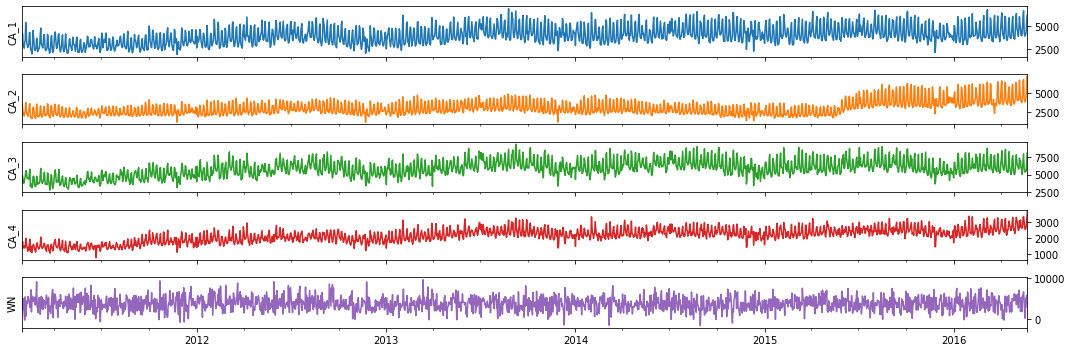

In [209]:
import scipy.stats as st
df_ca_wn = df_ca.copy()
df_ca_wn['WN'] = df_ca.stack().mean() + st.norm.rvs(size=df_ca.shape[0]) * df_ca.stack().std()
dfplot(df_ca_wn, figsize=(15,5))

In [210]:
get_stationarity(adf_test(df_ca_wn))

CA_1    False
CA_2    False
CA_3    False
CA_4    False
WN       True
dtype: bool

#### No differencing, with white noise

In [211]:
var_model_wn, p_wn, forecast_wn = auto_var(df_ca_wn, fh)
var_performance_wn = get_performance_metrics(df_ca_wn[-fh:], forecast_wn, )
var_performance_wn

CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR        WN-VAR
MAE      315.551086     329.211874     349.215929    184.114914  1.658308e+03
MSE   150159.834311  181036.373781  190391.704006  54718.913684  3.613755e+06
MAPE       6.681872       6.393001       5.495340      6.364931  9.497195e+01

Compare with differnced data

In [212]:
# orig data has no WN column
var_performance_wn/var_performance_d1

CA_1-VAR  CA_2-VAR  CA_3-VAR  CA_4-VAR  WN-VAR
MAE   1.081612  0.874028  1.064912  1.058053     NaN
MSE   1.010970  0.776562  1.066627  1.070629     NaN
MAPE  1.094050  0.869712  1.054023  1.055822     NaN

In [213]:
var_model_wn.is_stable()

False

In [214]:
var_model_wn.roots [ np.abs(var_model_wn.roots) <= 1]

array([0.99923352-0.j])

Let's check the coefficients

In [215]:
var_model_wn.params

CA_1       CA_2        CA_3       CA_4           WN
const     71.942676  24.865396  160.240094  45.590740  3336.712473
L1.CA_1    0.334008  -0.015775    0.110506   0.053416    -0.206462
L1.CA_2    0.033061   0.364500    0.136066   0.023660     0.085744
L1.CA_3    0.029206  -0.034184    0.324284   0.028259    -0.090303
L1.CA_4   -0.141078  -0.137497   -0.177003   0.117529     0.489445
...             ...        ...         ...        ...          ...
L29.CA_1   0.052871   0.028654    0.064724   0.039486    -0.114155
L29.CA_2  -0.174616  -0.112407   -0.244070  -0.050452     0.120909
L29.CA_3   0.111970   0.030555    0.113002   0.024753    -0.041766
L29.CA_4   0.059114   0.066735    0.030446   0.001077    -0.280054
L29.WN    -0.000214  -0.001476   -0.001622   0.000657    -0.029264

[146 rows x 5 columns]

In [216]:
var_model_wn.params[var_model_wn.params.index.str.contains('WN')]

CA_1      CA_2      CA_3      CA_4        WN
L1.WN   0.001907 -0.002397 -0.002906  0.004114  0.011027
L2.WN  -0.009813 -0.003465 -0.016900 -0.003417 -0.026149
L3.WN  -0.002249  0.001985 -0.002558 -0.000828  0.005561
L4.WN  -0.001986 -0.009799  0.003136 -0.000388  0.031663
L5.WN   0.004125 -0.000589  0.002151  0.002405  0.006439
L6.WN   0.002230 -0.003268 -0.008189 -0.003868  0.005196
L7.WN   0.000954  0.000692  0.009576  0.001341 -0.003260
L8.WN  -0.000288  0.005787 -0.001087 -0.000707 -0.030103
L9.WN   0.007453  0.009878  0.003363  0.004449 -0.025071
L10.WN  0.001721 -0.007786 -0.003350  0.000132 -0.001918
L11.WN -0.007814 -0.000621 -0.001633 -0.002279  0.013835
L12.WN  0.007198  0.009144  0.012381 -0.000795 -0.015921
L13.WN  0.001376 -0.003282  0.004901  0.002609  0.022479
L14.WN -0.001692 -0.001704  0.003996 -0.001449  0.013990
L15.WN -0.001714  0.001114 -0.006381 -0.005550  0.016991
L16.WN  0.003235 -0.000356 -0.002911 -0.000202  0.044387
L17.WN  0.005214  0.001965  0.002329  0.002530 -0.017242
L18.WN  0.010409  0.007917  0.006801 -0.001599 -0.014731
L19.WN  0.005778  0.005935  0.006345 -0.000406  0.063624
L20.WN  0.010347  0.003435  0.016551  0.004003 -0.005608
L21.WN  0.008884  0.004169  0.009309  0.003215  0.023379
L22.WN -0.006973  0.000281  0.002096 -0.002042  0.022754
L23.WN -0.007052 -0.003499 -0.012344 -0.004599  0.012447
L24.WN  0.010218  0.006269  0.006751  0.001740  0.025604
L25.WN -0.005076 -0.002421 -0.011578 -0.000672  0.002072
L26.WN  0.001352 -0.003818  0.000443 -0.000736  0.034702
L27.WN  0.002806  0.004958  0.001920  0.001073 -0.010069
L28.WN  0.001841 -0.002459  0.006312  0.000519  0.013759
L29.WN -0.000214 -0.001476 -0.001622  0.000657 -0.029264

#### Differenced data columns except  white noise

In [217]:
var_model_d1_wn, p_d1_wn, forecast_d1_wn = auto_var_transform(df_ca_wn, fh, diff_period=1, fixed_cols=['WN'])
var_performance_d1_wn = get_performance_metrics(df_ca_wn[-fh:], forecast_d1_wn, )
var_performance_d1_wn

CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR        WN-VAR
MAE      322.091331     387.098372     331.393775    175.684794  1.620162e+03
MSE   157922.439507  243548.819423  183377.735195  51089.571766  3.496232e+06
MAPE       6.814154       7.552801       5.194918      6.075036  9.538370e+01

In [218]:
var_performance_d1_wn/var_performance_d1

CA_1-VAR  CA_2-VAR  CA_3-VAR  CA_4-VAR  WN-VAR
MAE   1.104030  1.027712  1.010564  1.009608     NaN
MSE   1.063232  1.044712  1.027332  0.999617     NaN
MAPE  1.115709  1.027492  0.996401  1.007734     NaN

In [219]:
var_model_d1_wn.params[var_model_d1_wn.params.index.str.contains('WN')]

CA_1      CA_2      CA_3      CA_4        WN
L1.WN   0.002355 -0.002505 -0.002748  0.004214  0.011654
L2.WN  -0.009347 -0.003497 -0.016622 -0.003334 -0.024817
L3.WN  -0.001721  0.001909 -0.002298 -0.000706  0.005673
L4.WN  -0.001460 -0.009809  0.003468 -0.000288  0.032517
L5.WN   0.004607 -0.000539  0.002506  0.002492  0.006830
L6.WN   0.002630 -0.003216 -0.007842 -0.003788  0.005512
L7.WN   0.001188  0.000675  0.009876  0.001447 -0.003484
L8.WN  -0.000127  0.005760 -0.000850 -0.000614 -0.030090
L9.WN   0.007540  0.009874  0.003644  0.004530 -0.024388
L10.WN  0.001625 -0.007958 -0.003262  0.000267 -0.003326
L11.WN -0.008001 -0.000655 -0.001421 -0.002208  0.014371
L12.WN  0.007054  0.009090  0.012612 -0.000711 -0.015449
L13.WN  0.001314 -0.003429  0.005035  0.002733  0.022102
L14.WN -0.001667 -0.001811  0.004152 -0.001346  0.014205
L15.WN -0.001537  0.001063 -0.006149 -0.005446  0.016992
L16.WN  0.003348 -0.000474 -0.002705 -0.000076  0.044369
L17.WN  0.005205  0.001953  0.002636  0.002614 -0.015865
L18.WN  0.010342  0.007846  0.007026 -0.001479 -0.015375
L19.WN  0.005510  0.005867  0.006559 -0.000310  0.063979
L20.WN  0.009938  0.003342  0.016700  0.004086 -0.004782
L21.WN  0.008382  0.004096  0.009378  0.003268  0.024174
L22.WN -0.007391  0.000161  0.002082 -0.001981  0.023139
L23.WN -0.007405 -0.003644 -0.012381 -0.004529  0.012570
L24.WN  0.010015  0.006119  0.006736  0.001833  0.025089
L25.WN -0.005349 -0.002625 -0.011672 -0.000576  0.001354
L26.WN  0.001116 -0.003938  0.000457 -0.000665  0.034918
L27.WN  0.002475  0.004869  0.001967  0.001133 -0.009570
L28.WN  0.001581 -0.002583  0.006329  0.000594  0.013717

In [220]:
var_model_d1_wn.is_stable()

True

In [221]:
var_model_d1_wn.roots [ np.abs(var_model_d1_wn.roots) <= 1]

array([], dtype=complex128)

### White Noise plus Drift (Non-Stationary and unrelated)

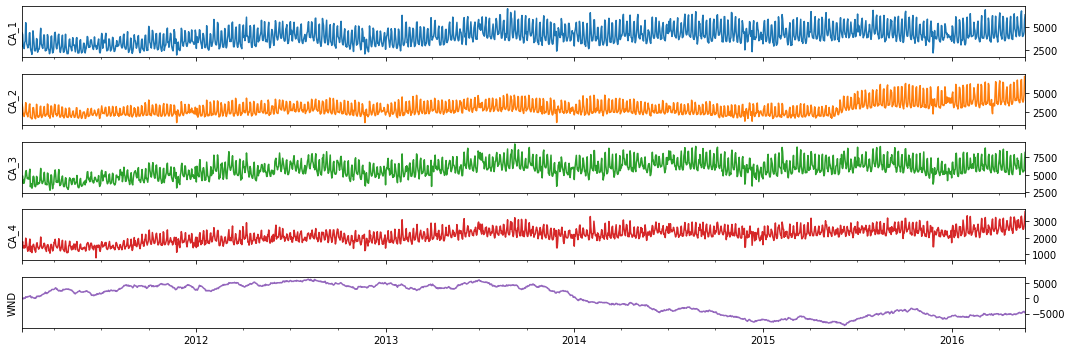

In [292]:
df_ca_wnd = df_ca.copy()
df_ca_wnd['WND'] = st.norm.rvs(size=df_ca.shape[0]) * df_ca.stack().std()/10
df_ca_wnd['WND'] = df_ca_wnd['WND'].cumsum()
dfplot(df_ca_wnd, figsize=(15,5))

In [293]:
get_stationarity(adf_test(df_ca_wnd))

CA_1    False
CA_2    False
CA_3    False
CA_4    False
WND     False
dtype: bool

#### Do not make unrelated data stationary

In [294]:
var_model_wnd_d1, p_wnd_d1, forecast_wnd_d1 = auto_var_transform(df_ca_wnd, fh, diff_period=1, fixed_cols=['WND'])
var_performance_wnd_d1 = get_performance_metrics(df_ca_wnd[-fh:], forecast_wnd_d1)
var_performance_wnd_d1

CA_1     True
CA_2     True
CA_3     True
CA_4     True
WND     False
dtype: bool


CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR        WND-VAR
MAE      292.843894     363.262276     337.329149    174.179764     392.846869
MSE   145037.290102  210640.114007  188243.743311  50810.055722  240487.410332
MAPE       6.117108       7.121816       5.353247      6.030713       8.433737

In [295]:
var_performance_wnd_d1/var_performance_d1

CA_1-VAR  CA_2-VAR  CA_3-VAR  CA_4-VAR  WND-VAR
MAE   1.003779  0.964429  1.028664  1.000959      NaN
MSE   0.976481  0.903549  1.054593  0.994148      NaN
MAPE  1.001579  0.968861  1.026769  1.000381      NaN

In [296]:
var_model_wnd_d1.params[var_model_wnd_d1.params.index.str.contains('WND')]

CA_1      CA_2      CA_3      CA_4       WND
L1.WND   0.086332  0.065644  0.099739 -0.019952  0.988401
L2.WND  -0.144120 -0.110249 -0.208338  0.004018  0.019138
L3.WND   0.092927  0.079084  0.231410  0.043674  0.068903
L4.WND   0.042720  0.043565 -0.048888 -0.024300 -0.077559
L5.WND  -0.044176 -0.067519 -0.041310  0.016674  0.051768
L6.WND  -0.088064  0.013876 -0.060171 -0.006206 -0.076888
L7.WND   0.117427  0.083940  0.097569  0.027798  0.059468
L8.WND  -0.033118 -0.079471 -0.019861 -0.021787 -0.046297
L9.WND   0.012482  0.003770 -0.084103 -0.002996 -0.003511
L10.WND -0.015189 -0.029460  0.036792  0.007255  0.008613
L11.WND  0.004841 -0.036456  0.071282 -0.001207 -0.000807
L12.WND -0.013264  0.103144 -0.104602 -0.020877  0.033165
L13.WND  0.039924 -0.064242  0.210172 -0.017906  0.013939
L14.WND -0.064166  0.008541 -0.226578 -0.005993 -0.047874
L15.WND -0.003814  0.007577  0.092405  0.035366  0.007701
L16.WND  0.042726  0.036414 -0.001811 -0.027996 -0.038357
L17.WND  0.054608 -0.089414  0.088008  0.066590  0.023422
L18.WND -0.126162  0.014838 -0.126352 -0.069734 -0.012613
L19.WND  0.080877 -0.030387 -0.021320  0.024897  0.049568
L20.WND -0.032741  0.036172 -0.047093 -0.045270 -0.017298
L21.WND  0.057425  0.017380  0.163774  0.089861  0.052138
L22.WND -0.011573 -0.031059 -0.135673 -0.041878 -0.095148
L23.WND -0.100058  0.064069  0.009344 -0.010667  0.018723
L24.WND  0.054968  0.032916  0.126659  0.000685  0.001596
L25.WND -0.026859 -0.055403 -0.124734  0.018273  0.054539
L26.WND  0.012836 -0.039905  0.050825 -0.021808 -0.035485
L27.WND  0.024895  0.064242  0.064141  0.037650 -0.011707
L28.WND -0.021071 -0.043945 -0.090140 -0.034196  0.012260

Coefficient of Lag 2 for WND is 1, showing the trend

In [297]:
var_model_wnd_d1.is_stable()

True

In [298]:
var_model_wnd_d1.roots[ np.abs(var_model_wnd_d1.roots) <= 1]

array([], dtype=complex128)

***Observation***

Even with mixing one unstationary series, a VAR model without unit roots was still produced.

#### Make unrelated data stationary

In [299]:
var_model_wnd_d1_s, p_wnd_d1_s, forecast_wnd_d1_s = auto_var_transform(df_ca_wnd, fh, diff_period=1)
var_performance_wnd_d1_s = get_performance_metrics(df_ca_wnd[-fh:], forecast_wnd_d1_s)
var_performance_wnd_d1_s

CA_1    True
CA_2    True
CA_3    True
CA_4    True
WND     True
dtype: bool


CA_1-VAR       CA_2-VAR       CA_3-VAR      CA_4-VAR        WND-VAR
MAE      289.503364     381.725682     341.154206    174.068461     417.909302
MSE   143664.081893  235619.599126  191982.323438  50765.011011  270113.186310
MAPE       6.046932       7.469152       5.413988      6.027540       8.968167

In [300]:
var_performance_wnd_d1_s/var_performance_d1

CA_1-VAR  CA_2-VAR  CA_3-VAR  CA_4-VAR  WND-VAR
MAE   0.992329  1.013448  1.040328  1.000319      NaN
MSE   0.967236  1.010699  1.075538  0.993267      NaN
MAPE  0.990089  1.016113  1.038419  0.999855      NaN

In [301]:
var_model_wnd_d1_s.is_stable()

True

In [302]:
var_model_wnd_d1_s.roots[ np.abs(var_model_wnd_d1_s.roots) <= 1]

array([], dtype=complex128)

### Summary on Observations on the Study on Differencing and Stationarity
* The differencing period that worked best was 1.
* Performng VAR without making the time series stationary resulted in an unstable model
* Including an unrelated white noise, but without differencing, also resulted in an unstable model
* Including an unrelated white noise and differencing the data resulted in a stable model
* Adding an unrelated non stationary data, (but with the differenced) could still produce a stable model 
* Adding an unrelated non stationary data that is differenced together with the rest of the data produced a stable model

#### Discussion and Conclusion
* Adding unrelated data does not zero out the coefficients related to it, meaning, it is still included in the OLS, thus providing unwanted noise.
* A VAR model could still be produced with unstationary data (the model will not blow up, given a sufficiently small number of observations), however, doing so is not recommended.

Take note that all observations above are based on experimental VAR modesl created from the M5 California Stores Total Sales.   


----

# SUMMARY
* VAR methods are useful when dealing with multivariate time series, as they allow us to use the relationship between the different variable to forecast. 
* These models allow us to forecast the different variables simultaneously, with the added benefit of easy (only 1 hyperparameter) and fast training. 
* Using the fitted VAR model, we can also explain the relationship between variables, and how the perturbation in one variable affects the others by getting the impulse response functions and the variance decomposition of the forecasts. 
* However, the application of these models is limited due to the stationarity requirement for ALL the variables in the multivariate time series. This method won't work well if there is at least one variable that's non-stationary. When dealing with non-stationary multivariate time series, one can explore the use of vector error correction models (VECM). 


## Preview to the Next Chapter
In the next chapter, we further extend the use of VAR models to explain the relationships between variables in a multivariate time series using **Granger causality**, which is one of the most common ways to describe causal mechanisms in time series data.

## References
**Main references**
- [1] Lütkepohl, H. (2005). New introduction to multiple time series analysis. Berlin: Springer.
- [2] Kilian, L., & Lütkepohl, H. (2018). Structural vector autoregressive analysis. Cambridge: Cambridge University Press.


**Supplementary references** are listed [here](VARreferences.txt).